# 🔎 Retrieval (and QG?) playground

In [3]:
import json, random
import matplotlib.pyplot as plt
from langchain_core.example_selectors import (
    MaxMarginalRelevanceExampleSelector,
    SemanticSimilarityExampleSelector,
)
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_community.retrievers import KNNRetriever
from IPython.display import display, Markdown, Latex
from sentence_transformers import CrossEncoder
from langchain_community.vectorstores import FAISS
from tqdm.notebook import tqdm
from langchain_community.retrievers import BM25Retriever

embeddings = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")


## ⚙️ 0. Choose claim & docstore

In [2]:
random.seed(111)

In [3]:
random.randint(0, 500)


423

In [4]:
CLAIM_ID = 252
datapoint = json.load(open("data/dev.json"))[CLAIM_ID]
claim = datapoint["claim"]
docstore = []
for line in open(f"data_store/output_dev/{CLAIM_ID}.json"):
    docstore.append(json.loads(line))

# print claim in markdown with some sample evidence
display(Markdown("### 🗯️ " + claim + " [" + datapoint["label"] + "]"))
# sample 3
for i in random.sample(range(len(docstore)), 3):
    newline = "\n"
    display(Markdown(f"**{docstore[i]['url']}**\n\n * {newline.join(docstore[i]['url2text'][:10])}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China. [Refuted]

**https://www.nytimes.com/2019/11/26/arts/music/judy-collins.html**

 * 

**https://azsos.gov/elections/campaign-finance/financial-disclosure-statements/2022-financial-disclosure-statements**

 * 

**https://www.wsj.com/articles/employees-ask-facebook-to-reverse-policy-on-political-ad-fact-checking-11572311436**

 * 

### 🗂️ 0.1 Docstore formatting/scraping

In [5]:
for CLAIM_ID in tqdm(range(38,500)):# Naive version with \n concatenated url2texts:   
    datapoint = json.load(open("data/dev.json"))[CLAIM_ID]
    claim = datapoint["claim"]
    display(Markdown("### 🗯️ " + claim + " [" + datapoint["label"] + "]"))
    docstore = []
    for line in open(f"data_store/output_dev/{CLAIM_ID}.json"):
        docstore.append(json.loads(line))
        
    documents = [
        Document(
            page_content=" ".join(doc["url2text"]),
            metadata={
                "url": doc["url"],
                # "sentences": doc["url2text"]
            },
        )
        for doc in docstore
    ]

    TOKENS_PER_CHAR = 0.25
    EMBEDDING_INPUT_SIZE = 512

    chunks = []
    for doc in docstore:
        buffer = ""
        for i, sentence in enumerate(doc["url2text"]):
            if (
                i == len(doc["url2text"]) - 1
                or len(buffer) + len(sentence) >= EMBEDDING_INPUT_SIZE / TOKENS_PER_CHAR
            ):
                context_before = ""
                if chunks and chunks[-1].metadata["url"] == doc["url"]:
                    chunks[-1].metadata["context_after"] = buffer
                    context_before = chunks[-1].page_content
                chunks.append(
                    Document(
                        page_content=buffer,
                        metadata={"url": doc["url"], "context_before": context_before, "context_after": ""},
                    )
                )

                buffer = ""
            buffer += sentence + " "
    # chunk the documents into smaller pieces
    chid = random.randint(0, len(chunks))

    # display(Markdown(chunks[chid].metadata["context_before"]))
    # display(Markdown(chunks[chid].page_content))
    # display(Markdown(chunks[chid].metadata["context_after"]))
    
    print(chunks[chid].page_content)
    retriever = BM25Retriever.from_documents(
        chunks, k=1500
    )
    chunks_pruned = retriever.invoke(claim)
    db = FAISS.from_documents(chunks_pruned, embeddings)
    db.save_local(f"data_store/vector_store_dev/{CLAIM_ID}")
    
                          

  0%|          | 0/462 [00:00<?, ?it/s]

### 🗯️ Hunter Biden, son of US President Joe Biden has died. [Refuted]

It is a national security issue, energy is, given where we buy so much of our petroleum products from, which is why we decided to invest in new vehicle technology to the extent of $273 million so we can get more miles per gallon, setting aside the issue of Yucca, investing $792 million in nuclear energy, and doing extensive biomass research. There is an environmental aspect to this as well, and that is why we set aside monies for advanced clean energy and technologies to reduce And finally, I would point out, given national security, we have set aside $1.5 billion for nuclear nonproliferation programs. Mr. LEWIS of California. Mr. Speaker, I yield myself so much time as Mr. Speaker, it's a very unusual circumstance for me to do this, but addressing my colleague, the chairman of the full committee, personally, let me say that you've heard a lot from me about the fact that I am disconcerted about the way we got here, but nonetheless, this omnibus process has been a long and difficult one

### 🗯️ 5G causes COVID-19. [Refuted]

In wastewater treatment, a disinfection step with chlorine, ultra-violet (UV) radiation or ozonation can be included as tertiary treatment to remove pathogens from wastewater, for example if it is to be discharged to a river or the sea where there body contact immersion recreations is practiced (Europe) or reused to irrigate golf courses (US). An alternative term used in the sanitation sector for disinfection of waste streams, sewage sludge or fecal sludge is sanitisation or sanitization.[citation needed] The Australian Therapeutic Goods Order No. 54 defines several grades of disinfectant as will be used below.[13] Sterilant means a chemical agent which is used to sterilize critical medical devices or medical instruments. A sterilant kills all micro-organisms with the result that the sterility assurance level of a microbial survivor is less than 10^-6. Sterilant gases are not within this scope.[citation needed] Low level disinfectant means a disinfectant that rapidly kills most vegetat

### 🗯️ Rock musician Jon Bon Jovi performed for 12 people and 7 pumpkins at a campaign event for Democratic presidential nominee Joe Biden in Pennsylvania. [Refuted]

Wilma Hit Mexico; Bush White House Troubles; Pamela Vitale's Killer Will Be Treated As An Adult; Government Not Taking Chances With Wilma; Betty Nguyen Goes To Vietnam Residents Of Florida Await Wilma; Wilma Slams Mexico; Son Of Hariri Wants Killers Brought To Justice; Judith Miller May Have Misled Colleagues; Officials Try To Identify Man Frozen In Glacier; National Hurricane Center Wilma Briefing Wilma Hits Yucatan Peninsula Hard; Judith Miller May Have Been Misleading; Syria Linked To Killing Of Hariri; Tips To Save On Heating Costs Iraqi Election Will Determine Whether Constitution Is Approved; Satellite Images Of Hurricane And Earthquake Regions Available To Public; Constitution Approval May Affect U.S. Troops Historic Voting Winding Down In Iraq; Election Could Impact Timeline For Troops; What The Iraqi Vote Might Mean For Women Polls Close In Iraq; Gunfire Heard As Polls Close; Vote Could Affect U.S. Troops; Sunnis, Shia And Kurds Vote On Constitution; Women's Rights Issues Disc

### 🗯️ Wearing face masks can cause infections from bacteria such as staphylococcus. [Refuted]

or connect to a urinary catheter bag at night or if Body image disturbance may occur because of the change in body function. A consultation with a nurse who specializes in wound, ostomy, and continence care (WOC nurse) or an ostomy support group may be helpful both before and after surgery. Cancer of the kidney is among the 10 most common cancers in both men and w omen. The ACS (2013) estimates about 65,150 new cases of kidney cancer will occur in 2013. The lifetime risk of kidney cancer is 1 in 63. Risk factors include genetics, smoking, obesity, hypertension, years of kidne y dialysis, and exposure to radiation, asbestos, and industrial pollution. Most patients with kidney cancer are over age 55. It is rare under the age of 45. Men ha ve twice the incidence of women. Often the cancer has metastasized before it is   diagnosed because the kidney has such a large volume of cir- culating blood, which increases the risk of tumor spread. In The three classic symptoms of kidney cancer are h

### 🗯️ An 'anti-Black Lives Matter' flag replaced the American flag behind President Trump during a Waukesha campaign rally. [Supported]

could be said that the classification was substantially related to achievement of the objective. 54 However, the Court observed that the State already conducted individualized hearings with respect to the need of the wife, so that with little additional burden needy males could be identified and helped. The use of the sex standard 55 Id. at 280–83. An administrative convenience justification was not available, therefore. Id. at 281 & n.12. While such an argument has been accepted as a suffi- cient justification in at least some illegitimacy cases, Mathews v. Lucas, 427 U.S. 495, 509 (1976), it has neither wholly been ruled out nor accepted in sex cases. In Lucas, supra, 509–10, the Court interpreted Frontiero v. Richardson, 411 U.S. 677 (1973), as having required a showing at least that for every dollar lost to a recipient not meeting the general purpose qualification a dollar is saved in administrative ex- pense. In Wengler v. Druggists Mutual Ins. Co., 446 U.S. 142, 152 (1980), the C

### 🗯️ Donald Trump said that $15 an hour is too much for essential workers [Conflicting Evidence/Cherrypicking]

lies and, more particularly, the award of the rights responses can be organized in terms of four positions. 1. Biological imperative. For those who adopt this position, legal rules and outcomes are, or ought to be, dictated by biology. Parenthood and the rights and responsibilities associated with parent-child rela- ﬂowing out of biological relationships. This is an ancient and still highly inﬂuential way of thinking may reﬂect a view that biological connection itself that separation is virtually unendurable, so powerful that the biological parent is compelled to subordi- nate his or her own interests to those of the child. Therefore, biological matching of parent and child child, since the parent known or revealed as having a mere social connection to the child will inevitably fail to fulﬁll the child’s deepest needs. This view may be fostered and strengthened by the increasing atten- other hand, the biological imperative may be viewed solely in terms of ﬁnancial responsibility. Engag

### 🗯️ Deliberately infecting children to COVID-19 at “pox parties” could be a good way to help create herd immunity against COVID-19 without a vaccine. [Refuted]

No microbiologic standards for ice, ice-making machines, or ice storage equipment have been established, although several investigators have suggested the need for such standards.859, 866 Culturing of ice machines is not routinely recommended, but it may be useful as part of an epidemiologic investigation.867–869 Sampling might also help determine the best schedule for cleaning open ice-storage chests.  Recommendations for a regular program of maintenance and disinfection have been published.866–869  Health-care facilities are advised to clean ice-storage chests on a regular basis. Open ice chests may require a more frequent cleaning schedule compared with chests that have covers. Portable ice chests and containers require cleaning and low-level disinfection before the addition of ice intended for  consumption. Ice-making machines may require less frequent cleaning, but their maintenance is important to proper performance. The manufacturer’s instructions for both the proper method of c

### 🗯️ Cutting the umbilical cord straight away deliberately denies the baby natural immunity so that medical professionals have a reason to vaccinate and medicate them. [Refuted]

David Andrukonis, when Syron was considering whether to authorize a “Ninja” (no  income/no jobs/no assets) product that he ultimately approved. Andrukonis argued  against authorizing Freddie’s purchase: “Th e potential for the perception and reality  121 Fannie Mae, “Costs and Benefi ts of Mission Activities, Project Phineas,” June 14, 2005. 122 Barry Zigas, “Housing Goals and Minority Lending,” September 30, 2005. 123 Fannie Mae, “Update on Fannie Mae’s Housing Goals Performance,” Presentation to the U.S.  Department of Housing and Development, October 31, 2005. of predatory lending, with this product is great.”124 But the product was approved  by Freddie, probably for the reason stated by another Freddie employee: “Th e Alt-A  [(low doc/no doc)] business makes a contribution to our HUD goals.”125 On May 5, 2006, a Fannie staff  memo to the Single Family Business Credit  Committee revealed the serious credit and fi nancial problems Fannie was facing  when acquiring subprime mortgages 

### 🗯️ The umbilical cord should not be cut until 1 hour after birth or they baby will not have enough blood right after birth. [Refuted]

Jazmin Cardenas, Petitioner(s). vs. Eduardo Cardenas, Respondent(s). Long Le, Petitioner(s). vs. Trang Cao, Respondent(s). Jelisa Armstrong, Petitioner(s). vs. Torrey Cross, Respondent(s). Alejandro Aguilar, Petitioner(s). vs. Christina Harrington, Respondent(s). Adriana Espinoza, Petitioner(s). vs. Douglas Escobar, Jr., Respondent(s). Jacqueline Quinoes, Petitioner(s). vs. Tanzie Lee Austin, Jr., Respondent(s). Cynthia F Icasiano, Petitioner(s).  vs.  Sean R Young, Respondent(s). Symone Ronnie Phillips, Petitioner(s). vs. Jeramy Edward Brown, Respondent(s). Catedra Owens-Hayes, Petitioner(s). vs. Jermaine Morde Bowen, Respondent(s). Taquyyah Porter, Petitioner(s). vs. Anthony Ja'quanne Stewart, Respondent(s). Chasarae Lorenzo, Petitioner(s). vs. Joshua Freeman, Respondent(s). Celina Cruz, Petitioner(s). vs. Thaison Shelter, Respondent(s). Pierre E Simonvil, Petitioner(s). vs. Kelly L Younkerman, Respondent(s). Richard Edward Hagenbuch, Petitioner(s). vs. Kristina Rose Stabile, Respond

### 🗯️ Joe Biden said he wants to ban fracking in the US. [Conflicting Evidence/Cherrypicking]

Norma MT and Carl W Braun, 1Jean Johnston, 37322 Christopher Nall, 80903 Janna Brown, 97035  Elaina A Delvino, 10594 Jean Johnston, 37322 Julie Poulson, 80903 Mary Goss, 97035  Elaina Delvino, 10594 Eve Duplissis, 37323 David Thompson, 80903 Jo Jansen, 97035  mia rotfeld, 10595 Catherine Gonzales, 37323 David Thompson, 80903 Michelle Jin, 97035  Mary Loomba, 10595-1639 Catherine Gonzales, 37323-813G. Bommelaere, 80903-3014 Susanna Kuo, 97035  Helen LeBrecht, 10597 Eve Duplissis, 37323-8645 Kent Borges, 80904 Barbara Manildi, 97035  Renee Purse, 10597 Jeanie Stephenson, 37324 Kent Borges, 80904 Heather Marsh, 97035  Renee Purse, 10597 John Urstadt, 37325-5001 Maryanne Embury, 80904 Susan Marsh, 97035  Helen LeBrecht, 10597-1010 Nancy Mcbride, 37327 Teresa Johnson, 80904 Heather Marsh, 97035  Stephanie Atkinson, 10598 RoseMarie Morelan, 37331-521Haakon Krey, 80904 LuAnn Yocky, 97035  MIchele Johnson, 10598 Veronica Bourassa, 37332 Sheree Lynn, 80904 Heather Marsh, 97035-113  Michele John

### 🗯️ 99% of people recover from COVID-19. [Refuted]

In a SARS trial of 80 patients, administration of convalescent plasma within 14 days of onset of illness was associated with a better outcome compared with treatment later in the course of their illness. This suggests that convalescent plasma would be more likely to be effective early after infection or appearance of symptoms. Is there any experience with plasma therapy in the current COVID-19 epidemic? A recent report from JAMA describes five critically ill, mechanically ventilated patients in China with COVID-19 who received convalescent plasma. These patients’ clinical improvement was associated with receipt of the plasma but no conclusions can be drawn regarding the efficacy of the approach. What are the considerations or risks of therapeutic convalescent plasma? Given past experiences, the high mortality rate in critically ill patients with COVID-19, and the absence to date of any proven effective therapies, the use of convalescent COVID-19 plasma is a very reasonable approach to 

### 🗯️ The US saw the best carbon emission numbers in 35 years under President Donald Trump's administration. [Refuted]

responsibility and the preparation of NEPA documents by contractors and  Response: The CEQ regulations should be revised to explicitly authorize project applicants  to prepare draft environmental analyses for an agency's review that the agency can use as  the technical basis for both EAs and EISs. The existing regulations at 40 CFR § 1506.5(b)  already specifically authorize an applicant to prepare an EA:  (b) Environmental assessments. If an agency permits an applicant to prepare an  environmental assessment, the agency, besides fulfilling the requirements of paragraph (a) of  this section, shall make its own evaluation of the environmental issues and take  responsibility for the scope and content of the environmental assessment.  This provision should be revised to be clearly applicable to both EAs and EISs. There is  no rationale for allowing applicant-prepared EAs and not allowing applicant-prepared  Some federal agencies encourage or even require applicant participation in the NEP

### 🗯️ Twitter now putting warnings on tweets that are just unedited clips of Biden saying he would end fracking [Conflicting Evidence/Cherrypicking]

_____________________________________________________________________________  Ticket: # 1258398 - Capturing of internet access by Xfinity  _____________________________________________________________________________  On a visit to Lakewood, Colorado this week, I was appalled at the almost constant interception and  capturing of my online access, by Xfinitywifi. It is intrusive, annoying, and I suspect illegal for  Xfinitywifi to constantly interrupt and intercept users like myself from being able to gain internet access without  being constantly  interrupted by their intrusive  capture, intercept and hijacking our I experienced the exact situation approximately six months ago on a visit to the same location and  was told by the people's whose home I was visiting that despite constant complaints to Xfinitywifi by many people in their location, that nothing has been done to stop this offensive and probably illegal practice. Hopefully the FCC can put a stop to this or impose penalties o

### 🗯️ People who do not vote for the Bharatiya Janata Party (BJP) in the 2020 elections will not get the COVID vaccine free of cost. [Refuted]

China us trade war, america china relations, us china tensions, us china, World News in Hindi, World News in Hindi, World Hindi News https://www.prabhasakshi.com/trending/hindi-is-the-language-of-every-class-from-literate-to-illiterate देश की शान है हिंदी, साक्षर से निरक्षर तक हर वर्ग की भाषा है हिंदी hindi diwas, hindi diwas 2020, hindi diwas slogan, hindi diwas history in hindi language, hindi diwas kab manaya jata hai, hindi diwas kyu manaya jata hai, hindi diwas manane ka uddeshya, hindi diwas kab se manaya jata hai, 14 सितम्बर हिंदी दिवस, 14 september ko kya hai, हिंदी दिवस की शुरुआत कब से हुई, hindi diwas ki hardik shubhkamnaye in hindi, hindi diwas importance, hindi diwas poster, हिंदी दिवस, हिंदी हैं हम, hindi hain hum, why celebrate hindi diwas, 14 सितम्बर, importance of hindi diwas, hindi diwas history, hindi diwas significance, hindi diwas 2020 india, india hindi diwas, hindi diwas poem, hindi diwas quotes, हिंदी दिवस, हिंदी दिवस 2020, हिंदी दिवस कब है, हिंदी दिवस क्यों मनात

### 🗯️ President Ferdinand Marcos and Dr. Jose Rizal established and founded the WORLD BANK and International Monetary Fund. [Refuted]

He distinguishes between traditional, new, and emerging political dynasties with the 3 national legislature as the “nexus for national and local power dynamics, the mechanism by which political clans acquire, sustain, and reproduce power.” In his chapter on congressional “pork barrel,” Ronald D. Holmes provides an overview of a hundred years of national patronage politics in the Philippines before analyzing this phenomenon in the post-Marcos era. In elections, pork barrel allows incumbent politicians to target voters by directing pork funds to their constituencies. But politicians also regularly siphon off funds for direct use in their campaign in order to “maintain a clientelistic network by dispensing various forms of assistance finance by such funds, or for personal enrichment.” Finally the pressure for “pork” means that all post-Marcos presidents must yield to legislators’ demands for particularistic projects in order to secure Congressional support for their preferred legislative 

### 🗯️ The FBI is in possession of the president of the US's son  Hunter Biden's laptop. [Supported]

Congressman Cornelius McGillicuddy IV’s congressional correspondence.    On September 18, DHS released to Amy Woodward, with the Independence Institute in Denver, Co,  inbound and outbound e-mail records for Betsy Markey for April 9-11, 2012.  V. Additional items of importance not covered above    Advanced Imaging Technology (AIT) Update: As of September 13, ATR upgrades have been completed   E-Verify Update: As of September 15, 401,018 employers are registered for E-Verify, representing more than 1.2 million hiring sites. Thus far in FY 2012, over 20.1 million queries have been run through the  FEMA Disaster Declarations and Public Assistance: As of September 18, President Obama has signed  265 major disaster declarations and 48 emergency declarations and this administration has obligated over $19.6 billion in assistance for individuals, local and state governments and nonprofit organizations.  To date, DHS has identified more than $7.7 million in cost avoidances through continue

### 🗯️ India’s imports from China increased by 27% in April-August 2020 [Refuted]

One hundred and three articles were included for full text review. Totals for policy characteristics will differ due to studies being classified under more than one category, or due to studies not reporting on all characteristics. As some articles did not report on all descriptive categories, the following proportions are from those reported. The term intervention will be used to refer to both policies and programmes. Articles were categorized into four intervention types, (1) input support, (2) output support/restriction, (3) technical support, and (4) financial support. Fifty-four studies assessed production. Of these studies 10 collected primary data through surverys and interviews, 10 studies used both primary and secondary data and the remaining 34 studies analyzing secondary data. The articles identified in this scoping review assessed a wide range of outcomes. We categorized the outcomes for clarity. The remaining articles assessed land allocation (n = 25) (e.g., crop diversific

### 🗯️ Generally the deaths from Covid-19 are still pretty flat because we've flattened the curve. [Refuted]

me. They even go so far as when I go to the gas station they take out their phones and walk within 3 feet of my car and do a small video of me and they take pictures. This all stems from being able to  see me when I come and go from my residence.  If I go outside to work in the yard .. a random car  with random people will drive up every so often with tinted windows with the window partially rolled down about 4 to 5 inches or so and just park and sit and watch me. Then when I finish working in the yard they drive off. I have a lot of information about this person who uses the internet and I hope you can do something like send them a letter or turn off their internet or help arrest them or forward this information to any authorities that   can stop this person from stalking me. Please help. Please  forward this information to any organization you have heard of that you think may be able to help.  This user also follows me. Its not just the people he gives access to his ip camera. It see

### 🗯️ The large image of the Joe Biden and Kamala Harris logo projected onto a Harley-Davidson location in Milwaukee US indicates the motorcycle manufacturer's endorsement of the US Democratic presidential nominee. [Refuted]

I weot because I never would have ever believed, that that day would have ever come in my lifetime. I clearly could see the level of “stupidity” and lack of any moral compass was now , …. Actually, the top leaders of the known free world. I simply say down a cried fur my country. And the rest if the world that was going to be capable of seeing and hearing the exact same program I was watching, and having the same negative impact concerning the truthful and actual state of the real future of my entire planet. I was so sad that day, abd I clearly realized, mankind has messed up everything and more then likely will never get it together in time to make ant real difference in the overall outcome that is going to come from this very staggering truth that we are facing. Concerning survival of our entire planet. Earth is breaking… Our oceans are breaking.. our planet is screaming for our help.! What do you actually think us going to happen ? Do any of you out there actually have “faith” in ou

### 🗯️ Scientific American magazine warned that 5G technology is not safe. [Refuted]

inmate in a recreation yard after a significant amount of pepper spray had  proved ineffective.  The most successful PepperBall system application  occurred during a significant disturbance at the BOP’s Terre Haute  penitentiary.  Although, not a single PepperBall round was fired, the sight of  four Disturbance Control Team members carrying PepperBall systems caused  the inmates to disperse and return to their cells.  The facility’s Warden stated  that the PepperBall system “played a major role in quelling what could have  108  OST officials stated that they reviewed an NIJ study on blunt trauma projectiles and  a National Institutes of Health report on eye injuries caused by paintball weapons.  109  In addition, the OST demonstrated the PepperBall system at each of the BOP’s  Regional Crisis Management Training events and at correctional administrators meetings.  The  OST also surveyed BOP personnel on their assessments of the demonstration.  110  BOP PepperBall System After-Action Re

### 🗯️ Officer who wore Trump 2020 mask to polls to face disciplinary action [Supported]

He is the most progressive candidate on the democratic primary. He embraced Bernie’s Medicare for All plan and believes that healthcare should be a fundamental right, not a privilege. His platform also includes criminal justice reform, rebuilding o... See More — with Tomas Kennedy, William Byatt, Erika Grohoski Peralta, Zenia Perez, Andrew Gillum and Geoff Campbell. I feel greatly appreciated by what Mayor Andrew Gillum said in his personal letter of gratitude for my contribution of doing the first ever successful Gubernatorial event of this magnitude in Homestead and South Dade. Thank you — with Ted Victor, Deltravis Lamont Williams, Councilman Johnny G. Farias, Eugenise Mompremier, Lourdes Diaz, Dianna Stafford Anderson, Kionne L. McGhee, Rubiett Jenkins, Aaron McKinney, Jennifer Leslie, Tomas Kennedy, Denzel D. Burnside III, Percy Johnson and Sajan Francis Kurian. Win Justice Community Organizer Training 2018! Because you can't save the world alone. - WinJusticeLeague — with Irwin C

### 🗯️ Eric Trump, Donald J. Trump Jr., and Ivanka Trump are banned from ever operating a charity again because they stole donations for children with cancer. [Refuted]

115 Aziani A., Favarin S., and Campedelli G.M., “A Security Paradox. The Influence Of Governance-Type Organized Crime Over The Surrounding Criminal Environment,” The British Journal of Criminology, vol. 60, No. 4 (2020), pp. 970-993. 116 Asmann, P., “What Does Coronavirus Mean for Criminal Governance in Latin America?”; Sieff et al., “Now Joining the Fight against Coronavirus: The World’s Armed Rebels, Drug Cartels and Gangs”, The Washington Post.  117 Asmann, P., “What Does Coronavirus Mean for Criminal Governance in Latin America?”; Briso, C.B. and Phillips, T., “Brazil Gangs Impose Strict Curfews to Slow Coronavirus Spread,” The Guardian, 25 March 2020. Available at  https://www.theguardian.com/world/2020/mar/25/brazil-rio-gangs-coronavirus; Sieff, K. et al., “Now Joining the Fight against Coronavirus: The World’s Armed Rebels, Drug Cartels and Gangs”, The Washington Post, 15 April 2020.  118 Briso, C.B. and Phillips, T., “Brazil Gangs Impose Strict Curfews to Slow Coronavirus Sprea

### 🗯️ Someone who couldn't afford health care under Barack Obama's Affordable Care Act gets penalized $10,000 [Refuted]

than one (1) year, nor more than five (5) years, or by a fine  not  exceeding Five Thousand Dollars ($5,000.00) or by both such fine and  Added by Laws 1980, c. 115, § 2, eff. Oct. 1, 1980.  Amended by Laws  1997, c. 133, § 211, eff. July 1, 1999; Laws 1999, 1st Ex.Sess., c.  NOTE:  Laws 1998, 1st Ex.Sess., c. 2, § 23 amended the effective date of Laws 1997, c. 133, § 211 from July 1, 1998, to July 1, 1999. §21-540C.  Fortification of access point where felony under  Controlled Dangerous Substances Act is being committed. A.  It shall be unlawful for any person to willfully fortify an  access point into any dwelling, structure, building or other place  where a felony offense prohibited by the Uniform Controlled Dangerous Substances Act is being committed, or attempted, and the  fortification is for the purpose of preventing or delaying entry or  access by a law enforcement officer, or to harm or injure a law  enforcement officer in the performance of official duties. B.  For purposes o

### 🗯️ Hunter Biden was chairman of the Nobel Peace Prize winning World Food Program. [Supported]

In 1982, the federal government funded a “Police Services Study,” in which 12,022 randomly selected citizens were interviewed in three metropolitan areas. The study found that 13.6 percent of those surveyed had cause to complain about police service in the previous year (this included verbal abuse and discourtesy, as well as physical force). Yet, only 30 percent of the people filed formal complaints. In other words, most instances of police abuse go unreported. Community activists, take note: Your local police department or local news media may produce official figures showing a low rate of alleged abuse, but those figures do not reflect unreported incidents. Moreover, a low overall rate masks the higher rate of abuse suffered by poor men — poor men of color in particular. Obtaining the most relevant information on the activities of your police department can be a tough task. That’s the first thing to bear in mind about the “homework” community residents have to do in order to build a 

### 🗯️ National Testing Agency (NTA) has made a major blunder in NEET Exam Result 2020. They stated that the all India topper had failed. [Refuted]

Know possible Govt/Private MBBS/BDS Colleges based on your NEET rank Access premium articles, webinars, resources to make the best decisions for career, course, exams, scholarships, study abroad and much more with The National Testing Agency (NTA) will conduct the NEET 2024 on May 5, 2024. Medical aspirants looking for MBBS and BDS seats must be familiar with the exam pattern of NEET 2024. The NEET 2024 will be held in pen and paper mode for 3 hours and 20 minutes. As per the NEET exam pattern, the questions in the medical entrance examination will be divided into two sections: Section A and B. Section A will contain 35 questions, while Section B will have 15 questions. Of these 15 questions in Section B, candidates will have to answer 10 questions. Medical aspirants, who want to pursue MBBS, BDS, or other medical courses must be conversant with the NEET UG 2024 exam pattern along with their preparation efforts. Understanding the NEET exam pattern in the early preparation stages is imp

### 🗯️ Joe Biden said 'If Your 8-Year-Old Child Says They Want To Be Transgender, They Have A Right To Transition'. [Not Enough Evidence]

Nov. 22, 2008: The forward-deployed amphibious assault ship USS Essex arrives in Hong Kong for a scheduled port visit. Nov. 24, 2008: A U.S. federal appeals court hears legal arguments in the case of 17 ethnic Chinese detained at Guantanamo Bay. Dec. 2, 2008: Secretary of the Treasury Henry Paulson tells reporters in Washington that he hopes China will allow its currency to rise against the U.S. dollar and will build on its recent stimulus package in the wake of slumping global demand for Chinese exports. Dec. 2, 2008: At the invitation of former President Bill Clinton, Foreign Minister Yang Jiechi attends and addresses the 2008 Clinton Global Initiative Asia Meeting held in Hong Kong. Dec. 4-5, 2008: Vice Premier Wang Qishan and Secretary of the Treasury Henry Paulson co-chair the 5th SED in Beijing. Dec. 5, 2008: President Hu Jintao meets the U.S. delegation to the SED, saying he hopes the U.S. and China can develop a stronger system for high-level bilateral dialogue. Dec. 5, 2008: M

### 🗯️ White House coronavirus adviser Dr. Anthony Fauci wrote a 2008 paper that found most 1918-1919 Spanish Influenza pandemic deaths were because of bacterial pneumonia from wearing masks. [Refuted]

ing to report every aspect of the outbreak. Toronto was gripped by hysteria.  Panicked producers, concerned about their health and the expense of caring  for sick crew members should they contract SARS, cancelled film and TV  shoots. Chinatown became a ghost town as diners, spooked by rumours of the  disease’s Chinese origins, avoided dim sum restaurants and noodle shops.  Anyone presenting with suspicious respiratory symptoms was advised to  quarantine themselves at home, and when the child of a nurse from  Scarborough Grace exhibited symptoms of SARS, her school shut its gates  rather than take the risk of her infecting other children. Yet still, SARS con-  Public health officials had no choice but to assume the worst. As James  Young, Ontario’s provincial coroner and commissioner of public safety and  security, recalled: “We did not know the duration of the incubation period.  We did not know whether it was spread by droplet or by air. We had no reli- able diagnostic test, no vaccin

### 🗯️ Dr Anthony Fauci wrote a paper regarding the Spanish Flu and stated that the majority of deaths in 1918-1919 was because of bacterial pneumonia from wearing masks. [Refuted]

disease that affects children in child care centers is giardiasis, a gastrointestinal illness.4 In addition, outbreaks of hepatitis B occur in children’s day care centers and residential settings for the developmentally disabled. Also commanding the attention of public health practitioners is the spread of hospital-acquired antibiotic-resistant bacterial infections into the To begin this discussion of infectious disease epidemiology, we will explore one of the models—the epidemiologic triangle—that is used to explain the occurrence of disease outbreaks such as those that occur in institutional settings and the community at large. The epidemiologic triangle recognizes three major factors—agent, environment, and host—in the pathogenesis of disease. Epidemiologists refer frequently to this venerable model,5 which has been used for many decades. The epidemiologic triangle (Figure 12–1) provides one of the fundamental public health conceptions of The three-factor epidemiologic triangle is p

### 🗯️ India's imports from China increased by 27% during the period April-August 2020. [Refuted]

A rapidly growing number of higher education institutions worldwide are providing  entrepreneurship support for their students, graduates, researchers and professors.  Entrepreneurship support in higher education generally has two strands. The first strand  aims at developing entrepreneurial mindsets. It stresses the development of such traits as  self efficacy, creativity, risk awareness, building and managing relationships. The second  strand aims to build the attitudes, skills and knowledge needed to successfully launch and  In recent years, the frequent use of business plans to teach entrepreneurship courses  has been complemented by greater involvement of entrepreneurs in the teaching process, as  well as an increasing use of social media and massive open online courses. It is increasingly  common to find classrooms in which students are challenged to identify and use a wider  range of knowledge sources to find novel solutions. Today, more than ever, schools and universities are e

### 🗯️ The daughter of Muahammadu Buhari (the President of Nigeria) is a board member of the Nigerian National Petroleum Corporation (NNPC). [Refuted]

It looks like you were misusing this feature by going too fast. You’ve been temporarily blocked from using it. 


### 🗯️ Chinese Diplomats Assault Taiwan Counterparts in Fiji [Conflicting Evidence/Cherrypicking]

Amira Jadoon 10.2307/resrep34104 US Institute of Peace monograph F Security Studies ; JSTOR Archival Journal & Primary Source Collection Security Studies 2021-05-01 Política Exterior de Turquía en la Guerra Civil Siria: la crisis de Idlib 2020-03-01 2020-03-01 https://www.jstor.org/stable/resrep24978 Ariel González Levaggi 10.2307/ resrep24978 Consejo Argentino para las Relaciones Internacionales (CARI) monograph F Security Studies ; JSTOR Archival Journal & Primary Source Collection Security Studies 2020-03-01 China’s 5G Mobile Technology in Asia: US Security Concerns and Regional Economic Priorities 2023-05-01 2023-05-01 https://www.jstor.org/stable/resrep49233 ERIC HARWIT 10.2307/resrep49233 East-West Center monograph F Security Studies ; JSTOR Archival Journal & Primary Source Collection 2023-05-01 SI VIS PACEM, PARA UTIQUE PACEM: INDIVIDUAL EMPOWERMENT, SOCIETAL RESILIENCE AND THE ARMED FORCES 2015-01-01 2015-01-01 https://www.jstor.org/stable/resrep12634 Willem Th. Oosterveld 10.

### 🗯️ The Iowa Farm Bureau, US says that it would no longer be endorsing US Republican Iowa Sen. Joni Ernst for her re-election [Refuted]

“death by one thousand cuts” as well as the decline in the price of oil, folks in my  state have been losing their jobs and struggling to find adequate employment to  U.S. Senate Committee on Energy and Natural Resources  January 17, 2017 Hearing:  Nomination of the Hon. Ryan Zinke  provide for themselves and their families. Just last week there was a headline in  one of my state’s local newspapers that read “Baker Hughes to close Crowley  facility.” Another headline last month read “Shreveport near top for U.S. job  According to the website 24/7WallStreet.com which analyzed data from the  Bureau of Labor Statistics, Lafayette, Houma and Shreveport, Louisiana all rank  While I recognize that oil prices are one of the key drivers for development,  regulations also play a pivotal role for the industry.   Congressman, how will you, if confirmed, work to fulfill the President-Elect’s  commitment to create a regulatory climate that encourages both American energy  dominance and job creation

### 🗯️ Joe and Jill Biden's income has increased recently. [Supported]

introductory remarks. Noting Buttigieg’s success in those two states, Brown pointed toward him and said: “Let’s not discount Iowa and New Then Brown spent two minutes complaining about distortions related to Buttigieg’s relationship with the black community as mayor in South Bend, Ind. “If you’re a young black man in South Bend, now listen close, because you’ve heard a lot of disinformation, the chances of you being convicted for marijuana possession are lower than anywhere else in Indiana and lower than the American average,” he said. Welcome to The Daily 202, PowerPost’s essential briefing for Sanders hopes to twist the knife by picking off either Massachusetts (Warren’s home state) and/or Minnesota (Klobuchar’s home state) a week from tomorrow, which would be paralyzing blows for either of them. He’s expected to hold an event in both states between now and Super Tuesday. The biggest of the 14 prizes on March 3 are California and Texas. All told, approximately one- third of the nearl

### 🗯️ Hunter Biden (son of US president Joe Biden)  had 25,000 pics of him torturing and raping children under 10 in China on his laptop. [Not Enough Evidence]

Unravelling Turkish involvement in the Sahel: Geopolitics and local impact 2023-07-01 2023-07-01 https://www.jstor.org/stable/resrep52624 Andrew Lebovich 10.2307/resrep52624 Clingendael Institute monograph F Security Studies ; JSTOR Archival Journal & Primary Source Collection 2023-07-01 GUIDELINES ON THE PUBLIC HEALTH RESPONSE TO PRETREATMENT HIV DRUG RESISTANCE 2017-07-01 2017-07-01 https://www.jstor.org/stable/resrep48365 world health organization 10.2307/ resrep48365 World Health Organization monograph F Public Health ; JSTOR Archival Journal & Primary Source Collection 2017-07-01 BEYOND COAL: FACILITATING THE TRANSITION IN EUROPE 2017-11-01 2017-11-01 https://www.jstor.org/stable/resrep28616 Simone Tagliapietra 10.2307/ resrep28616 Bruegel monograph F JSTOR Archival Journal & Primary Source Collection ; Sustainability Sustainability 2017-11-01 Fair share of adaptation finance in 2025 2022-06-01 2022-06-01 https://www.jstor.org/stable/resrep43138 International Institute for Environ

### 🗯️ A third of excess deaths in the United States between 1 March and  1 August 2020 during the COVID-19 pandemic could not be directly attributed to the coronavirus [Supported]

ticks. The reservoir for Lyme disease consists of various species of vertebrate host animals (e.g., mice, squirrels, and shrews). Lyme disease cases are distributed across the United States and showed a steady increase from 1992 to 2006. During this period, the CDC received aggregate reports of 248,074 cases. In 1992 a total of 9,908 cases were reported; in 2006 the number of reported cases was 19,931—an increase of 101%.34 Figure 12–18 shows a map of the distribution of cases during 2009, with cases heavily concentrated FIGURE 12–18 Lyme disease. Incidence per 100,000 population of reported confirmed cases, by county—United States, 2009. Source: Reproduced from Centers for Disease Control and Prevention. Summary of notifiable diseases —United States, 2009. MMWR. Vol 58, No 53, p. 66, May 13, 2011. Emerging infections denote “[i]nfectious diseases that have recently been identified and taxonomically classified. Many of them are capable of causing dangerous epidemics.” The term reemergi

### 🗯️ Prominent US Democrat party members including Hillary and Bill Clinton, were running a child sex-trafficking ring in the basement of a Washington, D.C., pizzeria. [Refuted]

while two were men trafficked for labor exploitation. The government reported the  victims cooperated with police investigations and NGOs.  Trends in 2008 indicated women and girls 30 years old and younger were most  at risk of being trafficked. Anecdotal information indicated regional and domestic  organized crime groups were responsible for trafficking. Traffickers controlled vic- tims through violence, intimidation, withholding documents, and threats.  The law defines trafficking in persons as a crime separate from slavery and pro- vides penalties between one and 10 years’ imprisonment for traffickers. The min- imum penalty for trafficking crimes committed against a minor is five years’ impris- onment. If a criminal organization committed the crime and it resulted in death,  the penalty is five years’ to life imprisonment. The law provides criminal sanctions  of three months to three years in prison for using the services of trafficked persons.  As of December the government had arr

### 🗯️ Anthony Weiner’s laptop contained proof Hillary Clinton & her associates are involved in child trafficking & paedophilia [Refuted]

· Hope meet Bob Foresman. Bob is the most-important banking figure in US I  Russia relationships and is currently Vice Chq,irman of UBS. Bob wants to  introduce you to Dimitry Peskov PRESS SECRETARY OF the Kremlin TODAY IN  (U) Foresman responded to Hicks that he would call her shortly.4791 According to  Foresman, after multiple calls between them, Hicks told him that the Department of State did not  recommend that she speak with any foreign 9fficials until after the inauguration.4792 Foresman  then passed this information on to Peskov, who indicated he did not know who Hicks was.4793  b. (U) Foresman is Introduced to the Transition Team  (U) On November 22, 2016, a colleague ofForesman's. sent an email to Anthony  Scaramucci, introducing Scaramucci to Foresman.4794 Within a few minutes, Foresman  responded, offering to meet with Scaramucci.4795 Five days later, on December 4, 2016, (  Scaramucci responded, asking Foresman what position he had been thinking about in the  upcoming admin

### 🗯️ “Red-tagging” is a term invented by the Communist Party of the Philippines, the New People's Army, and the National Democratic Front (CPP-NPA-NDF). [Refuted]

Secretary-General of the CGTT, who was assigned to new duties, that the enterprise  reiterates that this reassignment was decided in accordance with the discretionary powers  of the Chief Executive Officer. The Committee notes that the enterprise does not specify  whether Mr Aouina has lodged an appeal against this reassignment decision. The Committee  observes that the complainant organization has not provided the further information that the  Committee had asked it to present in support of its allegations of a transfer on anti-union  grounds. The Committee considers it useful to recall once again that one of the fundamental  principles of freedom of association is that workers should enjoy adequate protection  against all acts of anti-union discrimination in respect of their employment, such as  dismissal, demotion, transfer or other prejudicial measures. This protection is particularly  desirable in the case of trade union officials because, in order to be able to perform their  tra

### 🗯️ NBC News Kristen Welker gave thousands of dollars to Obama, Clinton and Biden, is registered as a Democrat & her family spent Christmas with the Obamas at the White House. [Conflicting Evidence/Cherrypicking]

http://xvideos-x.in.net/ www xvideos com LONDON, July 12 (Reuters) - A Boeing 787 Dreamlineroperated by Ethiopian Airlines caught fire at Britain's Heathrowairport on Friday in a fresh blow for the U.S. planemaker whosenew model was grounded for three months after one high-techbattery caught fire and another overheated. http://cam4.in.net/ www.cam4.com The San Francisco-based Minerva Project, an ambitious effort to remake the higher education model, announced its tuition plan on Tuesday in hopes of attracting some of the world's most talented and academically competitive students for the class that will enroll in the fall of 2014. I'd like to apply for this job http://xxx-xxx.in.net/ xxx porn video "TheyÃ¢ÂÂve now created deer that are beyond human belief in terms of their antler size,Ã¢ÂÂ said Brian Murphy, CEO of the Quality Deer Management Association. Ã¢ÂÂ[The deer] staggers around under the weight of those antlers." http://xhamsterporn.in.net/ xhamster tube One frontbencher said M

### 🗯️ In the US lockdowns are partly responsible for excess deaths not directly attributed to COVID-19 which were observed in 2020. [Not Enough Evidence]

Stay up-to-date on Virginia COVID-19 trends, vaccination data, and more. VDH’s up-to-date COVID-19 resources for health professionals in Virginia, including dedicated therapeutics and testing pages. 2023–2024 COVID-19 vaccines are available to everyone aged 6 months and older. To get vaccinated, contact a healthcare provider, pharmacy or visit vaccinate.virginia.gov. People who get COVID-19 can protect others and reduce the risk of serious illness, hospitalization and death by taking certain steps. COVID-19 treatments can help prevent severe illness in people with certain medical conditions when taken as soon as possible after symptoms start. Some people who have had COVID-19 can experience long-term effects from their infection known as Long COVID. Learn more about Long COVID and support that's available. Information for certain settings, including businesses, congregate settings, and schools, is available. 


### 🗯️ Pennsylvania US rejects 372,000 mail-in ballots. [Refuted]

If allowable under title IV-E funding guidelines, with or without a federal waiver, a contract entered into for purposes of this subsection shall provide guaranteed payment for anticipated utilization, with the condition that providers shall accept youth up to the contracted capacity who are determined through independent assessment as meeting the program entrance criteria. By March 1 of the current fiscal year, the department shall submit to the senate and house appropriations subcommittees on the department budget, the senate and house fiscal agencies, and the senate and house policy offices a report on the department’s findings. (2) The department shall provide reports on a monthly basis to the senate and house appropriations subcommittees on the department budget and the senate and house fiscal agencies and policy offices on the number of children awaiting placement in a child caring institution in this state. The report must include the number of children awaiting placement by chi

### 🗯️ It's unclear how Joe Biden acquired his recent wealth since leaving office in 2017 [Refuted]

It was a Thursday night in January, before the coronavirus shut everything down, meaning it was time for bingo at St. Andrew Parish in Wilkes-Barre, Pennsylvania. Three dozen regulars—almost all of them women—filed into the church basement. Some grabbed “cuts” of pizza from the front of the room; a few lingered in the cold for one last smoke. As the clock approached 6:00, they settled into metal folding chairs, spread out their game sheets, and focused on the numbers. The entire political world, in turn, has been focused on these women and the numbers—and potential power—they represent. The bingo players are part of the white working class, a prized group that helped elect Donald Trump in 2016. Many are Democrats who supported Barack Obama in one or both of his races and had never pulled the GOP lever before. To Republicans they represent the path to the president’s reelection. To Democrats they personify opportunity, a chance to siphon off just enough Trump votes in swing states to re

### 🗯️ India's Congress party candidate Maskoor Usmani installed Jinnah's portrait at AMU. [Refuted]

In-Depth Consulting Private Limited Presto Infosolutions Pvt. Ltd. INDUS COFFEE PRIVATE LTD SAHHEAL (Raj Bhowmik Group) Winsome Textile Limited Bata India Limited Honda R & D Larsen and Toubro Ltd. WISEART Wipro Ltd KeyPoint Technologies Weber Shandwick Solutions Consulting mycity4kids Quantum Corporation. Radio Mirchi via.com Milestone Brandcom ADDS Interactive Digital Web Mobile Consulting & UI+UX Development McDonald's India (Connaught Plaza Restaurants) Delhivery Star TV BankBazaar.com Cipla Meritnation.com( A Naukri.com Group Venture) LT Foods Ltd www.arcinematics.com Home Entertainment Services by Sony DADC The Akshaya Patra Foundation World Trade Center India Services Trent Hypermarket Ltd-Star Bazaar- A Tata & Tesco Enterprise Cremica Food Industries Limited eSellerBuddy.com Dyota Solutions Pvt. Ltd. DigiVive OpenWorld Money Digit9.0 Web Marketing Pvt Ltd Konark Media Solutions Pvt. Ltd., clove dental Lamborghini Mumbai (Jubilant Sportscars Pvt Ltd.) Chief Energy Corporation HT

### 🗯️ Donald Trump Jr. said, “My father doesn’t need to rape women. It’s more likely a woman would rape him. That’s how popular he is.” [Refuted]

candidate's presidential campaign, and we found no  evidence that the FBI consulted with any Department  officials before conducting these CHS operations. As we  describe in Chapter Two, consultation, at a minimum, is  required by Department and FBI policies in numerous  investigation in August 2016, the Crossfire Hurricane  team discussed the possible use of FISA-authorized  Review of Four FISA Applications and Other Aspects of the FBI's Crossfire  electronic surveillance targeting Page, which is among  techniques. As we describe in Chapter Five, the FBI  ultimately did not seek a FISA order at that time  because OGC, NSD's Office of I ntelligence (OI), or both  support probable cause that Page was an agent of a  Crossfire Hurricane team received Steele's election  reporting on September 19, the team reinitiated their  discussions with OI and their efforts to obtain FISA  surveillance authority for Page, which they received  The decision to seek to use this highly intrusive  invest ig

### 🗯️ Hyderabad Metropolitan Water Supply and Sewerage Board (HMWSSB) is delivering 1kg bleaching powder, chlorine tablets to people’s doorsteps [Supported]

On December 13, 1952, the Constitution and the Declaration were placed in helium-filled cases, enclosed in wooden crates, laid on mattresses in an armored Marine Corps personnel carrier, and escorted by ceremonial troops, two tanks, and four servicemen carrying submachine guns down Pennsylvania and Constitution avenues to the National Archives. Two days later, President Harry Truman declared at a formal ceremony in the Archives Exhibition Hall. "We are engaged here today in a symbolic act. We are enshrining these documents for future ages. This magnificent hall has been constructed to exhibit them, and the vault beneath, that we have built to protect them, is as safe from destruction as anything that the wit of modern man can devise. 


### 🗯️ A man who received four ballot applications votes four times in the 2020 election. [Refuted]

each game having a maximum single bet of one hundred dollars as approved by the voters of  Central, Black Hawk, or Cripple Creek at a local election held in each city to control the  Section 3.  In Colorado Revised Statutes, section 44-30-702, amend (3)(c)(I) as follows: 44-30-702. Revenues attributable to local revisions to gaming limits - extended limited gaming  fund - identification - separate administration - distribution – definitions. (3)  From the fund, the state treasurer shall pay: (c)  Of the remaining gaming tax revenues, distributions in the following proportions: (I)  Seventy-eight percent to the state’s public community colleges, junior colleges, and local district colleges to supplement existing state funding for student financial aid programs and classroom  instruction programs, including programs to improve student retention and increase  credential completion, as well as workforce preparation to enhance the growth of the state  economy, to prepare Colorado residents 

### 🗯️ Most deaths in the 1918 influenza pandemic originated from bacterial pneumonia caused by face masks and that Dr Anthony Fauci, the US government’s top expert in the fight against Covid-19, knew about it. [Refuted]

I grade 2/23, II grade-4/23, III grade-10/23, IV grade-7/23. We observed 2 types  of synovial proliferation: villous-20/23 and mixed-3/23. Evidence of secondary  to inﬂammation cartilage elasticity loss was detected in 11/23 without structural  changes. Histological changes were: predominantly lymphoid cell inﬁltration with  Ig G deposition. In small amount of patients there were mild Ig A and ﬁbrinogen  Synovial hyperplasia degree has high positive correlation with synovial hyperemia  (r=0.77, p<0.001). X-ray progression has positive correlation with synovial hyper- plasia degree (r=0.54, p<0,001) but not with synovial hyperemia degree. Also X- ray progression positively correlated with inﬂammatory activity markers, such as  ESR (r=0.45, p<0.05) and platelets count (r=0.44, p<0.05). No correlation between  X-ray stage and CKMA duration observed. Synovial hyperplasia and hyperemia  degree had no correlation with as well CKMA duration as markers of inﬂamma- CONCLUSIONS: CKMA is a group 

### 🗯️ BJP MP Kirron Kher Said "Rape Is A Part Of Indian Culture And It Can't Be Stopped" [Refuted]

- China Approves Lenovo's $2.3-Billion Server Deal With IBM - Facebook Events Redesign Coming Soon With New 'Events For You' Section - India Still Worried About Rising Crude Prices: Arun Jaitley - Budget 2014: PwC Seeks Scrapping of Minimum Alternate Tax - Myanmar Police Arrest Five as Calm Returns to Mandalay After Riots - Oppo Teases 'Best Audio Quality' Device on Twitter - Shahid Kapoor Went Bald for Just One Scene in Haider - Please Honour Aid Pledges: Haiti PM Laurent Lamothe to Donors - France Tightens Airport Security on US-Bound Flights - Shah Rukh Khan to be Named Entertainer of the Year at Vijay Awards - Kerala Nurses in Iraq Given Food, Taking Rest: Oommen Chandy - Android Devices Are Leaking Location Data Over Wi-Fi: EFF Report - Hyundai Shows Off Genesis Safety Tech in 'Empty Car Convoy' Video - Hyundai Shows Off Genesis Safety Tech in 'Empty Car Convoy' Video - FIFA World Cup: Coach Luis Felipe Scolari 'Like a Dad' to Brazilian Players - Pastor of State Church 'Sentenced 

### 🗯️ A message will be sent to your phone claiming to show that the Covid19 curve is flattening in India, But It will contain a malicious file [Refuted]

Mayawati, President of the Bahujan Samaj Party (hereafter, BSP) is the fourth most popular national  party leader with 1.1 million followers on Twitter. This party believes in uplifting the lower caste groups in India, referred to as the Bahujan Samaj. The party enjoys the support of the Scheduled Castes (SCs), Scheduled Tribes (STs), Other Backward Castes (OBCs), and other religious minorities. It has been  observed that the BSP, despite being one of the main national political parties in India, does not have a verified account15 on Twitter unlike the other national parties. However, as the face of the party,  15 A verified account on Twitter shows that an account of public interest is authentic. This is not an endorsement, but allows users to distinguish between the real and fake accounts with the same name.  Mayawati not only enjoys popularity with a large number of followers but chooses to communicate with Figure 8. Mayawati's Twitter Account with her Posts in Hindi  In India, the 

### 🗯️ US Sen Kamala Harris failed the bar exam  (qualifying examination for lawyers)on her first attempt [Supported]

(6) The trustee shall disburse money from a beneficiary's account for the sole benefit of the beneficiary. A disbursement from a beneficiary's account must have a reasonable relationship to the needs of the beneficiary. (c) Pooled trust fund.--Before the funding of a pooled trust, all liens and claims in favor of the Department of Public Welfare for repayment of cash and medical assistance shall first be satisfied. All money received for pooled trust funds shall be deposited with a court-approved corporate fiduciary or with the State Treasury if no court-approved corporate fiduciary is available to the trustee. The funds shall be pooled for investment and management. A separate account shall be maintained for each beneficiary, and quarterly accounting statements shall be provided to each beneficiary by the trustee. The court-approved corporate fiduciary or the State Treasury shall provide quarterly accounting statements to the trustee. The court-approved corporate fiduciary or the Stat

### 🗯️ US Judge Amy Coney Barrett graduated at the top of her law school class at Notre Dame Law School [Supported]

decision. The first equation establishes a baseline comparison by estimating the impact of  factors on length of time required to vote for the United States. The second model re-estimates  the original equation with a dichotomous variable for the jurisdictions covered by the Voting  Rights Act,4 thereby demonstrating whether there is a difference in vote time between covered  Generally, African American and Latino voters wait longer to vote than white citizens.  Further, voters in the non-covered jurisdictions spend less time in line than citizens in the covered jurisdictions. This is the pattern before and after the Shelby County decision. Overall wait times  decline in 2014 and 2016, however, whites still spend the least amount of time waiting to vote  Both models for the two elections preceding Shelby demonstrate the consequence  of minority status in the United States for the length of time required to vote. The baseline  (constant) value for whites controlling for demographic and 

### 🗯️ Saved by the Bell actor, Dustin Diamond died in a prison riot. [Refuted]

/wD6SF/6rYqqW+teaJLiKOa2sFjZ1Vys6lgpIBoPVO9MVZTirsVdirsVdirsVS3zDA1zo9xAtst6 W4f6O8npK9HQ7vySlKV64qwn9BT/APUtW/8A0nn/ALKcVd+gp/8AqWrf/pPP/ZTirv0FP/1LVv8A 9J5/7KcVd+gp/wDqWrf/AKTz/wBlOKu/QU//AFLVv/0nn/spxV36Cn/6lq3/AOk8/wDZTirv0FP/ ANS1b/8ASef+ynFXfoKf/qWrf/pPP/ZTirv0FP8A9S1b/wDSef8AspxV36Cn/wCpat/+k8/9lOKu /QU//UtW/wD0nn/spxVtdAuWPFfLMDHwF+T/ANjOKrv8N33/AFK0X/Sa3/ZTiqvZeX7yK8t5G8tR QhJUYyi8ZigDA8uP1g1pirPsVdirsVdirsVUL2ea2tJZ7eA3Usa1SEHiXPhWhxVi+oarrOp2klje eWpngl481FxxJ4sHG6xV6riqTfoZP+pTuP8ApMb/AJoxV36GT/qU7j/pMb/mjFXfoZP+pTuP+kxv +aMVd+hk/wCpTuP+kxv+aMVd+hk/6lO4/wCkxv8AmjFXfoZP+pTuP+kxv+aMVd+hk/6lO4/6TG/5 oxVx0aOpp5UuCOx+uP8A80Yq79DJ/wBSncf9Jjf80Yq79DJ/1Kdx/wBJjf8ANGKu/Qyf9Sncf9Jj f80YqidOt7jSrpb2y8qzpMgIVjdltmFDs0ZxVOf8R+Y/+pcl/wCR4/6pYqvg8wa/LPHHL5fliR3V WkMwIUE0LU9IdMVZHirsVdirsVdirsVQuo2EOp2cljcM6xy8eRjPFvhYOKHfuuKpH/gPR/8Af93/ AMjf+bcVd/gPR/8Af93/AMjf+bcVd/gPR/8Af93/AMjf+bcVd/gPR/8Af93/AMjf+bcVd/gPR/8A f93/AMjf+bcVd/gPR/8Af93/AMjf+bcVd/gPR/8Af93/AMjf+bcVd/gPR/8Af93/AMjf+bcVd/gP

### 🗯️ Controversial abortion methods are allowed under New Zealand's Abortion Legislation Act (2020). [Refuted]

achievement of the ends must progress at a rate that allows all the players to go from what is to what should be—often step by step with a little progress each time. Patience, policy, cooperation, progress, and payoff are functional partners. Payoffs, including profits, usually come more easily to organizations that define useful and progressively achievable purposes and then attain them. Linking policy, planning, and desired payoffs seems a sensible way to operate an organization. By simply adding a positive societal impact to its current focus, an organization would be taking the stereotypical “excellence” approach (with its major concern about how to improve on “what is”). Ingenuity often achieves success by proactive and creative innovation. Therefore, organizations should continue to create a useful “what should If an organization wants to develop a better tomorrow for itself, its workers, and the world, its policies, planning, development, implementation, and evaluation must incl

### 🗯️ Commission on Human Rights (CHR) Chairman Chito Gascon called a “surprise military attack” by the Philippine Army,  conducted on members of the New People’s Army (NPA) a “violation of human rights.” [Refuted]

Government, and the current Salvadorian President, Sanchez Cerén, created the  286  S. Wolf, Mano Dura: The Politics of Gang Control in El Salvador, University of Texas Press, 2016, p 72, cited by C. Carballo, ‘El Salvador’s Crime Prevention Policies – from Mano Dura to El Salvador  Seguro’, Naval Postgraduate School thesis, 2015,  p 1. 288  S. Dudley ‘El Salvador’s Gang Truce: Positives and Negatives’, InSight Crime, 10 June 2013, http:// www.insightcrime.org/investigations/el-salvadors-gang-truce-positives-and-negatives (last accessed 11 289  Cantor, ‘As Deadly as Armed Conflict?’, supra fn 278, 87.  290  N. Rauda Zablah ‘Sanchez Cerén: aunque algunos digan que estamos en una guerra, no queda otro  camino’, El Faro, 7 March 2016, https://elfaro.net/es/201603/el_salvador/18180/Sánchez-Cerén-Aunque- algunos-digan-que-estamos-en-una-guerra-no-queda-otro-camino.htm. 291  Cantor, ‘As Deadly as Armed Conflict?’, supra fn 278,  84. PART 2 : KEY DEVELOPMENTS OF SELECTED  ARMED CONFLICTS IN 2

### 🗯️ IMAGE CLAIMS DONALD TRUMP CURRENTLY FACES A COURT CASE FOR ALLEGEDLY SEXUALLY ASSAULTING A 13-YEAR-OLD [Refuted]

Rolled Back Under Trump”, [en línea], Estados Unidos, New York Times, 15 de julio  de 2019, Dirección URL: https://www.nytimes.com/interactive/2019/climate/trump- environment-rollbacks.html, [Consulta: 17 de septiembre de 2019].  Plumer, Brad , “¿Qué es el acuerdo de Paris?”, [en línea], Estados Unidos, The New  https://www.nytimes.com/es/2017/06/01/espanol/que-es-el-acuerdo-de-paris.html,  Pralon Mancuso, Wagner,  y Andrea Cristina Oliveira, “Lobby: instrumento  democrático de representação de interesses?”, [en línea], Brasil, junio de 2011, pp.  https://www.researchgate.net/publication/321202857_Lobby_instrumento_democra tico_de_representacao_de_interesses, [Consulta: 13 de abril de 2019].  Ramos Urzagaste, María Luisa, “¡La era dorada de la energía estadounidense ya  está en marcha, protégete Latinoamérica!”, [en línea], Sputnik, 28 de mayo de 2019,  Dirección URL: https://mundo.sputniknews.com/firmas/201905281087426019-gas- esquisto-estados-unidos-demanda-energetica/, [Consulta: 20

### 🗯️ The iPhone 12 won’t come with earphones and a charging adapter. [Supported]

computer. I declined and contacted Microsoft. Today, my computer is no longer functioning. I was  able to capture two phone numbers used by the hacker:   _____________________________________________________________________________  Ticket: # 1033204 - Unwanted mail, no way to opt-out  _____________________________________________________________________________  I am receiving multiple solicitations daily, 7 days a week from:  There are no opt-outs provided.  Only a way to respond is to the solicitation for contacting a  "customer"----Which we have no interest in doing.  The solicitations are not in a profession, nor  _____________________________________________________________________________  Ticket: # 1033243 - 2005 Bush Administration Investigation   _____________________________________________________________________________  Could you address the 2010 survelliance, talking around my groceries. I cannot eat food and drink  beverages, while the media installs within my housing. 

### 🗯️ New Zealand's Abortion Legislation Act (2020) does not make it a legal requirement that babies born alive after an abortion are given medical support. [Refuted]

Caption: Four members of People First gather in front of the uncut ribbon at the  opening of the Whakatāne Beach Mat Project. Photo courtesy of People First.  Making Disability Rights Real  |  Whakatūturu Ngā Tika Hauātanga  Committee’s previous dialogue with the State on Article 9 In its List of Issues, the Disability Committee asked the Government to provide  measures taken to ensure that all public buildings are made fully accessible,  progress in the implementation of the Building Act 2004 and Building Code;  including premises where fewer than 10 people are employed, which are  measures taken for the provision of universal access to safe, inclusive, accessible,  green, and public spaces, having regard to particular barriers faced by women,  steps to ensure that the wide application of the concept of universal design is  endorsed by authorities at all levels of public service provision, including the  number of wheelchair-accessible buses and taxis; and measures taken to ensure tha

### 🗯️ US president Joe Biden (candidate at the time of claim) supports the new green deal (The Green New Deal is a nonbinding resolution, introduced by Rep. Alexandria Ocasio-Cortez and Sen. Ed Markey last year, to tackle climate change.) [Conflicting Evidence/Cherrypicking]

Kansrijke Integratie Mens-Technologie Binnen Defensie 2021-02-01 2021-02-01 https://www.jstor.org/stable/resrep29553 Frank Bekkers 10.2307/resrep29553 Hague Centre for Strategic Studies monograph F Security Studies ; JSTOR Archival Journal & Primary Source Collection Security Studies 2021-02-01 Ten Foreign Policy Issues for the Next South Korean Administration 2012-10-23 2012-10-23 https://www.jstor.org/stable/resrep08104 Troy Stangarone 10.2307/resrep08104 Asan Institute for Policy Studies monograph F Security Studies ; JSTOR Archival Journal & Primary Source Collection Security Studies 2012-10-23 The Development of Natural Resource Linkages in Mozambique: The Ruling Elite Capture of New Economic Opportunities 2014-01-01 2014-01-01 https://www.jstor.org/stable/resrep13340 Lars Buur 10.2307/resrep13340 Danish Institute for International Studies monograph F Security Studies ; JSTOR Archival Journal & Primary Source Collection ; Sustainability Security Studies ; Sustainability 2014-01-01

### 🗯️ The Tanishq jewellery store in Gandhidham,  Gujarat, India was attacked following a negative reaction to an advertisement. [Conflicting Evidence/Cherrypicking]

- DMK Suspends 33 Leaders, Threatens to Expel Them - Congress Demands CBI Probe Into Madhya Pradesh Exam Scam - 41 Women Among 193 Flight Cadets Commissioned into Indian Air Force - Brazil's President Dilma Rousseff Launches Re-Election Bid - Israel Arrests More Palestinians in Hunt for Teens - Bihar Chief Minister Meets PM Modi, Asks For Special Category Status - FIFA World Cup: Roy Hodgson to Stay England Manager Till 2016 - AAP to Renominate 27 Lawmakers for Fresh Delhi Polls - हुड्डा सुरक्षित, पृथ्वीराज चव्हाण और तरुण गोगोई का भविष्य अधर में - Pope Excommunicates Mafia, Urges Expulsion From Clan Heartland - FIFA World Cup: Spain Midfielder Xabi Alonso Quits International Football, Says Report - Syria Air Raids Kill 16 in Area Seized by Jihadists: NGO - Punjab Gives Details of 514 Persons Stuck in Iraq to Centre - Atleast 10 Killed in Boko Haram Raids on Nigeria Villages: Local Leaders - Novak Djokovic Shrugs Off Wrist Injury Fears Ahead of Wimbledon - Ukraine Peace Plan Should Not 

### 🗯️ Kanye West was ahead of Biden and Trump in the Kentucky polls in October 2020 [Refuted]

email in its entirety to Gates on Gates's Trump Campaign email account. The original exchange between Manafort and Kilimnik used the email accounts pmanafort@dmpint.com and kkilimnik@dmpint.com. It is unclear why Kilimnik was still using the @dmpint.com account, which he used for other business, including communications with officials at the U.S. Embassy in Kyiv and with his business partner at the time, Sam Patten. The Committee issued a subpoena to the entity DMP International, LLC, but service through a registered agent did not yield any response from DMP International. Manafort's retained counsel claimed to not be engaged for the DMP  International matter and would not engage with the Committee on its requests related to that matter. Efforts to engage Manafort directly while incarcerated also failed to elicit any substantive response. The Committee sought to gain further insight into the DMP International email account by issuing a subpoena to Rackspace Inc., a hosting company that

### 🗯️ Former President Donald Trump who lost the popular vote by 3 million has nominated a full third of The United Supreme Court, as of 13th October 2020. [Supported]

        In her New York Times (8/11, Collins) column, Gail Collins states that “I believe I speak for a great many Americans when I say I am scared as hell of a confrontation between the head of the strongest nation in the world, who once wanted to play the president in ‘Sharknado 3,’ and a nuclear power dictator whose favorite house guest is Dennis Rodman.” Collins contends “Let’s just pray his current bellicosity is all hot air and no balloon” before concluding “our best hope [is] that the guy with the nuclear football is not necessarily the same person as the one sending out loopy messages on his smartphone. People who’ve dealt with the private Trump often say they found him less         In his New York Times (8/11, Egan) column, Timothy Egan urges Trump on behalf of the residents of California, Oregon, Washington state, Alaska, Hawaii, and Guam to embrace restraint because “We West Coasters can’t go our separate way on nukes, as we’re doing on climate change, vowing to adhere to th

### 🗯️ Amy Coney Barrett's nomination to the Supreme Court would be confirmed in October 2020, by a Senate majority that represents 15 million fewer people than the minority party. [Supported]

990 (W.D. Wis. 1979), in which the United States obtained an injunction prohibiting The Supreme Court has written that “[t]he special vice of a prior restraint is that communication will be suppressed . . . before an adequate determination that it is unprotected by the First Amend- ment.” 424 The prohibition on prior restraint, thus, is essentially a limitation on restraints until a ﬁnal judicial determination that the restricted speech is not protected by the First Amendment. It is a limitation, for example, against temporary restraining orders and preliminary injunctions pending ﬁnal judgment, not against perma- nent injunctions after a ﬁnal judgment is made that the restricted speech is not protected by the First Amendment.425 The Supreme Court has also written “that traditional prior re- straint doctrine may not apply to [commercial speech],” 426 and “[t]he vast majority of [federal] circuits . . . do not apply the doctrine of prior restraint to commercial speech.” 427 “Some circui

### 🗯️ President Trump said Anthony Fauci said, “This is not a threat. This is not a problem. Don’t worry about it.” when talking about the pandemic [Refuted]

_____________________________________________________________________________  These were sent via email which they got from craigslist on a boat that I was trying to sell  lennyirwin <caddc099572c3fe0985ab62fb5b63b36@reply.craigslist.org>    usaboatsfsbo.com worked for us - sold quickly and we kept every penny- so I am passing  it along roncapra7386 <432cc3c5350234a09e99a6a59723c002@reply.craigslist.org>    Hello-    usaboatsfsbo.com worked for us - sold quickly and we kept every penny- so I am passing  it along to my fellow boaters hope it helps you as well  _____________________________________________________________________________  _____________________________________________________________________________  The CEO of the website Reddit.com has been editing people's comments, changing their meaning &  the names of people mentioned without any actual trace of editing besides an archiving website that  _____________________________________________________________________________ 

### 🗯️ Amy Coney Barrett, associate justice of the Supreme Court of the United States,  said during her Supreme Court confirmation hearing that she was not using notes because she has seven kids and is used to stupid questions. [Refuted]

- enter a judgment of conviction if a defendant pleads guilty or no contest to any state misdemeanor; and - conduct extradition (fugitive from justice) proceedings. Alaska Court System Structure and Flow of Civil and Criminal Appeals As provided by Article IV, section 16 of the Constitution of Alaska, the Alaska Supreme Court appoints an administrative director to supervise the administrative operations of the judicial system. Stacey Marz has been the administrative director since November, 2019. Ms. Marz is assisted by employees in the administrative office of the court who have statewide responsibilities regarding human resources, fiscal operations, information management, facilities, and special projects. The specific responsibilities of the administrative director and the administrative office are outlined in Rule 1 of the Alaska Court System Rules of Administration. These include supervising the administrative operations of the court and advising the chief justice and the Supreme 

### 🗯️ Anthony Fauci the NIAID director is a democrat. [Refuted]

selves. Al found the best myeloma specialist he could find for his wife, and   Ruth began treatment, responding well at first, Al said, until the cancer  reappeared. Ruth went through a series of experimental treatments, one after  another, but she and Al remained hopeful about the power of cutting-edge  medical research to heal. it had, before, and they were steadfast and patient  “They’ll find a new [drug],” Al remembers telling Ruth, “Don’t worry,   ultimately, there weren’t any new ones, and Ruth lost the battle being  until the week before her death, Ruth was still working. She had continued to phone in to the biweekly meetings of the niH  institute directors, and she had kept up her frequent calls with colleagues,  confidants, and anyone who needed something from her. And she talked to  Al from her hospital bed, by phone, at least ten times a day. The couple was  separated by only a few hundred feet, but neither could get around easily,   After learning of Ruth’s passing, niH Dir

### 🗯️ CNN announces on social media that President Donald Trump dies from COVID-19. [Refuted]

[URL=http://www.coachoutletonline70off.com]coach outlet 70%off[/URL] [URL=http://www.coachhandbagssite.com]coach handbags[/URL] [URL=http://www.nikeoutletstoreonlineshopping.com]nike outlet[/URL] [URL=http://www.uggbootsclearance.net.co]ugg boots clearance[/URL] [URL=http://www.coachoutletonlinefactory.us]coach outlet online[/URL] [URL=http://www.tomsshoeswebsite.com]toms outlet[/URL] [URL=http://www.coachfactoryoutlet80off.com]coach factory outlet[/URL] [URL=http://www.christian-louboutinshoes.net]louboutin shoes[/URL] [URL=http://www.gucci-outlet.com.co]gucci outlet[/URL] [URL=http://www.coachoutletstoresonlineshopping.com]coach outlet stores[/URL] [URL=http://www.burberryscarf.eu.com]burberry sale[/URL] [URL=http://www.marc-jacobshandbags.com]marc jacobs handbags[/URL] [URL=http://www.northfacewomensjackets.com]north face women's jackets[/URL] [URL=http://www.louisvuittonwalletsoutlet.com]louis vuitton wallets[/URL] [URL=http://www.burberryscarfoutlet.net]burberry outlet[/URL] [URL=

### 🗯️ 18-year-old man was recently killed by Trinamool Congress workers in West Bengal for supporting BJP [Refuted]

 There was an increase in PER between 1998-99 and 2001-02. This increase in PER after 1998-99 (36 per cent) can be attributed to the rise in the salary expenditure. From the time period 2007-08 to 2012-13, the PER was lower than the previous years and stood at 31.1 per cent.  Decentralization: It is the transfer of power and authority from Central/  Jamaikhata: It is a tribal custom where a young man who wished to marry a girl, had to serve for some years in the house of his prospective bride.  Insurgency: It refers to an organised armed struggle by a section of local  Human development: It refers to the process of enlarging the opportunities and freedoms for people and improving their well-being. 1. Decentralization is the process where administrative and fiscal powers are 2. Gaon Panchayat is a local self-government unit at the rural level. 3. The TTAADC has twenty-eight elected members and two tribal members 4. Two matrilineal tribes of Tripura are Garo and Khasi tribes. 5. The

### 🗯️ Fact check: Harris' statement on Lincoln's Supreme Court nomination misses key details [Supported]

x/1WxVWsrK5W8t2Oj6XGBKhLpMCy/EN1HrHcdsVZ9irsVdirsVdirsVS3zDA1zo9xAtst6W4f6O8 npK9HQ7vySlKV64qwn9BT/8AUtW//Sef+ynFXfoKf/qWrf8A6Tz/ANlOKu/QU/8A1LVv/wBJ5/7K cVd+gp/+pat/+k8/9lOKu/QU/wD1LVv/ANJ5/wCynFXfoKf/AKlq3/6Tz/2U4q79BT/9S1b/APSe f+ynFXfoKf8A6lq3/wCk8/8AZTirv0FP/wBS1b/9J5/7KcVd+gp/+pat/wDpPP8A2U4q79BT/wDU tW//AEnn/spxV36Cn/6lq3/6Tz/2U4q79BT/APUtW/8A0nn/ALKcVVrHRZo723kPl6CIJKjeoL4s UowPIL9YNaeGKvQsVdirsVdirsVdiqW+YYRcaPcQm0bUA3D/AEZHMbPR0OzgGlOuKsJ/Qyf9Sncf 9Jjf80Yq79DJ/wBSncf9Jjf80Yq79DJ/1Kdx/wBJjf8ANGKu/Qyf9Sncf9Jjf80Yq79DJ/1Kdx/0 mN/zRirv0Mn/AFKdx/0mN/zRirv0Mn/Up3H/AEmN/wA0Yq79DJ/1Kdx/0mN/zRirv0Mn/Up3H/SY 3/NGKu/Qyf8AUp3H/SY3/NGKp1pfk7RL20E97pcljKWIMLTu5AHQ1+HriqL/AMB+Wf8Almf/AJGy f81Yq7/Afln/AJZn/wCRsn/NWKqkPkny7bzRzxW7CSJldD6jmjKaj9r2xVP8VdirsVdirsVULy1i vraS0n5enMvFuJ4mnsRirGdT8n6Ra2Ms8VvdXrpxpbpM3J6so22bpWuKpB+h7T/qWtQ/5Gn/AKp4 q79D2n/Utah/yNP/AFTxV36HtP8AqWtQ/wCRp/6p4q79D2n/AFLWof8AI0/9U8Vd+h7T/qWtQ/5G n/qnirv0Paf9S1qH/I0/9U8VXJpkMYonl3UlB7CZh/zLxVd+j0/6l/U/+R7/APVPFXfo9P8AqX9T

### 🗯️ Daughters of President Muhammadu Buhari and Vice President Yemi Osinbajo brought about the dissolution of Special Anti-Robbery Squad (SARS). [Refuted]

extremists, particularly in conflict zones. Sunni violent extremist groups are increasingly joining or initiating insurgencies to advance their local and transnational objectives. Many of these groups are increasingly capable of conducting effective insurgent campaigns, given their membership growth and  accumulation of large financial and materiel caches. This trend increasingly blurs the lines between insurgent and terrorist groups as both aid local fighters, leverage safe havens, and pursue attacks against No single paradigm explains how terrorists become involved in insurgencies. Some groups like ISIL in Syria and al-Qa’ida in the Islamic Maghreb (AQIM) in Mali have worked with local militants to incite insurgencies. Others, like Boko Haram, are the sole instigators and represent the primary threat to their respective homeland’s security. Still others, including al-Shabaab, are the primary beneficiaries of an insurgency started by others. Finally, other groups, such as core al-Qa‘i

### 🗯️ The Median White Household Wealth In The US Is 81 Times that of The Black Median Household Wealth [Refuted]

In order to place recent homeownership trends in context, it is helpful first to examine changes in  homeownership over a longer time period.  Exhibit 3-1 presents homeownership rates by race for ten- year intervals beginning in 1940.49  Over the two decades following 1940 the nation saw an  unprecedented rise in homeownership rates, with the overall homeownership rate rising by more than  18 percentage points, from 43.6 percent to 61.9 percent. All racial groups contributed to this rise as the white homeownership rate rose by 17.7 points (from 45.6 percent to 64.3 percent), the black rate rose by 15.3 points (from 22.8 percent to 38.1 percent), and the Asian rate rose by 27.8 points (from 16.3 percent to 44.1 percent).50  Homeownership rates generally continued to rise between 1960  and1980, but at a more modest pace.  During this period gains among minorities generally outpaced  gains among whites. The white rate increased by 4.2 points, while the black rate rose by 7.2 points The 19

### 🗯️ Congress MP Rahul Gandhi has been listed as the seventh most educated leader by Forbes. [Supported]

The Group has consituted a Corporate Social Responsibility (CSR) Committee as per Section 135 and schedule VII of the Companies Act, 2013 (the Act) read with the Companies (Corporate Social Responsibility Policy) Rules 2014.  The funds are utilised during the period on the activities which are specified in Schedule VII of the Act. The details set below are for the amount spent by the Group. Two of the Indian subsidiaries qualify for CSR contribution, based on threshold prescribed (formerly known as Sterling and Wilson Solar Private Limited) Annexure VI: Notes to the Restated Consolidated Summary Financial Information (Continued) Disclosure under Ind AS 115, Revenue from Contracts with Customers  Disaggreagtion of revenue from contracts with customers Contract assets at the beginning of the year/period Add: Acquisitions pursuant to the scheme of arrangement (refer note 1) Contract liabilities at the beginning of the year/period Add: Acquisitions pursuant to the scheme of arrangement (re

### 🗯️ Donald Trump is facing a court case for raping a teen in 1994 [Refuted]

conditions, most notably Dr. Alice Hamilton, investigated both worksite  hazards and occupational and bodily harm. The progressives’ commit- ment to the provision of public services at the municipal level meant  more coordination and oversight in matters of public health, waste man- agement, and even playgrounds and city parks. Their work focused on  the intersection of communities and their material environments, high- lighting the urgency of urban environmental concerns. While reform movements focused their attention on the urban poor,  other efforts targeted rural communities. The Country Life movement,  spearheaded by Liberty Hyde Bailey, sought to support agrarian fami- lies and encourage young people to stay in their communities and run  family farms. Early-twentieth-century educational reforms included a  © 2019 by the Board of Trustees of the Leland Stanford Junior University.  Licensed under CC BY-SA 4.0. www.americanyawp.com  commitment to environmentalism at the elementary l

### 🗯️ More people who wear masks become sick with COVID-19 compared to non-mask wearers [Conflicting Evidence/Cherrypicking]

Table 6.   Excluded studies: not possible to extract data for 2x2 table  (Continued) Accuracy of measures for antiretroviral adherence in people living with HIV (Review) Copyright © 2022 The Authors. Cochrane Database of Systematic Reviews published by John Wiley & Sons, Ltd. on behalf of The Cochrane Tashima K, Smeaton L, Fichtenbaum C, Andrade A, Eron J, Gandhi R, et al. HIV salvage therapy does not require nucleoside reverse transcriptase inhibitors: a randomized, controlled trial. Annals of Internal Medicine 2015;163(12):908-17 Teasdale CA, Abrams EJ, Coovadia A, Strehlau R, Martens L, Kuhn L. Adherence and viral suppression among infants and young chil- dren initiating protease inhibitor-based antiretroviral therapy. Pediatric Infectious Disease Journal 2013;32(5):489-94 Teixeira C, Dourado Mde L, Santos MP, Brites C. Impact of use of alcohol and illicit drugs by AIDS patients on adherence to antiretrovi- ral therapy in Bahia, Brazil. AIDS Research and Human Retroviruses 2013;29(5

### 🗯️ Joe Biden said “You know, we have to come together. That’s why I’m running. I’m running as a proud Democrat for the Senate. So vote! Vote!” [Refuted]

Of course, those who prefer to remain on their employer plans would be permitted to do so, and employers would have to comply with non-discrimination laws and would be prohibited from excluding older workers from coverage or otherwise try to push them out of their plans. And the Biden Medicare-like public option — as well as other subsidized private plans available to individuals through the Affordable Care Act — would remain available. Any new Federal cost associated with this option would be financed out of general revenues to protect the Medicare Trust Fund. Forgiving student debt for low-income and middle class individuals who have attended public colleges and universities I’ve also directed my team to develop a plan to forgive federal student debt relating to the cost of tuition currently held by low-income and middle-class people for undergraduate public colleges and universities, as well as private Historically Black Colleges and Universities (HBCUs) and private, underfunded Min

### 🗯️ NASA always receives blessings from the Pope and that God’s permission must be sought before a space mission. [Refuted]

meeting with the President had contained several different versions of the step- pingstones chart, reflecting ongoing discussions and debates about the wording  of each bullet point and idea. Almost all of the charts presented a similar visual  of progress from the ISS in LEO to 30-day missions to the Moon and 365-day  missions to Mars. Significantly, only the final version for presentation to the  President identified the Moon as a “Stepping Stone to Exploration.” The visual  80. Schumacher notes from Presidential Decision on Space Exploration, 18 December 2003,  Vision Development emails folder 2 of 3; Alexander interview, p. 44; Radzanowski, Record,  “Policy Time on NASA,” 20 December 2003, Radzanowski files. The meeting occurred  one day after the date the Deputies initially set for it, most likely to accommodate the  81. “Briefing for the President: Future U.S. Space Exploration, Alternative Visions, Key Elements,  and Issues for Decision,” 19 December 2003, Vision Development ema

### 🗯️ Most Arab citizens support normalization with Israel. [Refuted]

King to call fresh elections. In late August the Supreme Court ruled the request  unconstitutional, and on September 10 the NC, RPP and the tiny Nepal Goodwill  Party voted down the government. The three parties formed a coalition government  The May 1996 election of former premier Koirala as NC president set up a  potential challenge to Deuba's leadership prior to the next general elections, due in  1999. In September parliament ratified the controversial Mahakali River Treaty with  India, which critics say affords greater electricity and irrigation benefits to New  Delhi. In December Deuba's coalition narrowly won a vote of confidence.  In another development, on February 12 the radical Communist Party of Nepal  (Maoist) (CPN-Maoist) launched a "people's war" in several midwestern hill dis­ tricts. By mid-November terrorist attacks and police shootouts had killed 62 people  Nepalese can change their government democratically.  The 1994 elections were free but were marred by vote  sel

### 🗯️ The PHE has began to combine Covid-19 and influenza statistics to make the numbers look worse. [Refuted]

- Acid suppressants use and the risk of dementia: A population-based propensity score-matched cohort study pp. 1-11 - Chia-Liang Wu, Wei-Yi Lei, Jaw-Shing Wang, Ching-En Lin, Chien-Lin Chen and Shu-Hui Wen - Publication rates of research projects of an internal funding program of a university medical center in Germany: A retrospective study (2004–2013) pp. 1-11 - Susanne Deutsch, Silke Reuter, Astrid Rose and René Tolba - Risk factors for predicting mortality of COVID-19 patients: A systematic review and meta-analysis pp. - Lan Yang, Jing Jin, Wenxin Luo, Yuncui Gan, Bojiang Chen and Weimin Li - Labelling affects agreement with political statements of right-wing populist parties pp. 1-8 - Henrike Neumann, Isabel Thielmann and Stefan Pfattheicher - Results of a portfolio approach to intramural research funding at an academic medical center pp. 1-8 - Anu Swaminathan, Frank S David, Lauren N Geary and Jacqueline M Slavik - Prediction of PIK3CA mutations from cancer gene expression data pp

### 🗯️ A law called The Flora and Fauna Act classified aboriginal people as animals until Australian voters overturned it in the 1960s. [Refuted]

Eye size ranges from 5-120 miles across, but most are 20-40 miles in diameter. Understanding exactly how the eye forms has been controversial. Some scientists believe the radial spreading of the wind creates a warm dry down flow from the upper atmosphere, and this forms the cloud-free eye. Others have think the latent heat release in the eyewall forces the subsidence in the storm center creating the eye. The Eyewall is a ring of deep convection bordering the eye of the storm. This area has the highest surface winds in the tropical cyclone. Because air in the eye is slowly sinking, it creates an updraft in the eyewall. In particularly strong storms, concentric eyewall circles (or an “eyewall replacement cycle”) can occur. Eyewall replacement happens when a storm reaches its intensity threshold and the eye contracts to a smaller size (5-15 miles). Strong rain bands in the outer storm move inward towards the eye, robbing the inner eyewall of its moisture and momentum and weakening the sto

### 🗯️ Robert E. Lee, commander of the Confederate States Army during the American Civil War, was not a slave owner. [Refuted]

Our research demonstrates that violations often stem from disadvantage. Many people cannot afford to pay their supervision fees or other court costs while supporting themselves and their families. As a result, people often do not make their required payments. While the US Supreme Court forbids courts from jailing people solely because they are poor, judges often fail to adequately assess whether someone can pay. Additionally, many people we interviewed said they stopped reporting to supervision because they did not have the money to pay their required fees for supervision or program requirements, eventually leading to violation proceedings for failure to report. Many people we interviewed also said that the lack of stable housing impeded their ability to comply with supervision conditions. Housing instability and homelessness often contribute to physical and mental health issues, making it harder for people to hold down jobs, attend supervision-mandated meetings, and regularly update t

### 🗯️ A BLM or antifa activist shot and killed a patriot at a protest in Denver, Colorado on October 10, 2020. [Refuted]

The case was referred to the Division after the Department of Housing and Urban Development (HUD) received a complaint, conducted an investigation and issued a charge of discrimination. On March 5, 2008, the court entered a consent decree resolving United States v. Luke (C.D. Cal.), a case alleging discrimination on the basis of national origin. The complaint, filed on November 16, 2006, and amended on September 17, 2007, alleged that the defendants discriminated against Hispanics in favor of Vietnamese people by denying or making housing unavailable to them in violation of 42 U.S.C. §§ 3604(a) and by making statements indicating preferences on the basis of national origin in violation of 42 U.S.C. §§ 3604. In addition to the claim brought on behalf of the HUD complainants, the United States' complaint also alleged that the Defendants conduct constituted a pattern or practice of discrimination and a denial of rights to a group of persons. Under the consent decree, the defendants must p

### 🗯️ From 8th October the UK government will combine weekly flu and covid reports. [Supported]

Paying attention to testing conditions is especially important when atypical conditions  require the remote administration of psychological tests. Issues such as examinee identity,  coaching, test security, task engagement, distractions, and loss of connectivity, among others,  COMMISSION ON PEACE OFFICER STANDARDS AND TRAINING  require careful consideration and planning. See POST Bulletin 2020-18 (Appendix O) for more   Test instructions. Adherence to standardized procedures associated with  specific assessment instruments is a necessary condition for valid interpretation  of the test results (Wolfe-Christensen & Callahan, 2008). Modifying or  supplementing the test publisher’s standardized instructions jeopardizes test  reliability and therefore validity. Some believe that altering the standard test  instructions can enhance validity by prompting more candid responses and  reducing underreporting/positive response bias (Schmit et al., 1995). However, if  so-called “centering instruct

### 🗯️ PTFE Sprayed On Blue Masks Causes Symptoms Similar To COVID-19 [Refuted]

The easiest way of differentiating between the different PO materi- als is by density and melting point. LDPE has a melting point of 110˚C to 125˚C (230˚F to 257˚F), LLDPE is 115˚C to 128˚C (239˚F to 262˚F), HDPE is 130˚C to 135˚C (266˚F to 275˚F) and PP is 165˚C to 175˚C (329˚F to 347˚F). When LDPE is heated in the absence of a flame the material will soften and melt to give a clear liquid as the crystal structures are destroyed. The melt is stable, in the absence of air, up to approximately 300˚C/572˚F when it decom- poses to give low molecular weight hydrocarbons. Cross-linked PE will not melt but will become rubbery at approximately 115˚C/239˚F. LDPE can be cut or scratched easily with a knife. The shrinkage of LDPE is of the order of 0.02 to 0.05 in/in (2% to 5%) when the density is 0.910 to 0.925 g/cm3. It is in the range of 0.015 to O.04 in/in (1.5% to 4%) when the density is 0.926 to 0.94 As the natural color of the material is off-white, a wide color range is possible. This do

### 🗯️ The gross domestic product  (GDP) figure in Nigeria for 2020 has decreased from the figure for 2019. [Supported]

A video has been viewed hundreds of thousands of times on Facebook along with a claim that it shows Muslims in Russia praying without masks or social distancing during Ramadan in 2021, amid the pandemic. The claim is false: the video is actually from 2019, before Covid-19 lockdowns, social distancing and masks became standard practice in many countries. 900. This video shows Indian police dispersing a village fair that breached pandemic restrictions A video has been shared repeatedly in social media posts that claim it shows scuffles in an Indian village after soldiers tried to force people to receive Covid-19 vaccinations. The claim is false: the video has circulated in reports about police dispersing a fair which breached pandemic restrictions. Police told AFP that officers dispersed the crowd because the event "flouted" local restrictions. 899. Homeopathy medicine not a substitute for oxygen when treating Covid-19 patients, experts say Multiple posts shared thousands of times on Fac

### 🗯️ Ulysses S. Grant, commander of the Union Army during the American Civil War, was a slave owner. [Supported]

Give us the transparency and prove it! We just want to know if this election was legit. Because if they keep hiding, it will just piss us off even more. By denying it, you are convincing all of us that election fraud did happen. Wow… this whole comments section is just a massive echo chamber for in-denial conservatives isn’t it? And this site being designed so terribly and coded so wonky tells me it was made by old people who don’t really understand tech. I could code a better site… I have coded a better site actually. But whatever. Here’s why I am not a conservative. Because I don’t like aristocrats. I don’t believe that there are people inherently better than us and I don’t believe that any one group deserves to rule over us “lowly peasants”. The entire philosophy of conservatism started out as a reaction against the idea of Democracy to protect the monarchy. Historically, conservatives wanted to preserve the status quo… which meant continue being ruled by kings and queens in the 180

### 🗯️ Dr. Anthony Fauci said of Trump’s pandemic response, “I can’t imagine that … anybody could be doing more.” [Refuted]

town to see them, a Kirill Dmitriev from Russia who ran some sort of hedge fund.  I met him in the hotel bar and we chatted on topics ranging from oil and  commodity prices to how much his country wished for resumption of a normal  trade relationship with the USA. I remember telling him that if Franklin  4700 (U) Ibid Nader and Gerson met with Kushner at the White House in the following months. During a meeting on February 15, 2017, Nader shared a "conspiracy" theory with Kushner and Bannon that foreign intelligence services in the United Kingdom had worked throughout the Transition and after inauguration with "the Deep State in the U.S." who were "trying to find stuff about [Trump]." Gerson Tr., pp. 84-86. According to Gerson, Kushner dismissed the theory, and Bannon did not react before he was quickly pulled into another meeting. Gerson said that the Steele dossier "wasn't specifically referred to" during the meeting. Nader had two subsequent meeting in the White House which Gerson f

### 🗯️ Joe Biden proposed a US wide 2% property tax increase. [Refuted]

(Pub. L. 89–110, title I, §17, Aug. 6, 1965, 79 Stat. 446; renumbered title I, Pub. L. 91–285, §2, June 22, 1970, 84 Stat. 314.) Section was formerly classified to section 1973n of Title 42, The Public Health and Welfare, prior to editorial reclassification and renumbering as this section. There are hereby authorized to be appropriated such sums as are necessary to carry out the provisions of chapters 103 to 107 of this title. (Pub. L. 89–110, title I, §18, Aug. 6, 1965, 79 Stat. 446; renumbered title I, Pub. L. 91–285, §2, June 22, 1970, 84 Stat. 314.) Section was formerly classified to section 1973o of Title 42, The Public Health and Welfare, prior to editorial reclassification and renumbering as this section. If any provision of chapters 103 to 107 of this title or the application thereof to any person or circumstances is held invalid, the remainder of chapters 103 to 107 of this title and the application of the provision to other persons not similarly situated or to other circumsta

### 🗯️ US Democratic presidential nominee Joe Biden was endorsed by Black Lives Matter and Antifa [Refuted]

the 17 parks proposed for entrance fee increases.” Adams concluded, “Instead of putting the backlog on the shoulders of parks visitors, the administration and Congress should support the An Ounce Of Prevention Worth A Pound Of Cure. Mesquite (NV) Local News (11/9) Drilling, Drilling, Everywhere. The Huffington Post (11/9, Banerjee) Dirty Deeds. Durango (CO) Telegraph (11/9, Chamberlin) Zinke’s decision on NM monuments disrespectful. Albuquerque (NM) Journal (11/10, Arnold) On Russian Meddling, Trump Sides “With Our Agencies, Especially As Currently Media reports cast President on Trump Sunday as walking back his comments earlier this about whether he accepts Russian President Vladimir Putin’s denials of meddling in the US election last year. All three of the networks led last night with reports on the President’s trip. Tom Llamas  (11/12, lead story, 3:40) broadcast saying the President is “on the last leg of his tour in Asia, facing backlash from 8,000 miles away” for his comments    

### 🗯️ Kirron Kher, BJP’s Chandigarh MP, said “Rape is part of Indian culture and tradition. We cannot stop it!” [Refuted]

https://www.hindustantimes.com/rf/image_size_960x540/HT/p2/2018/01/21/Pictures/_a8bf9d8e-fea1-11e7-b4bc-5499dc23e9cf.jpg https://www.hindustantimes.com/jaipur/troubled-by-senior-rajasthan-cop-family-members-end-life/story-Eqqii3T6aFfdonmMpQpT5K.html https://www.hindustantimes.com/rf/image_size_960x540/HT/p2/2018/01/21/Pictures/have-hindu-suicide-muzaffarnagar-committed-muslim-girl_785e23ee-fec5-11e7-a1cf-7dff4aec86fa.jpg https://www.hindustantimes.com/mumbai-news/theory-of-evolution-scientists-want-satyapal-singh-to-retract-his-comments/story-NajjSpBn9k8OkV3Tp6HrXO.html https://www.hindustantimes.com/rf/image_size_960x540/HT/p2/2018/01/21/Pictures/parliament-session_6ebe91c0-fec5-11e7-b07f-b94dbb2f1d8d.jpg https://www.hindustantimes.com/india-news/yamunanagar-school-principal-murder-management-says-accused-a-spoilt-brat-but-neighbours-vouch-for-his-sincerity/story-yoKohZfBoLhNjiCUeDXc5I.html https://www.hindustantimes.com/rf/image_size_960x540/HT/p2/2018/01/21/Pictures/_667f8ff8-fec2-1

### 🗯️ We do not know where Covid-19 places among causes of death because the data is not published. [Refuted]

For deaths that occurred on or after January 1, 2023, Alameda County Public Health Department is now using the new definition, in alignment with the California Department of Public Health. Due to the change in definition for COVID-19 deaths effective January 1, 2023, the reported COVID-19 deaths may be slightly different than the ones shown on the previous dashboard. For information about COVID-19 vaccination rates, please see the CDPH vaccination data page, which is updated monthly. - Scroll down to “Statewide Vaccination Data”. Click the drop-down menu under “County” and select “Alameda” to see the percentage of residents who are up-to-date based on CDC guidance. Leave “All” as the age group or select an age range from the “Age Group” drop-down menu. - To look at vaccination status by Healthy Places Index, Race/Ethnicity or Age, scroll down to that section under “Statewide Vaccination Data”. Choose HPI, Race/Ethnicity or Age from the “Category” menu and “Alameda County” from the “Cou

### 🗯️ Swiss Squash player Ambre Allinckx’s refuses to play in India due to safety reasons [Refuted]

connections "soon". The best connection Vyve currently offers in our area is 10 (ten) mbps. We  cannot even get a 25mbps broadband connection from our "broadband" company. Then to add insult  to injury, the 10mbps connection we have cannot even be used during the day.  I have included a graph produced by PingPlotter, that shows how often our internet is interrupted on a typical day. I can produce more graphs, video of our modem cycling on and off multiple times a day  with the fluctuating signal strength and other records of the problems we have had with Vyve  _____________________________________________________________________________  _____________________________________________________________________________  For 19 days in a row my internet has been very problematic every day this month. I called to schedule tech yesterday between 1 and 3, since I would not allow the tech into my house they cancelled the  I KNOW this issue is in their NETWORK! When I returned home, yes my kids w

### 🗯️ Labour reversed the 4,400 health health worker cuts by the LNP. [Supported]

locally nonsystem items support to satisfy an immediate end-use requirement and provides contractual restrictions for local However, it does not contain restrictions on local purchases of authorized allowance items or obtaining local purchase of authorized allowances is not delegated to the purchases will be forwarded for approval via the chain of command to the CMC (LPC) with an information copy to MATCOM. Requests for local purchase of nonexpendable type 1 materiel by the MARFOR’s and supporting establishments to support mission requirements will be submitted as an UNS per MCO 3900.4. Exceptions to this policy are for system items without TAMCN's for which commanders have established local measures of control. Such items would normally be Stores Account Code (SAC) 1 only and controlled because they are pilferable or hazardous, or will have local TAMCN's and local allowances assigned. In those instances where local purchase of nonexpendable substitutes or system enhancements has been 

### 🗯️ WHO ( World Health Organization) approved water, salt and vinegar remedy for coronavirus [Refuted]

It is recommended that BVB/DVM and DVM Course Learning Outcomes be approved, with inclusion of this  survey feedback. They will be used for DVM curriculum mapping.   Bachelor of Veterinary Biology / Doctor of Veterinary Medicine*  On successful completion of the program students will be able to:  SSVS VETERINARY PROFESSIONAL EDUCATION COMMITTEE MEETING  Maddy – new Education Support Officer who will provide secretariat support for this Rosanne – work on all matters accreditation and will be part of the Committee until then. Christina Dart to contact Mark Krockenberger for clarification on the format of the DVM4 end-of- The School wanted to incorporate 4 units of study that represent the main themes of the DVM. This exam would be MCQ format. The Faculty of Science only gave permission for 1 of the 4 units due to how the current course resolutions and UoS outlines are written. For 2018, the exam will be the Pathology Unit of Study (VETS6407) only in a short Richard Withers to contact Stu

### 🗯️ No one lost their health care because of the Wellmark and Iowa Farm Bureau Health Plan Bill. [Not Enough Evidence]

Who can access non-emergency transportation for homeless clients who meet the  City-operated or funded shelters, 24-hour respite sites, 24-hour women's drop-ins, day time  drop-ins and any other service that works with clients who are experiencing homelessness can  access non-emergency transportation for homeless clients needing transportation to an  assessment centre and/or to the isolation site following assessment.   Transportation is available between 8am and midnight every day.   Please send the completed COVID-19 screening tool and ICHA medical directive with the client  to the assessment centres. Omitting this information may lead to clients being returned to the  original shelter site rather than being redirected to the isolation or recovery sites.  Is the mental health status of shelter clients taken into consideration when arranging the  All referrals of clients for non-emergency transportation will be made by shelter operators. The  shelter operator will be able to leverage 

### 🗯️ Forty percent of Iowa’s energy resources are from renewables. [Supported]

- Export compensation adder: Residential PG&E and SCE customers who apply to interconnect NBT facilities to the grid before the end of 2027 receive slightly higher-than-normal bill credits for exported energy for nine years. (SDG&E customers are excluded because their solar systems generate more bill savings due to SDG&E’s higher electric rates). Customers who are required to add solar (e.g., by California’s building code for new construction) do not receive the adder. - “Electrification” TOU rate requirement: Customer-generators are required to take service on a specific TOU rate with lower off-peak prices and higher on-peak prices than other TOU rates. These rates reduce GHG emissions and strain on the electric grid by discouraging energy use at peak demand times of day, and they encourage customers to use electric vehicles and appliances by charging less for energy at other times. The rates currently approved are E-ELEC for PG&E, TOU-D-PRIME for SCE, and EV-TOU-5 for SDG&E. - Nine-y

### 🗯️ it is unknown whether a person under 20 can pass the disease to an older adult. [Refuted]

68 Appelbaum PS, Gutheil TG: Clinical Handbook of Psychiatry and the Law, 4th ed. Philadelphia, PA,  69 Smith AR, Witte TK, Teale NE, et al: Revisiting impulsivity in suicide: implications for civil liability of 70 Smith AR, Witte TK, Teale NE, et al: Revisiting impulsivity in suicide: implications for civil liability of National Association of State Mental Health Program Directors  Sixth in a Series of Ten Briefs Addressing—Beyond Beds: Crisis Services  This work was developed under Task 2.2 of NASMHPD’s Technical Assistance Coalition  contract/task order, HHSS283201200021I/HHS28342003T and funded by the Center for Mental  Health Services/Substance Abuse and Mental Health Services Administration of the Department  of Health and Human Services through the National Association of State Mental Health Program  National Guidelines for Behavioral Health Crisis Care  This document was produced for the Substance Abuse and Mental Health Services  Administration (SAMHSA), U.S. Department of Hea

### 🗯️ Fly swatters are now available on Joe Biden's online store. [Supported]

https://www.cnbc.com/2020/08/08/venezuelan-court-sentences-2-former-green-berets-to-20-years-in-prison.html2020-08-08T01:53:11Z https://www.cnbc.com/2020/08/08/facebook-removes-small-pro-trump-network-based-in-romania.html2020-08-08T00:38:39Z https://www.cnbc.com/2020/08/08/as-trump-bans-wechat-some-in-china-turn-to-encrypted-messaging-app-signal.html2020-08-08T00:25:22Z https://www.cnbc.com/2020/08/08/pompeo-denies-congressional-subpoenas-in-fired-ig-investigation.html2020-08-07T23:49:21Z https://www.cnbc.com/2020/08/08/officials-long-warned-of-explosive-chemicals-at-beirut-port.html2020-08-07T22:10:25Z https://www.cnbc.com/2020/08/08/us-postal-service-loses-2point2-billion-in-3-months-as-virus-woes-persist.html2020-08-07T22:03:16Z https://www.cnbc.com/2020/08/07/coronavirus-stimulus-updates-relief-bill-stalls-trump-mulls-executive-order.html2020-08-07T21:10:51Z https://www.cnbc.com/2020/08/07/trump-says-hes-working-on-health-insurance-executive-order-on-pre-existing-conditions.html20

### 🗯️ A campaign ad video for John Cornyn says that his plan would guarantee insurers must sell plans to any patient with preexisting conditions and will be covered in his plan. [Refuted]

Metro urgently needs a new, earmarked means of raising $500 million more annually.” The Post warns that Metro “is teetering on the brink” and that officials will have to quickly “get serious” about long-term solutions “or explain why they’ve set the stage for the region’s economic “The Roy Moore Mess.” In an editorial, the Wall Street Journal (11/14, Board) says that if Alabama Republican Senate candidate Roy Moore won’t quit the race and President Trump won’t urge him to do so, it’d be better for Republicans if Moore is defeated. Otherwise, says the Journal, Democrats and the press will use Moore as a cudgel in 2018 to batter GOP candidates.         “Ruling Out The ABA On Judges.” In an editorial, the Wall Street Journal (11/14) calls for the GOP to stop allowing the American Bar Association to vet judicial nominees. In particular, the Journal argues the ABA’s liberal bias is evident in its label of Brett Talley as not qualified to serve as a federal judge. The Journal argues the orga

### 🗯️ Charlotta Bass was the first Black woman to run for vice president in 1952 [Supported]

environment that allows for electronic processing and storage of immigration benefit  • Modernize USCIS business processes by implementing the Electronic  • Implement a case management system that presents data regarding a person's  immigration history and curr.ent benefit request; processes security background  checks and allows for the sharing of the information on the benefit seeker while  protecting the privacy rights of individuals doing business with the agency.  • Work with subject matter experts from across USCIS to develop requirements,  provide immediate information and feedback to developed functionality and to  • Continuously solicit feedback on system functionality for improvements.  Warning! This document, along with any attachments, contains NON-PUBLIC INFORMATION exempt from release to the public by federal law. legally privileged, proprietary or deliberative process inter-agency/lntra-agen:c:v material. You are rereby notified that any dissemination, copying, or furthe

### 🗯️ China seek for court’s approval to kill the over 20,000 coronavirus patients to avoid further spread of the virus. [Refuted]

bereavement plan of care up to 1 year following the death of the patient. Bereavement  counseling also extends to residents of a SNF/NF or ICF/MR when appropriate and  As described in §483.70(o)(3)(i)-(v), the nursing home must identify and designate, in  writing, an employee of the nursing home to assume the responsibilities for collaborating  and coordinating activities between the nursing home and the hospice.  The nursing home  employee must have a clinical background, function within their State scope of practice  act, and have the ability to assess the resident or have access to someone that has the  skills and capabilities to assess the resident.  The designated nursing home coordinator  should be familiar with hospice philosophy and practices.  The nursing home should  provide the name of the designated nursing home staff member to the  resident/representative for ongoing communication regarding care or concerns. If the  designated employee is not available, the nursing home ma

### 🗯️ The CDC has said over 98,000 people had non-COVID related deaths because of hospitals that were closed down for non-essential services [Not Enough Evidence]

uk-says-sign-petition-increase-disability-benefits [Accessed 28 April 2020].    308 Disability Benefits Consortium, 2020. It would mean not having to skip meals – the emergency need to #IncreaseDisabilityBenefits [Online]. Available from: https://www.disabilityrightsuk.org/news/2020/april/dr- uk-says-sign-petition-increase-disability-benefits [Accessed 28 April 2020].    309 PA, 2020. Autistic people ‘judged by public and police’ over distancing during exercise [Online]. from: https://www.eveningexpress.co.uk/news/uk/autistic-people-judged-by-public-and-police-over- distancing-during-exercise/ [Accessed 27 April 2020].    310 Cox, C. and Halle-Richards, S., 2020. Deaths, do-not-resuscitate orders and a shattered work force: inside the care homes devastated by coronavirus [Online].  Available from:  https://www.manchestereveningnews.co.uk/news/greater-manchester-news/greater-manchester-care- homes-coronavirus-18083994 [Accessed 27 April 2020].   311 Salman, S., 2020. How home working le

### 🗯️ New Zealand spends less on pensions than most wealthy countries, spending 4.4 per cent of GDP [Conflicting Evidence/Cherrypicking]

challenges of ageing by focusing on the quality of life of the elderly. Happy old people  tend to be more productive and require less medical attention than unhappy old people.  For the sake of the argument, it does not matter if happiness affects actual health or only  perceived health. People who feel unhealthy go to the doctor, use healthcare resources,  and are less productive, independently of whether they are truly unhealthy. Even if  happiness only has a placebo effect, a careful consideration of what really matters for  the elderly will have broader benefits for the entire society. Blanchflower, D G and A J Oswald (2008), “Is Well-Being U-shaped over the Life  Cycle?” Social Science and Medicine 66(8): 1733–49. Blanchflower, D G, A J Oswald and S Stewart-Brown (2013), “Is Psychological Well- Being Linked to the Consumption of Fruit and Vegetables?”, Social Indicators Research  Carstensen, L L, H H Fung and S T Charles (2003), “Socioemotional Selectivity Theory  and the Regulati

### 🗯️ Nigeria’s Ngozi Okonjo-Iweala has been appointed the new and first female Director-General of the World Trade Organisation (WTO). [Supported]

275 U.S. Tariff Commission (USTC), First Annual Report of the United States Tariff Commission for the Fiscal Year Ended June 30, 1917, H. Doc. 65–616 (Washington, DC: Government Printing Office, November 15, 1917), 3-4. 276 Like Arthur Link, Joseph Kenkel, and Karen Schnietz, I heavily attribute Wilson’s shift in supporting the Tariff Commission to partisan motivations. But, in contrast with those scholars, I place great emphasis on the continuing influence of Wilson’s deep grounding in the ideas of international liberalism and his distrust of commission government. Accordingly, even more than Link and Schnietz, I would emphasize the tactical nature of his shift. 277 Also like Link, Kenkel, and Schnietz, I attach great importance to the historical contingency associated with the wartime crisis in 1915–16, but I emphasize far more than they do the political and fiscal impact of financing preparedness on the enactment of the Tariff Commission. For my analysis of the response of the Wilso

### 🗯️ When Joe Biden was US vice-president they took a month to act on information that might have saved Kayla Mueller, a humanitarian worker held hostage and sexually abused by the Islamic State terrorist group [Supported]

are they able to recognize whether a detected object is the search object.  Generally visual  H.3.5.2 Visual sweep widths are determined by choosing an uncorrected sweep width based on type  of search object and SRU altitude and correcting it for environmental conditions, speed, and  fatigue. For maritime SAR, sweep width corrected (Wc) = sweep width uncorrected (Wu) x  weather correction (fw) x fatigue correction (ff) x speed correction (fv-aircraft only). For land  searches, see the IAMSAR Manual. Maritime sweep width tables are provided below. Factors  (a) Search Object characteristics. The object’s size, shape, color contrast and brightness  (b) Meteorological Visibility. The maximum range at which large unlighted objects such as  landmasses can be seen constitutes meteorological visibility. Reduced visibility results in  (c) Terrain/Sea Conditions. Normally, the more level the terrain, the more effective a land  search can be. Trees, rock outcroppings, and other surface irregulari

### 🗯️ Right after a time where we're going through a pandemic that lost 22 million jobs at the height, we've already added back 11.6 million jobs. [Supported]

For oil and natural gas properties, expected future cash flows are estimated using management’s best estimate of future oil and natural gas prices and production and reserves volumes. The estimated future level of production in all impairment tests is based on assumptions about future commodity prices, production and development costs, field decline rates, current fiscal regimes and other factors. The recoverable amount of oil and gas properties is primarily sensitive to changes in the oil and gas price assumptions. may be performed if a specific oil and gas property is identified to have low headroom above its carrying amount. oil and gas properties with carrying amounts totalling $25,092 million (2018 $22,000 million) where the headroom, as at the dates of the last impairment test performed on those assets, was less than or equal to 20% of the carrying value, including $1,256 million (2018 $1,345 million) in relation to equity-accounted entities. A change in the discount rate, reserv

### 🗯️ Because of a so-called trade war with China, America lost 300,000 manufacturing jobs. [Supported]

5:30 p.m., Eastern Standard Time, except Federal holidays. ¶ The Congressional Record paper and 24x microfiche edition will be furnished by mail to subscribers, free of postage, at the following prices: paper edition, $252.00 for six months, $503.00 per year, or purchased as follows: less than 200 pages, $10.50; between 200 and 400 pages, $21.00; greater than 400 pages, $31.50, payable in advance; microfiche edition, $146.00 per year, or purchased for $3.00 per issue payable in advance. The semimonthly Congressional Record Index may be purchased for the same per issue prices. To place an order for any of these products, visit the U.S. Government Online Bookstore at: bookstore.gpo.gov. Superintendent of Documents, P.O. Box 371954, Pittsburgh, PA 15250–7954, or phone orders to 866–512–1800 (toll free), 202–512–1800 (D.C. area), or fax to 202–512–2250. Remit check or money order, made payable to the Superintendent of Documents, or use VISA, MasterCard, Discover, American Express, or GPO D

### 🗯️ U.S. President Donald Trump has suspended all travel from China. [Conflicting Evidence/Cherrypicking]

the investment receives Tier 1 capital treatment.  Treasury shall issue rules setting restrictions on  scribed in section 701(a)(1) of that Act (15 U.S.C.  may not exceed $10,000,000, but the receipt of an  shall, for so long as the investment or participa- 1604(f)) shall not apply with respect to this sub- Fund $2,000,000,000 for fiscal year 2021, for pro- (d) and (e) of such section 108 shall not apply to  sistance, technical assistance, training, and out- nancial Institutions Act of 1994 (12 U.S.C. 4702).  cialized financial institution serving low-income  the provision of loans, investments, or financial  tions listed in section 501(c)(3) of the Internal  as $10 in private capital for every $1 invested by  sets of less than $10,000,000,000 may elect to be  than or equal to 50 percent of the assets of such  if the institution is eligible to be designated as  not it has received a notice of eligibility under  eral banking agencies shall jointly issue rules to  tory institution’’, ‘‘a

### 🗯️ They [the Democrats] want to ... ban fracking. [Refuted]

resolution to ease passage of further legislation to repeal the ACA. UPDATED to room 2247 Rayburn from 2154 Rayburn. Location: Rm 2247, Rayburn House Office Bldg, Washington, DC http://oversight.house.gov/ https://twitter.com/GOPoversight 2:00 PM House meets for legislative business – House of Representatives meets for legislative business, with agenda including consideration of legislation including ‘H.R. 58 – FRIENDS Act’, as amended, ‘H.R. 666 – Department of Homeland Security Insider Threat and Mitigation Act of 2017’, ‘H.R. 642 – Fusion Center Enhancement Act of 2017’, ‘H.R. 526 – Counterterrorism Advisory Board Act of 2017’, as amended, ‘H.R. 665 – Airport Perimeter and Access Control Security Act of 2017’, ‘H.R. 366 – DHS SAVE Act’, ‘H.R. 549 – Transit Security Grant Program Flexibility Act’, ‘H.R. 687 – First Responder Access to Innovative Technologies Act’, ‘H.R. 584 – Cyber Preparedness Act of 2017’, ‘H.R. 655 – Securing the Cities Act of 2017’, ‘H.R. 437 – Medical Preparedne

### 🗯️ Zimbabwe gets more than half of the African Export Import Bank loans. [Refuted]

funding will further strengthen once it establishes  Association (IDA) signals that we do not see risks to  its credit standing that would represent a greater  than one-in-three probability that we would lower  our rating in the next two years. We could lower the  rating if IDA takes on liabilities that would lower its  risk-adjusted capital (RAC) ratio after adjustments  liquidity and funding, or if delays in payments of  Five Largest Country Loan Exposures (Unweighted) As % of   Purpose-Related Assets (gross) And Guarantees, June 30, 2019 International Development Association – Selected Indicators Total purpose-related exposure (loans, equity, etc.) (mil. $) Public-sector (including sovereign-guaranteed) loans/purpose-related exposure (%) Private-sector loans/purpose-related exposures (%) Share of votes controlled by eligible borrower member countries (%) Liquidity coverage ratio (with planned disbursements): 12 months (net derivate payables) including 50% of all undisbursed loans (x

### 🗯️ The Democrats want to shut down U.S. churches permanently. [Refuted]

Hosted by the Center for the Study of Religion and Conflict, the March 27 lecture will feature Peter Beinart, contributing editor at The Atlantic and associate professor of journalism and political science at City University of New York. The event will take place at 7 p.m. in the Great Hall of Armstrong Hall, on the Tempe campus. Carlson will join Gilger in moderating the event. The lecture is part of the initiative, “Religion, Journalism, and Democracy: Strengthening the Vital Institutions of Civil Society,” which promotes the exchange of insights and expertise among journalists and scholars of religion. Both events will provide ASU faculty, staff and students, along with members of the public, with the tools and insights necessary to effectively sustain democracy within their own communities. 9 ASU students, alumni among finalists for Presidential Management Fellows program Through the Presidential Management Fellows program, a leadership development program for advanced degree holde

### 🗯️ Over thirty million people... in the last several months had to file for unemployment." [Supported]

The traditional definition of diversity is broad, encompassing not only race, ethnicity, and gender but also religious beliefs, national origin, and cognitive and physical abilities as well as sexual preference or orientation. This section examines two of these categories, religion and ability, looking at how an ethical manager handles them as part of an overall diversity policy. In both cases, the concept of reasonable accommodation means an employer must try to allow for differences among the workforce. In the United States, the Americans with Disabilities Act (ADA), passed in 1990, stipulates that a person has a disability if he or she has a physical or mental impairment that reduces participation in “a major life activity,” such as work. An employer may not discriminate in offering employment to an individual who is diagnosed as having such a disability. Furthermore, if employment is offered, the employer is obliged to make reasonable accommodations to enable him or her to carry ou

### 🗯️ President Trump and I have a plan to improve healthcare and protect pre-existing conditions for every American. [Not Enough Evidence]

United States, 584 F. Supp. 1406, 1418–1419 (ND Cal. 1984) (discussing information the Government knowingly  omitted from report presented to the courts justifying the  executive order); Brief for Japanese American Citizens League as Amicus Curiae 17–19, with IRAP II, 883 F. 3d,  at 268; Brief for Karen Korematsu et al. as Amici Curiae  35–36, and n. 5 (noting that the Government “has gone to  great lengths to shield [the Secretary of Homeland Securi­ ty’s] report from view”).  And as here, there was strong evidence that impermissible hostility and animus moti-  Although a majority of the Court in Korematsu was  willing to uphold the Government’s actions based on a  barren invocation of national security, dissenting Justices warned of that decision’s harm to our constitutional fabric.  Justice Murphy recognized that there is a need for great  deference to the Executive Branch in the context of na­ tional security, but cautioned that “it is essential that  there be definite limits to [t

### 🗯️ COVID-19 had caused zero deaths in people under 20. [Refuted]

Department of the Treasury—Internal Revenue Service For the year Jan. 1–Dec. 31, 1998, or other tax year beginning If a joint return, spouse’s first name and initial Home address (number and street). If you have a P.O. box, see page 18. City, town or post office, state, and ZIP code. If you have a foreign address, see page 18. If a joint return, does your spouse want $3 to go to this fund? Married filing joint return (even if only one had income) Qualifying widow(er) with dependent child (year spouse died © 19 Yourself. If your parent (or someone else) can claim you as a dependent on his or her tax Taxable refunds, credits, or offsets of state and local income taxes (see page 21) Business income or (loss). Attach Schedule C or C-EZ Rental real estate, royalties, partnerships, S corporations, trusts, etc. Attach Schedule E Add the amounts in the far right column for lines 7 through 21. This is your total income © Medical savings account deduction. Attach Form 8853 One-half of self-emplo

### 🗯️ Trump said 'there were fine people on both sides' in far-right protests. [Supported]

Regardless of what he did in other parts of his life, it’s inappropriate to honor him.”         Additional coverage was provided by the Huffington Post (8/15, Subberwal). The San Francisco Chronicle (8/15, Sahagun) reports that “despite promises of a ‘far less cluttered and confused Yosemite’ made in a 2013 management plan — an effort to address the congestion without limiting the number of tourists — more vehicles than ever, up to 8,200 on a summer day, are clogging the valley known for its granite cliffs and waterfalls.” Chip Jenkins, acting superintendent of Yosemite National Park, said, “Very significant traffic congestion is a truly hard dilemma we’re faced with. Getting stuck in a line of cars for two to three hours after entering the gate is not the kind of quality experience we want people to have.” Yosemite is “one of a growing number of national parks experimenting with transportation strategies to reduce Wildfire In Yosemite National Park Swells To 1,600 Acres Near Wawona, H

### 🗯️ Vice president of the U.S Mike Pence said “When Joe Biden was vice president of the United States, the FBI actually spied on President Trump and my campaign.” [Supported]

movements from the TOC to Villa B, where he joined ARSOs 3 and 4 who were  barricaded inside.  By this point, the first group of attackers appeared to have  receded.  The three ARSOs then drove an armored vehicle parked outside of the  TOC to Villa C, where they assisted ARSO 1, who was in distress on the roof,  vomiting from severe smoke inhalation and losing consciousness.  ARSOs 2, 3,  and 4 repeatedly entered Villa C through the egress window, at times crawling on  their hands and knees through the safe area due to heavy smoke and the lack of air  Near the SMC, the Annex team hoped to bring along friendly forces from  militia compounds located along their route.  The Annex team stopped at the  intersection to the west of the C1 entrance and attempted to convince militia  members there to assist.  There was periodic, ineffective small arms fire in the  team’s location from the direction of the Special Mission.    Unable to secure additional assistance, the team moved on to the SMC. 

### 🗯️ Richard A. Rothschild filed a patent for novel coronavirus tests in 2015. [Refuted]

not have an increased effect compared to Al alone. Al treatment with or without magnetic  fields significantly increased levels of Al in the cortex, and increased Aβ concentration  and neuronal losses in the cortex and hippocampus: magnetic fields alone did not affect  these outcomes. Al significantly reduced water intake and body weight gain during the  study period, possibly due to differences in palatability of the AlCl3 solution.  Deng et al. (2013) investigated whether memory impairments produced in mice by  chronic Al treatment could be modulated by magnetic field exposure. It was found that  water maze performance was impaired in Kunming mice that had been treated for 8  weeks with either 50 Hz fields at 2 mT for 4 h/day, 6 days/week, given daily Al loading  (200 mg/kg) or given both magnetic fields and Al. In addition, in all three experimental  groups there was neuronal cell loss and overexpression of phosphorylated tau protein in  the hippocampus and cerebral cortex, plus sup

### 🗯️ US President Donald Trump following his positive diagnosis of COVID-19, was given treatment developed from the use of fetal tissue, made by the company Regeneron. [Supported]

Ethics Opinion 31 Revisited, Legal Ethics Committee, ·District of Columbia Bar, February 2000. While other committees have found that calling witnesses whose counsel have asserted their privilege against self-incrimination on their behalf can lead to useful testimony, here, the Committee agreed to accept written assertions from witness letter stated that granting immunity to any of the five individuals "would be harmful to the  ongoing SCO Russia and Department investigations, and prosecutions, in multiple ways." The  letter relied on case law on congressional grants of immunity and the heavy burden prosecutors  face in Kastigar hearings to prove that evidence is not derived in any way from immunized  testimony. Due to these concerns, the Department "urge[d] the Committee to wait'' to compel .  immunized testimony "until after the active criminal matters are completed," although there was  no date certain, or even estimate, for when that might be.66  (U) On March 14, 2019, the Committe

### 🗯️ U.S. mortalities this year are not materially different from the previous 5 years [Refuted]

24.8 minutes in FY 2019. SSA has several initiatives to reduce field office wait times, including the SSAexpress computer station, which allows customers to create and log onto their my Social Security accounts to conduct business with SSA, and video service delivery, which allows customers to conduct business by video with SSA employees. In addition, local communities can install an SSA Express Desktop Icon, a specialized SSA.gov shortcut, on their public computers and Websites to increase awareness of SSA’s online services and reduce field To address the workload caused by beneficiaries contacting SSA after being contacted by possible scammers, SSA has partnered with other government agencies and organizations to notify individuals about impersonator scams. For example, it has partnered with the Federal Trade Commission to inform the public on how to avoid being scammed. Additionally, we, the OIG, have taken steps to address this fraud, including contacting major retailers and gift c

### 🗯️ President Donald  J Trump said it [coronavirus] was a hoax. [Refuted]

“was critical of Trump himself in an interview with CNN,” saying he sometimes “spouts” comments “that really hurt the people of Puerto Rico.”  (10/3) if Trump’s visit will help the people of Puerto Rico, Cruz said, “I think his staff understands now and have all the data they need. I would hope the President of the United States stops spouting out comments that really hurt the people of Puerto Rico because rather than commander-in-chief in chief he sort of becomes mis-communicator-in-         The Washington Times (10/3, Persons) reports that responding to Trump’s comment about Puerto Rico throwing “our budget out of whack,” Cruz said, “It doesn’t make you feel good. I would hope that the president of the United States stops spouting out comments that really hurt the people of Puerto Rico because rather than commander-in-chief he sorta becomes mis-         Trump Meets Offshore With Governor Of Virgin Islands. The New York Times (10/3, Fausset) reports that on Tuesday, as President Trump

### 🗯️ Documents show the CIA made a referral to the FBI documenting the allegation that U.S. Presidential candidate Hillary Clinton had approved a campaign plan to stir up a scandal against U.S. Presidential candidate Donald Trump by tying him to Putin and the Russians’ hacking of the Democratic National Committee. [Supported]

the vice president’s orbit — push for a quicker return to normality. Among those pushing to reopen the economy … is Marc Short, the vice president’s chief of staff and a top adviser to Trump. Short has argued there will be fewer deaths than the models show and that the country has already overreacted … Anthony S. Fauci, the nation’s top expert on infectious diseases, said Thursday that some places might reopen sooner than others, and that hard-hit New York, for example, shouldn’t loosen its restrictions until there was a ‘very steep decline’ in infections. ‘It’s not "New York Gov. Andrew M. Cuomo (D) said Thursday that hospitalizations and intensive-care admissions in the state have fallen, suggesting progress. But he stressed that he did not know when New Yorkers would be able to begin a return to normal life. ‘We’re not going to go from red to green; we’re going to go from red to yellow,’ Cuomo said. … [Jerome] Powell, the Federal Reserve chair, notably did not advocate a May reopeni

### 🗯️ The Democratic party has spent the last three and a half years trying to overturn the results of the last US election. [Refuted]

Reuters. http://www.reuters.com/article/us-europe-robotics-lawmaking-idUSKCN0Z72AY.  Russell, Stuart. 2015. "2015: What Do You Think About Machines That Think?" Edge.  Russell, Stuart, Daniel Dewey, and Max Tegmark. 2015. “Research Priorities for Robust and  Beneficial Artificial Intelligence”. AI Magazine 36:4.  Soares, Nate and Benja Fallenstein. 2014. “Agent Foundations for Aligning Machine  Intelligence with Human Interests: A Technical Research Agenda.” MIRI.  https://intelligence.org/files/TechnicalAgenda.pdf.  Taylor, Jessica. 2016. “A New MIRI Research Program with a Machine Learning Focus.”  Yudkowsky, Eliezer. 2008. “Artificial Intelligence as a Positive and Negative Factor in Global  Risk.” In Global Catastrophic Risks, edited by Nick Bostrom and Milan M. Cirkovic, 308–345.  As a research in strong artificial intelligence, I distinguish training from learning. Training  that cumulates in compliance does not contribute significantly to intelligence. Intelligence  involves fro

### 🗯️ The content of the conspiracy network, Radio Quebec, hosted by Alexis Cossette-Trudel is banned by Facebook. [Supported]

largely obscure entity operating far from America's borders inside a stand-alone building in St.  Petersburg, Russia. Despite the fact that the IRA began planning and implementing its electoral  interference as early as 2014, its existence and activities were not well known to the wider  American public and the U.S. Government until well after the election had passed. Even the  January 6, 2017 Intelligence Community Assessment, authored as the Intelligence Community's  comprehensive account of Russia's attack on the U.S. election, made no more than a passing  reference to the cadre of professional trolls housed in the IRA.275 In early September 2017,  Facebook-under significant pressure from this Committee and the broader United States  Congress-disclosed a collection of accounts linked to the IRA"beginning to bring the scope of  273 (U) FBI,'Written response to SSCI inquiry ofJanuary 3, 2019, March 1, 2019.  the IRA's electoral activities into focus.276 The criminal nature of the IRA'

### 🗯️ OPCW scenario of the Navalny case is a fantastic story and a planned conspiracy scenario [Refuted]

tion. Other soft law instruments address specific issues related to the type of  There are several of these documents, such as WHO, Pandemic Influenza Risk  Management,  – A WHO Guide to Inform & Harmonize National and International  Preparedness and Response (2017): <https://www.who.int/influenza/preparedness/pan- demic/influenza_risk_management/en/>; WHO, Summary of Key Information Practical  to Countries Experiencing Outbreaks of a (H5N1) and other Subtypes of Avian Influence  (2016): <https://www.who.int/influenza/resources/publications/avian_influenza_packa  gev1/en/)>; WHO, Pandemic Influenza Preparedness and Response, WHO Guidance  Document (2009): <https://www.who.int/influenza/resources/documents/pandemic  _guidance_04_2009/en/>; WHO, Checklist for Influenza Pandemic Preparedness Planning  (2005): <https://www.who.int/csr/resources/publications/influenza/WHO_CDS_CSR  The COVID-19 Strategic Preparedness and Response Plan 2021 is available at <https:// Andreas de Guttry, Micaela

### 🗯️ In 1977 Senate Minority Leader Chuck Schumer had an affair with his daughter best friend from high school. [Refuted]

percent), whereas Whites are concentrated at algebra II and trigonometry (45 percent). At the highest math levels, 27 percent of Whites took precalculus and calculus compared with only 15 percent of  Latinos. Swail et al. (2005) found that taking precalculus and calculus increased the chances of college completion of Latinos by 12 percent. These low participation rates may explain why college dropout rates of certain racial, ethnic, and socioeconomic groups remain relatively high.    Hoffman, Llagas, and Snyder (2003) reported a similar pattern for African American students, who  are more likely to attend public high schools with high minority concentrations from low socioeconomic communities.  They were less likely than White students to take advanced mathematics and science  courses, and were less likely than White or Hispanic students to take advanced placement exams.   According to O’Brien and Zudak (1998), segregated neighborhoods usually equate to inferior resources, which eventu

### 🗯️ 49 percent of Nigerians are in extreme poverty. [Refuted]

addition to the energy system (e.g., Popp et al., 2017), and several have  been extended to cover air pollutants (Rao et al., 2017) and water use  (Hejazi et al., 2014; Fricko et al., 2016; Mouratiadou et al., 2016). Such  integrated pathways hence allow the exploration of the whole-system  transformation, as well as the interactions, synergies, and trade- offs between sectors, and, increasingly, questions beyond climate  mitigation (von Stechow et al., 2015). The models do not, however, fully  account for all constraints that could affect realization of pathways  Section 2.3 assesses the overall characteristics of 1.5°C pathways  based on fully integrated pathways, while Sections 2.4 and 2.5 describe  underlying sectoral transformations, including insights from sector- specific assessment models and pathways that are not derived from  IAMs. Such models provide detail in their domain of application and  make exogenous assumptions about cross-sectoral or global factors.  They often focu

### 🗯️ During the Obama/Biden administration, 18,000 people got clemency. [Refuted]

The grant applicants who come to us frequently show, and in fact we look for this and encourage this, that they have approached private sources and are trying to build their budgets in that way. That makes a great deal of difference to us, because if we can co-fund a project, that gets more mileage out of our own few dollars. But you know, I think, as well as I do, that this is a very difficult time for private sector fund raising, as well, if only because of the volume of the number of institutions there of all kinds that are turning to private corporations and foundations for support, and in part because of their losing funds from public revenue sources. So the competition there is fierce as well as for our dollars. Whether we have adequately tapped the possibilities for private sector funding in this area, I do not know, but I do know that while I would certainly encourage efforts to do more private sector fund raising, I am also keenly aware that there are limits to what can be exp

### 🗯️ People in the UK who are required to self-isolate due to having tested positive for the COVID-19 virus will receive a support payment of £500 per week [Refuted]

hack was ''very interesting ... as an investigator ... [as] an attempt just to refocus blame and  throw investigators off the track."5570 Henry told the Committee that "operationalizing the  intelligence" through leaks ''was a major change in the stakes ... Collection of intelligence and  espionage is acceptable. The actioning of intelligence to have some type of an operational  _____ilD_ On June 16, 2016, FBI ersonnel includin AD Trainor, Cyber Division Unit Chief  CrowdStrike President Shawn Henry, CrowdStrike employee Robert Johnston, and Michael  Sussmann from Perkins Coie met to discuss how CrowdStrike and the FBI would work together  going forward and any outstanding requests from the FBI.5572 Henry characterized the  collaboration as "absolutely" a "two-way street," stating that the FBI and CrowdStrike had  (U) Wasserman Schultz told the Committee that she "was never told that the FBI had  any interest in or requested access to [the DNC] servers."5574 In fact, Wasserman Schultz 

### 🗯️ A Congressman Just Introduced A Bill To Remove Nancy Pelosi From The House. [Refuted]

the modern practice would require the presence of a quorum only when the question is put on a pending motion or proposition in the House such as on a motion incident to the reading, amendment, or approval of the Journal or on the referral or other disposition of other papers read to the House. The practice in the Committee of the Whole is now governed by clause 6 of rule XVIII. No motion is in order on the failure of a quorum but the motions to adjourn and for a call of the House (IV, 2950; VI, 680) and the motion to adjourn has precedence over the motion for a call of the House (VIII, 2642). A call of the House is in order under the Constitu- tion before the adoption of the rules (IV, 2981). Those present on a call of the House may prescribe a fine as a condition on which an arrested Member may be discharged (IV, 3013, 3014), but this is rarely done. A quorum is not required on motions incidental to a call of the House (IV, 2994; VI, 681; Oct. 8, 1940, p. 13403; Oct. 8, 1968, p. 30090

### 🗯️ U.S. President Donald Trump has departed Walter Reed hospital just a few days after testing positive for COVID-19. [Supported]

• 42 CFR §483.10(h), F583- Personal Privacy/Confidentiality of Records  • 42 CFR §483.12(a)(3)‐(4), F606 - Not Employ/Engage Staff with Adverse Actions  • 42 CFR §483.12(b)(1)‐(4), §483.12(b)(5), F607 – Develop/Implement Abuse/Neglect,  • 42 CFR §483.12(c)(1), (4), §483.12(b)(5), F609 – Reporting of Alleged Violations  • 42 CFR §483.12(c)(2) ‐ (4), F610 – Alleged Violations-Investigate/Prevent/Correct  • 42 CFR §483.25(d), F689- Free of Accident Hazards/Supervision/Devices  o Determine if the facility ensured that the resident environment remains as free  from accident hazards as is possible and each resident receives adequate  supervision to prevent accidents related to resident-to-resident altercations where  •    42 CFR §483.35, 483.35(a), and §483.35(c)- F725 and F726 – Sufficient and  •    42 CFR §483.35(a)(3) and (a)(4), §483.35(c), F726 – Competent Staff  • 42 CFR §483.40(b)‐(b)(1), F742- Treatment/Svc for Mental/Psychosocial Concerns  •    42 CFR §483.75 (g)(2)(ii)- F867- QAA A

### 🗯️ All students in India who had to switch to an online mode of education due to the coronavirus pandemic are being provided free Android smartphones by the government. [Refuted]

and yttrium contaminants. The invention also relates to a method for sterilization of yttrium stabilized zirconium beads for controlling the metallic impurity from beads in the pharmaceutical composition of paliperidone palmitate. The invention further relates to process for sterilizing yttrium stabilized zirconium beads by a simple process that can be used at industrial scale. The Patent Office Journal No. 51/2017 Dated 22/12/2017                             50458 (54) Title of the invention : OPPOSED PISTON OPPOSED CYLINDER ENGINE        Address of Applicant :57, Adarsh Society, Anthwalines, Surat  The present invention relates to an internal combustion engine, more specifically to an engine having opposing cylinders and opposing pistons. The engine 100 comprises a first cylinder 102 and a second cylinder 104 disposed coaxially opposite to each other. engine 100 comprises an inner cage member 108 disposed between the first cylinder 102 and the second cylinder 104. member 106 is adapt

### 🗯️ Oxygen deprivation is caused by wearing face masks. [Refuted]

of generalized myoclonus with epileptiform discharges that may be manifestations of Lance-Adams syndrome A new 2020 ILCOR systematic review and CoSTR evaluated the early prophylactic use of antibiotics compared with delayed, clinically driven administration of antibiotics in adults following ROSC from cardiac arrest in Prophylactic antibiotics should not be used in the management of the post-cardiac arrest patient.  Outcomes reviewed included survival, survival with good neurological outcome, critical care length of stay, infective complications, and duration of mechanical ventilation or of antibiotic administration.10  Two RCTs included in the systematic review39,40 with 254 patients showed no benefit from use of prophylactic antibiotics compared with clinically driven administration of antibiotics (RR, 0.89; 95% CI, 0.71–1.12; p=0.31; RD, -0.06; 95% CI, -0.19–0.06) for outcomes of survival with good neurological outcome (up to day 30) at last recorded time point.10 The same two RCTs 

### 🗯️ Carbon dioxide intoxication is caused by wearing face masks. [Refuted]

2. This may depend on your purpose and audience, and location of your briefing.  3. Start out with well-prepared opening statement and try to elicit audience involvement by  asking a relevant question or two.  Use a personal story or experience (if appropriate) to  4. If referring to screen, stand aside, use a pointer, and put it down when done.  6. Read the slide silently or watch to see if audience has finished reading.  If slide contains a  long quote, paraphrase or underline important parts.  8. Make the slide simple and fill it out with concise spoken words.  11. Check for spelling and punctuation … more than once!  12. Practice handling slides and gauging time needed to read them.  Use an assistant to  13. Anticipate likely questions and rehearse possible answers.  Keep answers short and  simple.  Listen carefully to questioner and clarify question if needed.  14. Know your purpose, audience and any time constraints.  15. Practice, practice, practice!  And test visual aids prior 

### 🗯️ Wearing face masks leads to permanent neurological damage, especially in children. [Refuted]

the sale of selected prescribed vaccines. Revenues raised by this tax are maintained in a Vaccine Injury Compensation Trust Fund. Trust funds made available in the bill will support the liability costs of vaccines administered after September 30, 1988. They will also support the $3,000,000 in costs incurred by the agency in the operation of the program, which is the same as both the fiscal year The Committee recommends $2,591,433,000 for the Centers for Disease Control and Prevention, an increase of $207,795,000 above the comparable fiscal year 1998 level and $94,036,000 above the President’s request. The Centers for Disease Control and Preven- tion (CDC) assists State and local health authorities and other health-related organizations to control and reduce disease and The Committee remains extremely concerned about the growth in administrative expenditures at the CDC and the manner in which these expenditures are summarized and reported to the Committee. Previous directives regarding 

### 🗯️ “Wisconsin Republicans have not passed a single bill in 6 months.” [Supported]

The Governor recommends providing expenditure and position authority to operate and staff the  expansion of the Columbia Correctional Institution health services unit.  The Governor also  recommends providing expenditure and position authority to operate and staff the new programs  building connected to the restrictive housing unit at Columbia Correctional Institution.  6. Columbia Correctional Institution Health Services Unit Expansion The Governor recommends providing funding for nonsalary costs associated with the expanded health  services unit at Columbia Correctional Institution.  7. Oshkosh Correctional Institution Health Services Unit Expansion The Governor recommends providing funding for nonsalary costs associated with the expanded health  services unit at Oshkosh Correctional Institution.  8. Racine Correctional Institution Health Services Unit Expansion The Governor recommends providing expenditure and position authority to operate and staff the  expansion of the Racine Corr

### 🗯️ Tax avoidance costs £90 billion per year. [Refuted]

such as local authorities and the police, sometimes working internationally with other  2.14 HMRC identifies risks to revenue from a variety of sources including tax returns,  third-party data, intelligence from the public, published accounts and social media.  It analyses data to identify those parts of the taxpayer population that present particular  risks and individual taxpayers with a high risk profile. HMRC has a range of tools to  analyse data: its Connect technology, for example, checks tax returns against multiple  data sources to detect patterns, hidden relationships and inconsistencies, and suspicious  activity. HMRC believes Connect has enabled it to produce a higher volume of better  quality cases to compliance officers whilst also reducing the number of staff working  R30 Part Two Report by the Comptroller and Auditor General 2.15 HMRC analyses the intelligence it has about tax risks with other relevant information  and trend data, such as by analysing seasonal patterns t

### 🗯️ President Trump is not on supplemental oxygen. [Refuted]

factors, and/or a significant impairment in social, occupational, or other  o May be related to a single event or involve multiple stressors and may be  o May cause a depressed mood, anxiety, and/or aggression;   o May be diagnosed following the death of a loved one when the intensity,  quality, or persistence of grief exceeds what normally might be expected; and   o Can occur for individuals with or without PTSD or a history of trauma.   o Involves psychological distress, following a traumatic or stressful event, that is  o May be connected to feelings of anxiety and/or fear;   o Often involves expressions of anger or aggressiveness; and   o Some individuals who experience trauma will develop PTSD.   o Involves the development of symptoms following exposure to one or more  o Usually develops within the first 3 months after the trauma occurs, although  o Symptoms may include, but are not limited to, the re-experiencing or re-living  stressful event (e.g., flashbacks or disturbing dream

### 🗯️ The PLAAF has shot down an Indian Sukhoi Su-30 fighter jet in Tibet. [Refuted]

And you could sort of see that, if they started using Chinese technology with kind of  built-in surveillance capabilities as part of their contact tracing, it could be hard in the future for that to suddenly disappear.  Once you sort of allow for the government to get better insight into  personal data and what individuals are doing, then you start to create a bit more of a problem.  Two other countries I would mention, Nigeria and Kenya.  They're not countries at the  moment -- Kenya is starting to develop a contact tracing app I think.  There's a long history of  security force abuses there; likewise, in Nigeria.  Currently, when it comes to the coronavirus  pandemic, there's a lot of violence that's been associated. I think both countries lead the world in terms of violence against citizens as a result of quarantines.  And so, if and as technology is used  to surveil citizens, particularly if the coronavirus  pandemic gets worse, one could only image that surveillance implications a

### 🗯️ Senate President Vicente Sotto III claimed that hardheaded Filipinos are to blame for the cases of coronavirus disease 2019 (COVID-19) in the country [Refuted]

workers to self-isolate and hence controlling the spread of the disease. More generally, it plays a  crucial role in supporting workers during a sickness spell: in protecting their incomes, their jobs and their health. However, paid sick leave can only be an effective tool during the containment, mitigation and post- confinement periods if it is widely available to large parts of the labour force. This was by no means the case in all countries prior to the crisis. Many workers, especially those in diverse forms of employment, particularly informal economy workers and the self-employed, were unprotected or insufficiently protected by collectively financed sickness benefits. In addition to constituting important poverty risks, such gaps in protection threaten public health, since workers who lack income security during sickness may be  compelled to work when sick, thereby possibly contaminating others.  Consequently, many G20 countries substantially expanded or even initiated sick leave 

### 🗯️ Dr. Ebeneezer, a medical doctor and a herbal practitioner at the Amuzu Hospital has instructed men to have sex at least 21 times a month to avoid prostate cancer. [Refuted]

• Whenever medications are prepared, staff uses appropriate techniques to avoid  contamination during medication preparation, which include but are not limited to  Maintaining clean, uncluttered, and functionally separate areas for product  preparation to minimize the possibility of contamination;  Using a laminar airflow hood or other appropriate environment while  preparing any intravenous (IV) admixture in the pharmacy, any sterile product  made from non-sterile ingredients, or any sterile product that will not be used  Visually inspecting the integrity of the medications.  Medications should be dispensed in a manner that is safe and meets the needs of the  • Quantities of medications are dispensed which minimize diversion and potential  adverse events while meeting the needs of the patient;  • Medications are dispensed in a timely manner.  The hospital must have a system  that ensures that medication orders get to the pharmacy and medications get back  • Whenever possible, medicati

### 🗯️ The ex-Prime Minister of India Lal Bahadur Shastri took a loan to buy a car. [Supported]

tion of old alliances as long as any [German] pretensions on  the Sudetenland are buried. Hungary is not willing at all to go  to a war for Ulbricht’s beard. It is more interested in its aspira- tions for Romanian territory and in the strengthening of the  The Soviets, as well as the others, are very interested in  resolving the German issue. With a little bit of pain and a lot  of demagoguery, they are looking to the certainty, even if tem- porary, of a relatively quiet situation coming from Bonn. It  is our opinion that the GDR is being used at this time by the  Soviet Union and its allies as a bargaining chip in the dealing,  blackmailing, and chaffering between the imperialists and the  modern revisionists. Of course, this is another important factor  that deepens the contradictions between the revisionists and  weakens their internal and external positions. They are con- As to political relations between the revisionist countries  and the bourgeois countries of the world, they do 

### 🗯️ President Trump announces  he has tested positive for Covid-19. [Supported]

For an additional amount for ‘‘Salaries and Expenses’’,  $500,000, to prevent, prepare for, and respond to coronavirus,  domestically or internationally: Provided, That such amount is des- ignated by the Congress as being for an emergency requirement  pursuant to section 251(b)(2)(A)(i) of the Balanced Budget and  COURTS OF APPEALS, DISTRICT COURTS, AND OTHER JUDICIAL  For an additional amount for ‘‘Salaries and Expenses’’,  $6,000,000, to prevent, prepare for, and respond to coronavirus,  domestically or internationally: Provided, That such amount is des- ignated by the Congress as being for an emergency requirement  pursuant to section 251(b)(2)(A)(i) of the Balanced Budget and  For an additional amount for ‘‘Defender Services’’, $1,000,000,  to remain available until expended, to prevent, prepare for, and  respond to coronavirus, domestically or internationally: Provided,  That such amount is designated by the Congress as being for  an emergency requirement pursuant to section 251(b

### 🗯️ Mexico on a "red alert" with children being targeted for kidnapping so their organs can be harvested [Not Enough Evidence]

Old Left, remained popular in the New Left and throughout progressive movements of the 1980s and 1990s. By singing union songs in later movements, Seeger helped carry a particular ideology about class – a model of protest as originating in the mass revolt and daily lives of those at the bottom – into later movements that were not mobilized around class issues. The Bread and Puppet Theater, which constructed large and colorful puppets and dramatized political issues and stances, had its origins in the 1960s protest cycle, but was even larger and more visible during the antiglobalization protests of the late 1990s and early 2000s. It was clearly a part of the tactical and cultural repertoire of earlier protests that survived to shape the actions of the later ones. Other cultural products are also important in cultural spillover, such as influential publications Mother Jones, the Progressive, or Ms. Magazine, that bridge multiple movements, synthesizing their messages in new ways and then

### 🗯️ The wife of  Lal Bahadur Shastri (ex Prime minister of India) repaid his car loan after his death. [Supported]

- शिक्षक ने इतना सताया की छात्रा ने लगा ली फांसी, हथेली पर लिखा- भगवान कृष्ण से मिलने जा रही हूं - Huawei CFO Arrested For Alleged Violation Of US Sanctions On Iran: Report - राम मंदिर का मुद्दा उठाने पर बीजेपी पर ही खफा हुए मोदी कैबिनेट के मंत्री - जामिया मिल्लिया इस्लामिया विश्वविद्यालय की वर्कशॉप में प्रोफेसर ने बताया- क्यों देश के लिए जरूरी है सोलर एनर्जी - केजरीवाल का आरोप- गंगा सफाई के लिए अनशन पर बैठे संत गोपाल दास को मोदी सरकार ने एम्स से कराया गायब - India vs Australia, 1st Test, Day-2: दूसरे दिन का खेल खत्म, ऑस्ट्रेलिया ने सात विकेट के नुकसान पर बनाए 191 रन - Centre Empowers Lt Governors, Administrators To Set Up Special Courts - Tiger Conservation Body Report Raises Questions Over Avni Killing - Telangana Election 2018 Live Updates: तेलंगाना में मतदान खत्म, अब कुल मतदान के प्रतिशत का इंतजार - 3 Of A Family Arrested In Indore Over Rape Of 14-Year-Old Girl - India vs Australia, 1st Test, Day-3: लंच के बाद खेल शुरू, दोनों भारतीय ओपनर क्रीज पर - NEWS FLASH: रॉबर्ट वाड्रा के करीब

### 🗯️ President Trump's positive COVID-19 test result is a 'con' [Refuted]

Congressman Brad Sherman (D-Sherman Oaks), U.S. Senator Chris Van Hollen and Congressman Anthony Gonzalez (R-Ohio) released the following statements regarding the signing of their bipartisan Holding Foreign Companies Accountable Act into law. "This may be the most significant piece of investor protection legislation passed in several years," said Congressman Sherman. Congressman Brad Sherman was informed by doctors that a large percentage of the Pfizer vaccine was going to waste. Upon learning this, Sherman immediately contacted the FDA, and within hours Acting Associate Commissioner Andrew Tantillo issued a clarifying guidance. Clay and Sherman Lead Group of Senior House Democrats in Letter to Facebook Raising Concerns of Discriminatory Ad Targeting Congressman Brad Sherman joined Housing, Community Development, and Insurance Subcommittee Chairman Wm. Lacy Clay (D-MO) in sending a letter to Facebook CEO, Mark Zuckerberg, to raise concerns and important questions regarding practices by

### 🗯️ A picture of a man with UP Chief Minister Yogi Adityanath shared with a claim that he is the father of rape accused Sandeep Thakur in the Hathras case. [Not Enough Evidence]

Her body was found in a dry pond near the village. Before that a 13-year-old girl was raped and strangled in the same district.</p>https://www.editorji.com/hindi/story/hostages-2-trailer-1599192823736https://cdn.editorji.com/cue_ts/output/hls/5f51bef7b4343_ent-hostages-2-trailer-out-ronit-roy-returns-for-an-intriguing-thriller-swati-.m3u8https://cdn.editorji.com/5f51befdb1b03.jpgहोस्टेज 2: पृथ्वी सिंह की सीएम हांडा को मारने की साजिश नाकाम2020-09-04T09:43:43+05:3066<p>डिज़्नी + हॉटस्टार ने 'होस्टेज 2' का ट्रेलर रिलीज़ कर दिया है. सीरीज़ में रोनित रॉय एसपी पृथ्वी सिंह के रूप में नज़र आएंगे और नया टीज़र फैंस के <p> सीज़न वन में सीएम हांडा की हत्या की साजिश नाकाम हो जाने के बाद दर्शक पृथ्वीराज सिंह के अगले कदम का अनुमान लगा रहे थे. सीएम हांडा जीवित हैं और पृथ्वी सिंह ने इस राजनेता का अपहरण कर लिया है.</p> <p>दिव्या दत्ता, डीनो मोरिया, शिबानी दांडेकर, श्वेता बसु प्रसाद स्टारर नए कलाकारों के हिस्से के रूप में, 'होस्टेज' सीज़न 2 की स्ट्रीमिंग 9 सितंबर से शुरू होगी.</p>https://www.editorji.com

### 🗯️ US President Donald Trump's positive COVID-19 result is a false positive, which could allow an adversary in the White House to poison the president’s soda and later say that he suffered from COVID-19. [Refuted]

prior to rimon, she established an intellectual property law firm, premium ip services. she also previously was an engineer for air products and chemicals, inc., a major chemical company.ms. glatzel is a member of the san diego county bar association and the north county bar association. california western school of law, san diego, californiaj.d., magna cum laudemonash university, melbourne, australiab.s., chemical engineering, with honors premium ip services, p.c. (attorney)eip us llp (associate)air products and chemicals, inc. (engineer) cannabis law intellectual property patent counseling and prosecution trademark and copyright english vietnamese associate state of california u.s. patent and trademark office (uspto) san diego (north county) victor j. gonzalez victor j. gonzalez is rimon’s paralegal. mr. gonzalez has 17 years of experience as a corporate paralegal, with emphasis on investment management, private funds and mutual funds. hope collegebachelor of arts harris associates l

### 🗯️ The Democrats deliberately spread the COVID-19 virus to US President Donald Trump  during the first  US presidential debate on Sept. 29, 2020. [Refuted]

interactions, technologists and political scientists  offered widely divergent views. Political scientists  remained skeptical of IT-enabled alternatives to state  power, while technologists viewed the IT as a global  revolution that will make states and legacy institutions  less influential in the next couple decades. Both sides  agreed, however, that the characteristics of IT use— multiple and simultaneous action, near instantaneous  global Trends 2030: AlternAtive Worlds | GaMe-chanGers governance challenges. The role of cities will be an  even more important feature of the future as urban  areas grow in wealth and economic power. In fact,  McKinsey Global Institute calculates that, by 2025,  Increasingly, cities are likely to take the initiative  migration, and even security because of their critical  importance to the welfare of urban dwellers. Already  creativity; in fact, within the territories of failed  often the only ones that work. The growing calls for  distributed governan

### 🗯️ During a speech on 2nd October 2020 Joe Biden said he would create 550 million new jobs. [Refuted]

conservation efforts need to be preserved and celebrated. Currently, the Department of the Interior is reviewing national monuments designations. Secretary Zinke has strongly supported keeping America's public lands in public hands. Join us in showing him that we support upholding our national monuments: http://bit.ly/2paVoYB ** https://www.politicopro.com/tipsheets/morning-energy/2017/05/senate-primed-to-decide- Thune: 'Most' ethanol holdouts now ready to back methane CRA Back Sen. John Thune (R-S.D.) said most of the corn state holdouts in the Senate were now ready to back a Congressional Review Act resolution to nullify an Obama-era methane rule after receiving assurances from Republican leadership that they would have a legislative path for a waiver to allow sales of 15 percent ethanol blended fuel year-round. "I think most of us who are interested in that issue are probably in a place now where we're confident that we're going to get this dealt with," Thune said of the ethanol wai

### 🗯️ US President Donald Trump used a fabricated COVID-19 positive diagnosis to benefit his re election campaign. [Refuted]

In their book Shattered: Inside Hillary Clinton's Doomed Campaign, reporters Jonathan J.M. Allen and Amie Parnes reported that immediately after the election, Robby Mook and John Podesta decided to assert that Russian hacking was the real reason for the defeat.[318] Several high-level Republicans,[who?] including those who would have benefited from Russia's efforts, have asserted that Russian interference did not determine the election's outcome. President Trump has asserted that "the Russians had no impact on our votes whatsoever",[319] and Vice President Pence has claimed that "it is the universal conclusion of our intelligence communities that none of those efforts had any impact on the outcome of the 2016 election. "[320] Secretary of State Mike Pompeo added that "the intelligence community's assessment is that the Russian meddling that took place did not affect the outcome of the election".[321][85] In fact, the official intelligence assessment of January 2017 did not evaluate whe

### 🗯️ Flu shots lead to severe or life-threatening conditions making them unsafe. [Refuted]

One night I was on guard duty on top of our hooch, and we were hit with about 40 rockets. I was asleep on a cot at the time, and when the first rocket exploded, I think that I literally ran in the air to get inside of the bunker as soon as possible. When I first arrived in my engineer unit, which helped build QL1, our convoy was attacked and two drivers were killed. A couple of days later, one of the mechanics from the motorpool was working on the rock crusher and he fell into the crusher. About that time, I thought that I might never make it for a year. I was a Vietnam Era veteran. I was not a combat veteran. I am Chuck's uncle on his mother’s side. I am representing my entire family by writing this tribute to him. At the time of his death, he had his parents, Verna and Delma, a brother Larry, a sister LaCarolina, a half-brother Terry Pfeiffer, grandparents Henry & Bertha, three aunts, seven uncles and 37 cousins. We honor his memory and the memory of all the fallen heroes. Chuck died

### 🗯️ It makes no sense for oil to be cheaper in Nigeria than in Saudi Arabia. [Not Enough Evidence]

Vijayavenkataraman, S., Iniyan, S. & Goic, R. A review of solar drying technologies. Renewable and  Kumar, C., Karim, M. A. & Joardder, M. U. Intermittent drying of food products: A critical  review. Journal of Food Engineering 121, 48–57 (2014).  Akoyi, Y. Boosting rice production through increased mechanisation. 20.  The Nigerian rice economy: policy options for transforming production, marketing, and trade.  PWC. Boosting rice production through increased mechanisation. (2018).  Emodi, A. I. Farmers’ Constraints In Rice Production In South-East Nigeria. Journal of Research in  Kassa, W. & Zeufack, A. Nigeria’s border closure: a road block or a speed bump on the road to  a successful AfCFTA? https://blogs.worldbank.org/africacan/nigerias-border-closure-road-block-or-speed- Sims, B. G., Hilmi, M. & Kienzle, J. Agricultural mechanization: a key input for sub-Saharan Africa  smallholders. Integrated Crop Management (FAO) eng v. 23 (2016) (2016).  Tinsley, R. D. Rice value chain analysis

### 🗯️ Two E-6B Mercury planes were deployed because of US President Trump's positive COVID-19 test. [Refuted]

    a.  Military and Federal courts recognize that information  given under promises of confidentiality and findings,  conclusions, and recommendations of the AMB and endorsers are  protected from release under Executive Privilege.  Promises of  confidentiality are given to members of the AMB, and may be  given to witnesses, although witness names are not privileged.   Therefore, the deliberative analyses of findings, conclusions,  and recommendations of the AMB and most witness statements are  always privileged.  Any information, which would not have been  discovered but for information provided under a promise of  confidentiality, is privileged.  Also deemed privileged is  information directly calculated by the AMB, or development of  which is specifically required by the AMB, when disclosing that  information would reveal the AMB's deliberative process.      b.  Data from the many various electronic recording devices  now in common use is real evidence until the AMB manipulates the 

### 🗯️ At independence, Nigeria had a population of 45 million [Supported]

education, specifically within the environment of a school. Far from being hopelessly  circular, the study of norms is a fruitful avenue for explaining engagement and schools  are a significant venue in which norms are learned. The literature on norms, and  specifically norms in schools, also underscores the significance of data that are:  Contextual, and thus include interviews with clusters of students.  Longitudinal, and thus include follow-up interviews years later.  Summary: Much civic and social engagement is the product of social norms  encouraging collective action. Schools are an important institution where such norms are                                                         5 Private refers to the fact that these schools do not receive financial support from the state.  MEASURING THE EFFECTS OF EDUCATION ON HEALTH AND CIVIC ENGAGEMENT: PROCEEDINGS OF THE COPENHAGEN SYMPOSIUM – © OECD 2006 Description of the 1999 IEA Civic Education Study  The discussion thus far has covered

### 🗯️ Today, we grapple with multiple challenges with a population exceeding 200 million. [Supported]

strong, self-reliant, and prosperous economy. Time has come now to unleash these potentials through credible domestic economic policies and international cooperation. In this context, I would like to recall my recent state visits to our neighbouring countries Republic of India and People's Republic of China which have opened up new avenues for bilateral and trilateral cooperation for accelerating our development and uplifting the lives of our peoples.  You will agree with me that Nepal has tremendous economic potential, such as in high value agriculture and agro-industries, hydropower, and tourism. Nepal's liberal taxation, trade, investment, and foreign exchange regimes provide vast opportunities for foreign investment while the large markets across the border offer huge export potentials for the agro and manufacturing products. The potentials for tourism are even higher with large and growing middle class across the border. seriously start materializing these untapped potentials with

### 🗯️ Video shared to make misleading claim that Hathras victim’s family did her last rites [Refuted]

इस पोस्ट को नापसंद कैसे करें.</p>https://www.editorji.com/story/india-china-work-hotlines-to-cool-off-lac-1599634393262https://cdn.editorji.com/cue_ts/output/hls/5f587bd940567_nat-india-china-work-hotlines-to-cool-off-lac-zara.m3u8https://cdn.editorji.com/5f587bdfc51e6_lac.jpgIndia, China work hotlines to cool off LAC2020-09-09T12:23:13+05:3052<p>New Delhi and Beijing were working the diplomatic hotlines to dial down the tensions after the first incident of firing along the Line of Actual Control in 45 years. The Indian Express has reported that diplomats in Delhi and Beijing were in touch with each other since Monday evening after the first gunshots were fired. Special Representative-level talks are likely to take place in the coming days, report said. The push to scale down tension comes ahead of the proposed meeting in Moscow between external affairs minister S Jaishankar and his Chinese counterpart Wang Yi. On Monday, a group of about 30-40 Chinese soldiers came armed with spears, 

### 🗯️ Trade relations between the United States and Africa have declined significantly while Donald Trump was president of the US. [Supported]

To cite deficient practice at F578, the surveyor’s investigation will generally show that the  facility failed to do one or more of the following:   • Provide information to the resident regarding their right to refuse medical or surgical  treatment or to formulate an advance directive once the resident was able to receive the  • Honor a resident’s, their family, and/or their representative’s decision to request, refuse,  • Ensure that a current copy of a resident’s advance directive was in the resident’s medical  • Have policies and procedures for implementing advance directives; or   • Follow policies to implement advance directives and applicable State laws regarding  Examples of some of the related requirements that may be considered when non-compliance has  been identified include, but are not limited to, the following:   • 42 CFR §483.10(a)(3)-(7), F551 o For concerns regarding designation of resident  • 42 CFR §483.10(c)(2)-(3), F553, Right to Participate in Planning Care o For 

### 🗯️ Today, Nigeria grapple has a population exceeding 200 million. [Supported]

Food and Agriculture Organization of the United Nations Citation: FAO. 2017. The future of food and agriculture – Trends and challenges. Rome.  The designations employed and the presentation of material in this information product do  not imply the expression of any opinion whatsoever on the part of the Food and Agriculture  Organization of the United Nations (FAO) concerning the legal or development status of  any country, territory, city or area or of its authorities, or concerning the delimitation of its  frontiers or boundaries. The mention of specific companies or products of manufacturers,  whether or not these have been patented, does not imply that these have been endorsed or  recommended by FAO in preference to others of a similar nature that are not mentioned.  FAO encourages the use, reproduction and dissemination of material in this information  product. Except where otherwise indicated, material may be copied, downloaded and printed  for private study, research and teachin

### 🗯️ For a cumulative 29 of Nigeria's 60 years of existence as a nation, Nigeria has been under military rule. [Supported]

Much of the nation's wealth had been concentrated in the hands of a tiny military, political, or commercial elite through corruption and nontransparent government contracting practices. Crude oil exports provided the preponderance of both national foreign exchange earnings and government revenues. During the year the economy was static, with growth still impeded by grossly inadequate infrastructure, endemic corruption, and general economic mismanagement. Many direct controls on the private sector have been removed, but a huge and inefficient public sector continues to dominate and inhibit the formal sector. Government revenue rose following the doubling of world oil prices, but much of the gain was offset by production-site shut-downs due to ongoing community unrest in the oil-producing areas, which decreased oil production. The chronic fuel shortages that afflicted the country for several years largely ended by mid-year, mostly because the Government spent more than $400 million (appr

### 🗯️ Other Countries Have Proved that the U.S. FDA Was Wrong to Withdraw Approval Of Hydroxychloroquine as COVID Drug [Refuted]

[url=https://nixel.shop/catalog/avtomaticheskie-vyklyuchateli-uzo-dif-plavkie-predokhraniteli/?set_filter=y&arrFilter_159_1733832289=Y][u][b]Автоматы модульные CHINT[/b][/u][/url] [url=https://nixel.shop/catalog/avtomaticheskie-vyklyuchateli-uzo-dif-plavkie-predokhraniteli/?set_filter=y&arrFilter_159_2041626887=Y][u][b]Автоматы модульные КЭАЗ[/b][/u][/url] [url=https://nixel.shop/catalog/vyklyuchatel_avtomaticheskiy_modulnyy/][u][b]Автоматы Трех фазные[/b][/u][/url] [url=https://nixel.shop/catalog/kabel_silovoy/][u][b]ВВГ Кабель[/b][/u][/url] [url=https://nixel.shop/catalog/kabel_silovoy/][u][b]ВВГнг Кабель[/b][/u][/url] [url=https://nixel.shop/catalog/vyklyuchatel_avtomaticheskiy_modulnyy/][u][b]Выключатели автомат – модульные[/b][/u][/url] [url=https://nixel.shop/catalog/truba-gofrirovannaya-metallorukav/][u][b]Гофра защитная металлическая! для Электропроводки![/b][/u][/url] [url=https://nixel.shop/catalog/vyklyuchatel_avtomaticheskiy_differentsialnogo_toka/][u][b]Дифференциальные Ав

### 🗯️ U.S. President Donald Trump and his wife, First Lady Melania Trump, have tested positive for COVID-19 [Supported]

In 2018, VOA followed two freshmen lawmakers through their first months in office.   U.S. Secretary of State Mike Pompeo tells VOA the United States has no intention of allowing Russia  https://www.voanews.com/usa/pompeo-voa-us-wont-allow-russian-questioning-former-us- https://www.voanews.com/usa/voas-interview-mike-pompeo  The Navy’s top admiral talks with VOA about the increased threat to Washington from Chinese and  https://www.voanews.com/usa/us-navys-top-admiral-cites-increased-threat-ocean-nearest- U.S. Secretary of State Mike Pompeo speaks with VOA about a new security framework aimed at  https://www.voanews.com/usa/voa-persian-interview-secretary-state-pompeo-iran  Senators Jeanne Shaheen (D-NH), John Cornyn (R-TX) and others speak with VOA about the  https://www.voanews.com/usa/us-politics/south-korean-president-welcomes-us-north-korea- A new lawsuit targeting California’s sanctuary policies drew mixed reactions from American  https://www.voanews.com/usa/cheers-jeers-capitol-h

### 🗯️ For a cumulative 29 of our 60 years of existence as a nation, we have been under military rule. [Supported]

Just as the organizers used genocide to wage war, so they used the war to cover the genocide. Whether speaking in foreign capitals or at sector meetings out on the Rwandan hills, representatives of the interim government always began with a reminder that the RPF had invaded Rwanda in 1990 and from that deduced that the RPF was responsible for all subsequent developments, including the massive killing of Tutsi by Hutu. Without hesitation, they blamed the assassination of Habyarimana on the RPF, making it an illustration of the larger theme of Tutsi aggression and ruthlessness. In early April, Sindikubwabo described the violence as a spontaneous outburst of rage sparked by "sorrow and aggressive feelings of frustration" after the assassination.94 Kambanda explained that Habyarimana was "not an ordinary man, not a man like any other," and asserted that his killing created "a certain frustration among people, a certain vague anger that made it impossible for people to keep control after th

### 🗯️ Nigeria’s urban population at independence was approximately 7 million. [Supported]

less with the usually cited economic obstacles (most of which can be minimized with appropriate policies) than with social barriers, cultural and ethnic clashes and the growing spectre of escalating public hostility towards In much of the 19th and 20th centuries, “assimila- surrender their identity—that is, deposit their cultural baggage at the destination country door. In the US, for instance, immigrants—quite independently of their ori- 20th century, however, this cultural steamroller approach became untenable, and policymakers began to embrace multiculturalism: the idea that all citizens adopt a com- mon set values and ideals while, at the same time, maintaining their ethnicity and culturally distinctive Ideally, as defined by Canada, “[M]ulticulturalism ensures that all citizens can keep their identities, can take pride in their ancestry and have a sense of belonging.” practice, however, multiculturalism has been interpreted in many ways and has been applied in a variety of country

### 🗯️ At independence, Nigeria had a population of 45 million. [Supported]

designed to prepare students for continued study at a college  or university. A vocational program is designed to prepare  students for employment in one or more semiskilled,  skilled, or technical occupations. A general program is  designed to provide students with the understanding and  competence to function effectively in a free society and  usually represents a mixture of academic and vocational  Higher education  Study beyond secondary school at an  institution that offers programs terminating in an associate’s,  Higher education institutions (basic classification and  Carnegie classification)  See Postsecondary institutions  (basic classification by level) and Postsecondary institutions  (Carnegie classification of degree-granting institutions).  Higher Education Price Index  A price index that measures  average changes in the prices of goods and services  purchased by colleges and universities through current-fund  education and general expenditures (excluding expenditures  for

### 🗯️ Nigeria’s urban population at independence was approximately 7 million. [Supported]

Must include an itemized account of the stolen property; if  money involved, must include a listing of the denominations.  Could include any information on S's prior criminal offenses,  either information secured from S, the officer, or official crimi- "Adequate" descriptions must specify the number of persons  or photos shown and the instructions given by the police to the  viewer; also must record the verbatim reaction of the viewer to  Is t.here a verbatim report of the instant OFFENSE?  Is there a detailed descdption of the PROPERTY taken?  If multiple suspects, what is their RELATIONSHIP?  Is there evidence of past PSYCHIATRIC TREATMENT of S?  Can the W make a CONTRIBUTION to the case prosecution?  If shown, are the PROCEDURES and RESULTS adequately described?  If conducted, are the PROCEDURES and RESULTS adequately described?  Was an effort made to LIFT FINGERPRINTS at the scene?  Is the EXACT LOCATION from where the photos and prints were taken given?  Did V VEIiIFY his statemen

### 🗯️ There has been a 60% drop in government revenue in Nigeria. [Not Enough Evidence]

necessarily reflect the official position or policies of the U.S. Department of Justice. Research on the Impact of Technology on Policing Strategy in the 21st Century Based on our finding, we determined that the adoption and impact of technology within an  agency are often conditional upon three general types of factors: community, agency, and  technology. Community factors may include local community priorities, state laws, or  national sentiment (e.g., the push for BWC use after a high-profile incident). At the agency- level, organizational climate will influence how technology is approached and integrated into  the department. Finally, the factors intrinsic to the technology itself will influence success  and adoption. For example, a certain technology may be more successful when it more  closely parallels successful technology in the market (e.g., predictive analytics software can  The following summarizes recommendations for developing a more successful national  model for technol

### 🗯️ At independence, Nigeria had a population of 45 million. [Supported]

As far as the data upon which the adjustment is based are reliable, a double adjustment can reveal whether and to what degree the survey's bias towards Christianity increases as adjustments for more factors are made. As Table 6 illustrates, the double adjustments for state population and age, using different national-level and state-level data to weight for age, point in slightly different directions. While the adjustment according to the national-level data suggests an under-representation of Christians by 0.7 percent, the state-level data confirm that the survey under-represents Muslims but do not suggest that bias within the survey is cumulative. |2006 census for population (state level) CIA World Factbook for age (national level) |2006 census for population and age (both at state level) |2006 census for population (state level) CIA World Factbook for age (national level) |2006 census for population and age (both at state level) |2006 census for population (state level) CIA World Fa

### 🗯️ It makes no sense for oil to be cheaper in Nigeria than in Saudi Arabia. [Not Enough Evidence]

can Community Epidemiology Network on Drug Use, Novem- In the 2009 World Drug Report, UNODC presented an  inventory of the available data on cannabis production  and, based on four different methods, estimated that the  cannabis herb production ranged from 13,300-66,100  mt and the cannabis resin production from 2,200-9,900  mt. The resulting total area under cannabis cultivation  was estimated at 200,000-641,800 ha.1 These estimates  provided the magnitude of the problem related to the  illicit cannabis cultivation and production, but they also  showed a large range, indicating the great uncertainty  In this World Drug Report, the above-mentioned esti- mates were not updated; given the high level of uncer- tainty and the remaining lack of information in many  cannabis-cultivating countries, a new round of estima- tions would have offered an arithmetical exercise rather  than providing policy-relevant information on the global  trend of cannabis production and cultivation. The trend  a

### 🗯️ Nigeria has seen a 60% drop in government revenue [Not Enough Evidence]

Protestantism and Government Spending: A Negative Relationship? An Empirical Application to Swiss Cantons 


### 🗯️ There was a 40% drop in oil prices in Nigeria. [Not Enough Evidence]

or areas, and classified by age, sex and country or area of birth or citizenship – as well as a smaller data set with annual data on international migration flows for 45 countries.  As a United Nations agency with a mandate to pursue protection, assistance and solutions for refugees, UNHCR produces a wealth of publications and has a dedicated research repository – refworld. Released annually in June, Global Trends47 is one of UNHCR’s flagship publications. It presents and analyses annual trends worldwide in relation to refugee and other populations of concern to UNHCR. UNHCR is also the key source of global statistics on refugees and other populations of concern, as reported in its online Population ILO is a standard-setting body responsible for coordinating the development and supervising the  implementation of international labour standards. In the context of its efforts to improve the collection and production of labour migration statistics, ILO Global Estimates on International Mig

### 🗯️ At independence, Nigeria had a population of 45 million. [Supported]

2 Basic documents, 48th ed. Geneva: World Health Organization; 2014: pp. 97–102.  3 See document EB107/2001/REC/2, summary record of the twelfth meeting.  4 Endorsed by the Health Assembly in resolution WHA63.10 (2010) on partnerships and its Annex 1.  hosting arrangements. The Framework of Engagement with Non- State Actors also applies to WHO’s engagement in these  (b) Regulations for Expert Advisory Panels and Committees and the  Guidelines for Declaration of Interests (WHO Experts). The  management of WHO’s relations with individual experts is regulated by  the Regulations for Expert Advisory Panels and Committees2 and the  Guidelines for Declaration of Interests (WHO Experts).  (c) Staff Regulations and Staff Rules. All staff are subject to the  Organization’s Staff Regulations and Staff Rules, noting in particular  the provisions of declaration of interest therein: according to Article 1.1  of the Staff Regulations of the World Health Organization, all staff  members “pledge thems

### 🗯️ For a cumulative 29 of our 60 years of existence as a nation, we have been under military rule. [Supported]

67. The Church's social doctrine “is itself a valid instrument of evangelization” [87] and is born of the always new meeting of the Gospel message and social life. Understood in this way, this social doctrine is a distinctive way for the Church to carry out her ministry of the Word and her prophetic role[88]. “In effect, to teach and to spread her social doctrine pertains to the Church's evangelizing mission and is an essential part of the Christian message, since this doctrine points out the direct consequences of that message in the life of society and situates daily work and struggles for justice in the context of bearing witness to Christ the Saviour”[89]. This is not a marginal interest or activity, or one that is tacked on to the Church's mission, rather it is at the very heart of the Church's ministry of service: with her social doctrine the Church “proclaims God and his mystery of salvation in Christ to every human being, and for that very reason reveals man to himself”[90]. Th

### 🗯️ For a cumulative 29 of Nigeria's 60 years of existence as a nation, they have been under military rule [Supported]

Last year the UN said: “A total of 362 cases of recruitment and use of children were verified and attributed to ISIL (274), the Free Syrian Army and affiliated groups (62), Liwa’ al-Tawhid (11), popular committees (5), Kurdish People’s Protection Units (4), Ahrar al-Sham (3), the Nusrah Front (2) and the Army of Islam (1). Of the verified cases, 56% involved children under 15 years of age, a significant increase compared with 2014. The payment of salaries and ideology continued to be major influencing factors.” There have been nearly 1500 cases of child recruitment in Yemen since the escalation of hostilities in 2015. According to UNICEF, this is a long-term problem in Yemen. In Yemeni culture, it’s considered that a boy enters manhood at the age of 14 or 15 - and part of being a man is taking up a weapon. The UN documented nearly 850 cases of child recruitment in 2015, a five-fold increase over 2014. Houthi forces recruited a majority of these children - but Popular Committees and the

### 🗯️ 52% of Nigeria’s current population lives in urban areas [Supported]

agency-wide communications efforts, as well as providing photography and graphics assistance  for routine events and special occasions such as employee swearing-in ceremonies, the Graphics  Department in October completed the design, layout and publication of the VOA 2013 calendar.   This year’s theme is U.S. national parks; stunning stock photography, combined with descriptive  write-ups of the featured scenes, make this one of the more attractive calendars in memory.  New  this year: Greetings from each of VOA’s language services in their mother tongue.  Internal Communications:  The entire Office of Communications and External Affairs hosted  an agency-wide networking event in the Cohen Building main corridor as part of the BBG’s  monthly series to facilitate employee interaction and help improve morale.  More than 150  people turned out to enjoy one another’s company and autumn-themed snacks, including cider  BBG Public Affairs produced, provided staff support and online publicatio

### 🗯️ 52% of Nigeria’s current population lives in urban areas. [Supported]

remained large in 2017: the price of the basket was  impact on the affordability of the service. Indeed,  to more than 5 per cent of GNI p.c. in 2017, thus  Commission for 2015. In the case of LDCs, average  prices represented almost 15 per cent of GNI p.c.  Measuring the Information Society Report 2018 – Volume 1 Chart 4.12: 500 MB handset-based (left) and 1 GB computer-based (right) mobile-broadband baskets, as a percentage of GNI p.c. (top), in PPP$ (middle), and in USD (bottom), 2013–2017 Note: Simple averages. Based on the economies for which data on mobile-broadband prices were available for the years 2013–2017. handset-based: 152 economies for data in USD, 142 for data in PPP$, and 150 for data in GNI p.c. terms; 1 GB computer-based: 147 economies for data in USD, 140 for data in GNI p.c. terms, and 143 for data in PPP$. Prices have been capped at USD 100, PPP$ 100 and 100 per cent of GNI p.c. to avoid an undue effect of outliers in the averages.   days (i.e. considering plans w

### 🗯️ 52% of Nigeria’s current population lives in urban areas [Supported]

IMF Executive Board Approves US$ 3.4 Billion in Emergency Support to Nigeria to address the COVID-19 Pandemic - The IMF approved US$3.4 billion in emergency financial assistance under the Rapid Financing Instrument to support the authorities’ efforts in addressing the severe economic impact of the COVID-19 shock and the sharp fall in oil prices. - The COVID-19 outbreak has magnified existing vulnerabilities, leading to a historic contraction in real GDP growth and to large external and fiscal financing needs. - Once the impact of the COVID-19 shock passes, the authorities’ commitment to medium-term macroeconomic stability remains crucial to support the recovery and ensure debt remains sustainable. The Executive Board of the International Monetary Fund (IMF) approved Nigeria’s request for emergency financial assistance of SDR 2,454.5 million (US$ 3.4 billion, 100 percent of quota) under the Rapid Financing Instrument (RFI) to meet the urgent balance of payment needs stemming from the ou

### 🗯️ Nigeria's current population exceeds 200 million. [Supported]

It is important to ensure that the independent oversight body does not alienate itself  from the police. Its function is to preserve the police and their integrity, which must be  a concern not only for the police but also for the general public. It is crucial that the  external body does not become a tool for the police that absolves them of responsibility  for their own force: an external mechanism cannot and must not replace internal  Care should be taken to avoid placing all responsibility for police conduct outside the  police. Establishing the degree of responsibility an independent oversight body is to  have may be challenging. The independent body must respect the operational inde- pendence of the police and support the chief of police as the disciplinary authority in  command. It is helpful to establish a clear division of tasks and responsibilities between  the independent body and the police, with full police cooperation, to help maintain high  Given the important role of pu

### 🗯️ 52% of Nigeria’s current population lives in urban areas. [Supported]

and tactics, including the anti-Soros campaign and the strategic use of leaks against him which  are reminiscent of the Russian DC Leaks site attributed to Russian cyber-espionage group Fancy  Bear. From 2015 on, however, a more ‘home-grown’ industry has appeared that serves both  propaganda and business purposes. A 2016 investigation disentangled Hungary’s web of pro- Kremlin niche websites and found that many had lost readers and ceased publishing. In fact, it  appears that pro-government disinformation matches Kremlin narratives without any direct  influence from Russia. This is particularly flagrant in the context of the migration crisis, which  fostered anti-EU stances closer to the positions of the Kremlin, often with fabricated stories  (such as the fake story of the Swedish woman who had moved to Hungary because she no longer  felt safe due to the presence of Muslim migrants).   According to the 2017 Freedom House report on India, India enjoys an Internet penetration rate  of 3

### 🗯️ For a cumulative 29 of Nigeria's 60 years of existence as a nation, it has been under military rule.’ [Supported]

where medical care is sparse. African countries run the risk  of becoming the rubbish dumps of the planet, and West  Africa is arguably the most vulnerable region, due to its  In the 1980s, as environmental regulations tightened in the  developed world, a series of scandals broke out over toxic  waste in West Africa, peaking around 1988, when the fol- A farmer in the village of Koko, Nigeria, contracted  with an Italian company to store 18,000 barrels of  industrial waste, including PCBs,148 on his plot;  A deal to dump 15 million tons of toxic waste on land  lion (twice the GDP) was aborted in Guinea-Bissau;  At the time, many of these transactions were not illegal at  all, but rather licit transactions involving local officials  more concerned with immediate gains than long-term  This problem was addressed in 1989 by the international  community in the Basel Convention on the Control of Trans- boundary Movements of Hazardous Wastes and their Dispos- al.150 The Basel Convention establ

### 🗯️ Fuel in Nigeria in 2020 was not cheaper than that in Saudi Arabia. [Not Enough Evidence]

Groenewold, N., Sam T., and Wu Y., (2003). The Efficiency of the Chinese Stock  Market and the Role of the Banks. Journal of Asian Economics 14: 593-609.  Huber, P., (1997). Stock Market Returns in Thin markets: Evidence from the  Vienna Stock Exchange. Applied Financial Economics 7: 493-498.  Karemera, D., Ojah K., and Cole J. A., (1999). Random Walks and Market  Efficiency Tests: Evidence from Emerging Equity Markets. Review of  Lima, E. J. and Tabak B. M., (2004). Tests of the Random Walk Hypothesis for  Equity Markets: Evidence from China, Hong Kong and Singapore.  Applied  Testing the weak-form efficiency market hypothesis:  Liu, C. Y. and He J., (1991). A variance-Ratio Test of Random Walks in Foreign  Exchange Rates. The Journal of Finance 46 (2), pp. 773-785.  Lo, A. W. and MacKinlay A. C, (1988). Stock Market Prices Do not Follow  Random Walk: Evidence from a Simple Specification Test. The Review of  Mikailu, A. and Sanda U. A. (2007).  Are stock returns randomly distributed? 

### 🗯️ Nigeria’s urban population at the time of independence was approximately 7 million [Supported]

Intelligent Systems Technical Conference. AIAA 2004, 20-22 September 2004, Chicago, Illinois. pp. 6313. Curtis, J. (2016). Schocking dashcam footage shows Tesla 'Autopilot' crash which killed Chinese driver when futuristic electric car smashed into parked lorry. Daily Mail.  https://www.dailymail.co.uk/news/article-3790176/amp/Shocking-dashcam-footage-shows-Tesla- Autopilot-crash-killed-Chinese-driver-futuristic-electric-car-smashed-parked-lorry.html [accessed  Danaher, J. (2017). Robotic rape and robotic child sexual abuse: Should they be criminalised? Criminal Dastin, J. (2018). Amazon scraps secret AI recruiting tool that showed bias against women. Reuters.  Available from: https://www.reuters.com/article/us-amazon-com-jobs-automation-insight/amazon- scrapssecret-ai-recruiting-tool-that-showed-bias-against-women-idUSKCN1MK08G  Datta, A., Tschantz andM.C., Datta, A. (2015). Automated Experiments on Ad Privacy Settings – A Tale of Opacity, Choice, and Discrimination. Proceedings on Pr

### 🗯️ Today, Nigeria grapples with multiple challenges with a population exceeding 200 million. [Supported]

But in Western countries, they recount feeling excluded from mainstream, predominantly white queer spaces. "Even when I was growing up, I didn't know any other LGBTQ Africans until I was 18 years old," Owunna says. "And so there is that kind of recurring isolation which can also lead to depression and anxiety because if you feel anxious about expressing yourself within any context, you can't live as your full self." Juliet is Ugandan from the Acholi ethnic group. She grew up in Sweden and identifies as queer. She says she struggled to feel seen by the white LGBTQ community in Sweden, so she formed an organization called Black Queers Sweden. Her family accepts her sexuality, which Owunna says challenges the assumption that all African families are homophobic or would reject their children for being LGBTQ. For many of the people Owunna interviewed, the solution has largely been to create spaces of community with other black queer folks who understand and uplift one another. Many told him

### 🗯️ Nigeria's petrol prices are lower than Saudi Arabia's. [Not Enough Evidence]

overall aim of the summit was to bring together ministers of education and industry leaders  to start a dialogue on policies and strategies to foster innovation in education. As in all sectors, innovation will be essential to bring about qualitative changes in education,  as opposed to the quantitative expansion seen so far. These changes are needed to increase  efficiency and improve the quality and equity of learning opportunities. Although education is  not a change-averse sector, with improvements already taking place in classrooms, it has not  managed to harness technology to raise productivity, improve efficiency, increase quality and  foster equity in the way other public sectors have. At the same time education can also foster  innovation in society at large by developing the right skills to nurture it. These skills, including critical thinking, creativity and imagination, can be fostered through appropriate teaching, and  practices such as entrepreneurship education. Governmen

### 🗯️ At independence, Nigeria had a population of 45 million. [Supported]

and 2015. Calculations indicate a 2.4 percentage point  increase at the US$1.9 a day poverty line (Figure 22).  At the US$3.1 a day international poverty line, the rate  increased by 2 percentage points between 2011 and 2015.  A 1.7 percentage point increase is observed at the US$5.0  a day poverty line. Around 1.8 million more South Africans  slipped into extreme poverty measured at the international  poverty line of US$1.9 a day between 2011 and 2015.  This figure rises to around 2.2 million when the US$3.1 a  day poverty line is used, and to around 2.7 million South  population lived below the LBPL in 2015, up from 36.4  percent in 2011. In absolute terms, this translates to over 3.1  million more South Africans slipping into poverty between  Not only did poverty rates rise between 2011 and 2015,  the level of poverty became deeper and more unequal.  Measured at the LBPL, Table 2 shows that the poverty gap  rose by 2.3 percentage points from 14.3 percent in 2011.  This means the per

### 🗯️ There was a 40% drop in oil prices in Nigeria in 2020. [Not Enough Evidence]

the conforming reader shall replace the horizontal and vertical translation components with positioning values it determines to be appropriate, based on the field value, the quadding (Q) attribute, and any layout rules it employs. If the default appearance string contains no Tm operator, the viewer shall insert one in the appearance stream (with appropriate horizontal and vertical translation components) after the default appearance string and before the text-positioning and text-showing operators for the variable text. (Optional; PDF 1.5) A rich text string, as described in 12.7.3.4, “Rich Text  Table 222 –  Additional entries common to all fields containing variable text  (continued) © Adobe Systems Incorporated 2008 – All rights reserved To update an existing appearance stream to reflect a new field value, the conforming reader shall first copy any needed resources from the document’s DR dictionary (see Table 218) into the stream’s Resources dictionary. (If the DR and Resources dict

### 🗯️ Potential voter fraud in the 2020 U.S Presidential Election is caused by mail-in ballots being sent in error to previous tenants in Washington DC. [Refuted]

(4) writing scholarly legal articles that comply with Regulation 3 of the Continuing Legal Education Regulations of the State Board of Continuing Legal Education and are published in a bar journal, law review, book, bar association or similarly recognized journal, or other legal publication may qualify for 2 credit hours per 1500 published words per year. (f) Approved Courses or Activities. Courses and activities sponsored by the Hawai’i State Bar, the American Bar Association, or the National Organization of Bar Counsel qualify for CLE credit under this Rule. (g) Approval and Accreditation Authorization. The Hawai‘i State Bar is authorized to approve or disapprove: (1) other educational courses and activities for CLE credit and (2) applications by an entity for accreditation as a course or activity provider. Approved courses and activities may include, but are not limited to, courses and activities conducted in-house or sponsored by Inns of Court, bar sections or other professional le

### 🗯️ Hindus are a minority in Kerala. [Refuted]

remittances to developing countries (ﬁgure 1.6). Other top sources are France, Germany, and Switzerland. Although it is difﬁcult to disaggregate the remittance data, anecdotal evidence suggests that developing coun- tries may have received nearly US$18 billion in 2001 from the United States alone.2 Until the mid-1990s, when its economic boom (driven by oil exports) subsided, Saudi Arabia was the largest source of remittance pay- ments in the world (ﬁgure 1.7). It still is the largest source on a per capita basis. Several other developing countries (China, Malaysia, the Russian Federation) also ﬁgure among the top 20 source countries for remittances.  Sources: IMF, Balance of Payments Statistics Yearbook, 2004; World Bank, World Development Sources: Author’s calculation based on IMF Balance of Payments Statistics; World Bank staff estimates; World Development Indicators and Global Development Finance, various years. Sources: Author’s calculation based on IMF Balance of Payments Statisti

### 🗯️ At independence in 1960  Nigeria had a population of 45 million. [Supported]

President Franklin D. Roosevelt established the Federal Communications Commission in 1934 as part of FDR Presidential Library & Museum – 61-406 – CC BY 2.0. Since its creation by the Communications Act in 1934, the FCC has been “charged with regulating interstate and international communications by radio, television, wire, satellite and cable (Federal Communications Commission).” Part of the New Deal—President Franklin D. Roosevelt’s Great Depression–era suite of federal programs and agencies—the commission worked to establish “a rapid, efficient, Nation-wide, and world-wide wire and radio communication service (Museum of Broadcast Communications).” The responsibilities of the FCC are broad, and throughout its long history the agency has enforced several laws that regulate media. A selection of these laws include the 1941 National TV Ownership Rule, which states that a broadcaster cannot own television stations that reach more than 35 percent of the nation’s homes; the 1970 Radio/ TV C

### 🗯️ There was a 40% drop in the price of oil, Nigeria's main export. [Not Enough Evidence]

services when paying remuneration, and declared on a monthly basis under a unique tax return form.  This form must be filed within the 10 days following the end of the month of the remuneration  Annual declaration of wages and salaries (Etat 301 + DISA)   Oil companies are required to file an annual declaration of salaries on Etat 301 form. The form  requires details of the beneficiaries (local or expatriate), as well as the gross payment, the tax  withheld, the net payment, and the period to which the payment relates. Employers paying wages and  salaries must file the declaration before May 30 (companies not subject to statutory audit) or June 30 DISA is filed with the social security body by 30 March each year.  Oil companies are required to file an annual declaration of remuneration paid on Etat 302. The form  requires details about the beneficiaries, their address as well as the gross payment received.  In Côte d’Ivoire, the statute of limitation expires at the end of the third fin

### 🗯️ Judith Collins said, on Donald Trump, "actually, he's a damn sight better than any of the other Presidents that have been there before him, including those that you admire, Miss Arden," [Refuted]

are expanding their 'Data Usage Plan' to more markets which will essentially limit customers on their Before they have stated it was to prevent congestion, but have since changed it to 'Make it fair' for other customers. What's not fair is the fact that they can blatantly get away with Price gouging their customers, and there is nothing that can be done about it strictly because there are close to no  regulations on these ISP's when they are not Classified under Title II or as a Utility.  In my personal area, Comcast is the only Service Provider that offers decent enough Download and  UPLOAD speed (See Streaming on http://www.twitch.tv/ ) but the cost alone (and future costs if these Data Usage plans make it to my area) will kill me, as well as many other users in the area.  This is 2015, We're surrounded by Technology. Almost every device you acquire uses an Internet  connection of some sort (either Wifi or 3/4G) why should an End user be punished by having to Pay  MORE (when the cost

### 🗯️ Nigeria’s urban population at independence was approximately 7 million. [Supported]

bombings, was an anomaly when contrasted with the vast majority of overall attacks in 2011-2012,  which were in the area of operations of the Shekau faction in northeastern Nigeria. This is because  suicide attacks were predominantly a tactic of the Nigerian militants who trained with AQIM and  al-Shabaab from 2009 to 2011 and later either joined Ansaru or the faction of Boko Haram under  Muhammed Yusuf’s former third-in-command, Mamman Nur, who traveled Somalia to train with  al-Shabaab after Muhammed Yusuf’s death in July 2009.687 Indeed, in Khalid al-Barnawi’s letter to  AQIM in 2011, he indicated that Shekau threatened to kill Boko Haram members who traveled to  Algeria or Somalia without his permission, such as Nur.688  Alexander Thurston has argued that Boko Haram was an exception to the global trend in the spread  of suicide bombings, where skills in this area tended to be passed from group to group (Hezbollah to al-Qa`ida to AQI to AQIM, for example).689 Rather, Thurston has ar

### 🗯️ Uttar Pradesh Chief Minister Yogi Adityanath said ‘our job is to save cows, not women.’ [Refuted]

consumption patterns have changed the consumers enthusiasm behind  their fashion consumption, some uses fashion as a means of presenting  themselves to the society at large. Fashion is a changing event which changes  with time; irrespective of whether it is a garment, cosmetics or jewellery, but  to define how fashion has changed. Fashion clothing industry is completely  dependent on constant ideas and new expectations of the youth. Nowadays  the apparel industry replicates people’s lifestyles and represent their social  and economic status. Therefore, the study tells you about The Impact of  Fashion Involvement and Hedonistic Consumption tendency on Purchase  Intention towards Fashion Apparel Industry, the sample contains with the  representation of population from different cities between the age group 18  to 40. Hence, the purposive sampling technique had been used which comes  under non probability sampling techniques and 200 responders was selected  to collect data. The results sp

### 🗯️ There has been a 60% drop in government revenue. [Not Enough Evidence]

Secure additional radiologic materials ............................................................................. Nuclear smuggling detection and deterrence ........................................................................... Total, Global material security ......................................................................................................... HEU reactor conversion .............................................................................................................. Program decrease ............................................................................................................. Nuclear material removal .......................................................................................................... Material disposition ................................................................................................................... Total, Material management & minimization ......................................................

### 🗯️ Kamala Harris called Joe Biden Trash. [Refuted]

appropriate and flexible. Unless this is done, countries will prefer to build foreign exchange reserves which would be counter-productive in current We should also agree on a fresh allocation of SDRs of around $250 billion. This would provide the developing countries with about $80 billion of usable resources at a time when liquidity is exceptionally tight. We support the sale of a part of the Fund's gold to support concessional lending to low income countries thorough the Fund's concessional windows. The multilateral development banks can play an important role in maintaining the flow of resources to developing countries over the next two years. As an immediate step, we must endorse a 200% increase in the capital of the Asian Development Bank which can be approved by its Board of Governors The World Bank should also expand its lending in the next two to three years in a manner which helps to fill the gap left by the withdrawal of private capital flows. By directing its lending to infr

### 🗯️ In England You can get a £3,000 fine for not wearing a cloth over your face at the time of this claim. [Supported]

Recommendations (CEACR), however, several countries have amended their legis- lation, including at the constitutional level, to ensure that all workers have the right of  freedom of association, including Chile, El Salvador and Kenya.25 Ensuring full access to freedom of association and collective bargaining for non- standard workers is essential for safeguarding their right to equality of treatment  before the law and vis-à-vis their employers. Section 6.2 provides examples in   which better treatment, stability and equal working conditions have been ne goti -  a ted for these workers through collective bargaining.26 To ensure effective protection  of collective rights for non-standard workers, some existing regulations may need to  be adapted, in particular regarding solidarity action and collective bargaining, when  more than one firm or employer is involved in determining terms and conditions of  employment, such as in the case of TAW or other contractual arrangements involving  In

### 🗯️ Covid 19 Will Go Away If You Stop Getting Tested, It's Just The Elderly Dying and People Are Being Intentionally Infected [Refuted]

Kornatz, Kurt W (1996) Comparison of the Wingate Anaerobic Test an EMG Power Spectral Analysis to measure muscle fatigue LaDuc, Travis James (1996) A taxonomic revision of the Adelphicos quadrivirgatum species group (Serpentes: Colubridae) Lakshmikanthan, Srikanth (1996) An adaptive power factor controller for varying loads Landolt, Laura Kathryn (1996) Women and democratization in Egypt, 1919–1981 Long, Lillian B (1996) Remedios caseros used for treatment of arthritis, hypertension, and diabetes in the El Paso, Texas metropolitan area Loyd, Mina (1996) Japanese children's adjective constructions: Can input effect [sic] performance? Luna, Nicolas (1996) Nitrite sensing with bismuth molybdate thin films Machorro Sagastume, Rudy Antonio (1996) Water quality at Lago de Izabal, Guatemala: Geochemical characterization and assessment of trophic status Maciejewski, Timothy James (1996) Integrated geophysical interpretation of bedrock geology, San Andres Mountains, New Mexico Martinez, Carlos 

### 🗯️ The alleged concerns of the United States over Cuba's cooperation, in this case about the ‘More Doctors’ program, are neither legitimate nor pertinent to be discussed at PAHO [Pan American Health Organization]. [Not Enough Evidence]

Samples were collected by scraping using a 30G ½ needle. The Raman scattering experiments were performed using a Raman Witec Alpha 300 confocal microscope with an excitation laser operating at 532nm and focused by a 50x lens.  Analyses of the various samples were performed, visually searching for similarities between the pigments of the four frames. pigments was identified as: blue, white, orange, brown, and green in both frames; there were cases of a frame having more colors than those mentioned, which were not discarded, because there is future intention of creating a database of national pigments. In some cases, the Raman spectrum was clearly visible, but in most of the spectra, the luminescence was present, so by analyzing the line shape and the light emission peaks, this study could find other components present in the paintings, as in the case of yellow, orange, red, and green contributions In cases in which the spectrum was clearly visible, it was possible to identify the simila

### 🗯️ The number of police decline when National Party leader Judith Collins’ was police minister. [Refuted]

, latter, that the object was being used to make an effective contribution to military action. 1309 The relevant question is whether the attacker(s) could have reasonably believed that the target was a legitimate military objective, and a useful standard by which to assess the reasonableness of such belief is that of a "reasonable commander" in the position of the attacker(s).1310 Bearing in mind the applicable law, the Appeals Chamber turns to determine whether it was reasonable for the Trial Chamber to have concluded beyond reasonable doubt that the shelling , referred to in Scheduled Incidents G.1 and G.2 was indiscriminate. The Appeals Chamber observes that, in summarising the relevant evidence related to Scheduled Incidents G.1 and G.2, the Trial Chamber recalled threats issued by Mladic in May 1992, suggesting that Sarajevo would be subject to an attack of an indiscriminate nature should ABiH forces attack SRK positions in Sarajevo.F'!' In this respect, the Trial Chamber credited

### 🗯️ Judith Collins, the National Party leader stated that New Zealand was using more coal to generate electricity because of the oil and gas exploration ban. [Refuted]

capacity for adaptation to climate change at the local level. adaptation measures in their national action plans and/ or national environmental action plans as a first step  towards implementation of adaptation.  For example the NAPAs of least developed countries have helped build  capacity for adaptation at the local and community level by building on and enhancing existing coping strategies. countries has been proposed to help these countries also build capacity for adaptation planning and implementation. Representatives at the workshops and expert meetings  reported that some legislative changes and recognition by all government ministries would help facilitate incorporation of climate change adaptation into future policy.  It was  suggested that intersectoral committees can help in  integrating adaptation into policy.  Examples of these  include the Caribbean Planning for Adaptation to Climate scenarios for the Caribbean and calculated potential losses. Following on from this proje

### 🗯️ Democratic presidential nominee Joe Biden received the questions for the first presidential debate in advance. [Refuted]

3.104-6 Ethics advisory opinions regarding prohibitions on a former official’s acceptance of compensation from a contractor. (a) An official or former official of a Federal agency who does not know whether he or she is or would be precluded by 41 U.S.C. 2104 (see 3.104-3(d)) from accepting compensation from a particular contractor may request advice from the appropriate agency ethics official before accepting such compensation. (b) The request for an advisory opinion must be in writing, include all relevant information reasonably available to the official or former official, and be dated and signed. (1) Procurement(s), or decision(s) on matters under 3.104-3(d)(1)(iii), involving the particular contractor, in which the individual was or is involved, including contract or solicitation numbers, dates of solicitation or award, a description of the supplies or services procured or to be procured, and contract amount; (2) Individual’s participation in the procurement or decision, including 

### 🗯️ President Joe Biden is abusing the prescription drug Adderall. [Not Enough Evidence]

respiratory protection of appropriate level of safety must be used.  In incidents where it is  suspected that CBRN materials have been used as weapons, NIOSH-certified respirators with  CBRN protection are highly recommended. Be aware that the presence and identification of  CB agents or radioactive materials may not be verifiable, especially in the case of biological  or radiological agents. The following actions/measures to be considered are applicable to  either a chemical, biological or radiological incident.  The guidance is general in nature, not  all encompassing, and its applicability should be evaluated on a case-by-case basis. Approach and response strategies. Protect yourself and use a safe approach (minimize  any exposure time, maximize the distance between you and the item that is likely to harm you,  use cover as protection and wear appropriate personal protective equipment and respiratory  protection).  Identify and estimate the hazard by using indicators as provided abo

### 🗯️ U.S. Centers for Disease Control and Prevention downgrades COVID-19, rating it less fatal than seasonal flu [Refuted]

Nigerian Opposition Party Claims Bill Gates Tried to Bribe Politicians to Pass Health Bill New Jersey Gov. Murphy: We ‘Cannot Firmly Enter the New Normal’ Without a Vaccine Nolte: Study Claims Legendary 5-Minute Coronavirus Test Wrong Nearly Half the Time Blue State Governors Struggling to Enforce Draconian Lockdown Orders PA Gov. Tom Wolf Warns: Don’t Go to the Beach, ‘There Are People There Who Aren’t Wearing Masks’ Anti-Border Wall De Blasio Now Considering Using a Fence To Keep New Yorkers Off the Beach IL Governor Pritzker Announces What Will Happen to Business People Who Defy Restrictions Scientists Believe Signs of ‘Human Intervention’ are in Coronavirus Strain Cultured to Attack Human Cells WATER POLICE Bill de Blasio says anyone who tries to swim at a NYC beach will be ‘taken right out of the water’ and fences may go up Alan Dershowitz: State has right to 'plunge a needle into your arm' McCarthy: Democrats Are Using Coronavirus as ‘Opportunity to Enforce Their Socialism’ Pritz

### 🗯️ Eating millets will protect you from Coronavirus. [Refuted]

International Association of Chiefs of Police. https://www.theiacp.org/projects/one-mind-campaign  37 Borum R: Improving high risk encounters between people with mental illness and the police. J Am Acad 38 Pinals DA, Price M: Law enforcement and psychiatry. In eds. Simon R & Gold L, The American Psychiatric Publishing Textbook of Forensic Psychiatry, Second Edition. Washington, DC, American Psychiatric  39 Statewide law enforcement/mental health efforts: Strategies to support and sustain local initiatives. Washington, DC, Prepared by the Council of State Governments for the Bureau of Justice Assistance, U.S. https://bja.ojp.gov/sites/g/files/xyckuh186/files/Publications/CSG_StatewideLEMH.pdf  40 Schwarzfeld M, Reuland M, Plotkin M: Improving responses to people with mental illness: the essential elements of a specialized law enforcement-based program. New York, NY, Council of State Governments  Justice Center and the Police Executive Research Forum for the Bureau of Justice Assistance,

### 🗯️ Claims that there were links between Trumps 2016 election campaign and Russia were part of a hoax that Hilary Clinton was behind. [Refuted]

Table 24 –  Public-Key security handler user access permissions   When set permits change of encryption and enables all other  Print the document (possibly not at the highest quality level,  Modify the contents of the document by operations other than  Copy or otherwise extract text and graphics from the  document by operations other than that controlled by bit 10.  Add or modify text annotations, fill in interactive form fields,  and, if bit 4 is also set, create or modify interactive form fields  Fill in existing interactive form fields (including signature  Extract text and graphics (in support of accessibility to users  © Adobe Systems Incorporated 2008 – All rights reserved Figure 4 illustrates how PKCS#7 objects shall be used when encrypting PDF files. A PKCS#7 object is  designed to encapsulate and encrypt what is referred to as the enveloped data. The enveloped data in the PKCS#7 object contains keying material that shall be used to decrypt the document (or individual strings o

### 🗯️ Potential voter fraud in the 2020 U.S Presidential Election is caused by mail-in ballots being sent to a mans  deceased parents in Mercer County in New Jersey. [Refuted]

Includes photocopies of letters of Maria Wilson Hawkins (d. 1879) and her husband Henry Milton Hatcher (ca. 1833-1862) to friends and family and between themselves from 1860-1861 and 1866-1867. Letters contain family news and information on Henrys service with the 42nd Virginia Infantry Regiment such as camp life, illness, and his longing for home. Henry eventually succumbed to disease on 7 January 1862 while returning to his regiment. Includes typescripts of several of the letters and a note from the compiler with brief biographical information on Maria Hawkins Hatcher, his familial connection, and his tour of the property that housed the family farm and graveyard. Letter, 8 February 1863, from George Madison Hornsby (b. 1842), Company A, 40th Virginia Infantry, to a friend, discussing camp life, the opposing Union Army, hopes for furloughs, and general news. Accession 31005 Miscellaneous reels 824-829. 6 reels. Microfilm. Hotchkiss-McCullough family papers contains personal, professi

### 🗯️ A “new virus” disease called Novel Bunya V!rus that is caused by ticks is diagnosed as severe fever with thrombocytopenia syndrome (SFTS) is spreading in China. [Refuted]

https://www.tendersontime.com/india/details/providing-additional-air-conditioning-system-hvac-and-addition-and-alterations-civil-work-trauma-1c4a29c/ https://www.tendersontime.com/india/details/time-switchtimer-1c4a29d/ https://www.tendersontime.com/india/details/diamond-tip-tool-armature-commutator-turning-purpose-suitable-hyt-lathe-machine-as-per-size--1-ho-1c4a29e/ https://www.tendersontime.com/india/details/repairing-and-paint-office-building-mc-pataudi-1c4a29f/ https://www.tendersontime.com/india/details/annual-maintenance-street-light-point-covered-under-zone--4-transferred-huda-mc-karnal-1c4a2a0/ https://www.tendersontime.com/india/details/thats-why-yes-mr-a-check-dam-is-constructed-across-the-vallagalliyapalli-village-near-the-madras-pr-1c4a2a1/ https://www.tendersontime.com/india/details/radiator-cleaning-tank-assembly-1c4a2a2/ https://www.tendersontime.com/india/details/providing-and-fixing-3-nos-125-mtr-long-high-mast-light-dual-system-solar-electrical-erected-1c4a2a3/ https

### 🗯️ There is more chance of an asteroid hitting Earth on 02/11/2020 than dying from COVID-19. [Refuted]

electromagnet for 20 min.  For the spatial task, it was found that exposure at 8 mT, but  not 2 mT immediately after training impaired performance in the probe trial, whereas  exposure at 8 mT immediately before the probe trial had no effect, suggesting exposure  had not impaired retrieval. For the cued task, exposure at 8 mT immediately after  training had no effect on performance in the probe trial.  None of the exposure had any  Cui et al. (2012) reported that exposure of mice to 50 Hz magnetic field at 1 mT for 4  h/day for 12 weeks did not cause any changes in behaviour in an open field, but resulted  in significant impairments in learning in both the spatial version of the water maze task  and in a cued version. Training occurred over four days, as is standard, but a probe trial  (without the escape platform being present) was not performed to measure spatial  memory.  In addition, exposure was reported to affect markers of oxidative stress in the  hippocampus and striatum (the a

### 🗯️ Sadiq Khan faked getting the flu jab as the plastic cap was still on the needle. [Refuted]

Furthermore, up to $2,000,000 of the funds appropriated for half-day programs for four-year-olds and funds carried forward from assessment must be expended by the Department of Education to administer the Kindergarten Readiness Assessment (KRA) to each child entering kindergarten in the public schools. The assessment of kindergarten students must be administered at a minimum of once during the first forty-five days of the school year with the results collected by the department. The results of the assessments and the developmental intervention strategies recommended or services needed to address each child's identified needs must also be provided, in writing, to the parent or guardian. The assessment may not be used to deny a student admission to kindergarten. Accommodations that do not invalidate the results of these assessments must be provided in the manner set forth by the student's Individualized Education Program, 504 Accommodations Plan, or LEP Plan. Districts are given the opti

### 🗯️ AARP endorsed President Biden and gave financial support to planned parenthood. [Refuted]

that the funds, personnel, facilities, and services  erty, facilities, and services as may be needed to  ister the property, facilities, services, and money  Law 89–665) retains all the rights, benefits, and  ter 7 of title 5 shall govern the operations of the  tion, the members of the official delegation that  half of the United States. The Secretary of State  include a description of the actions in its legis- gate regulations as it considers necessary to gov- tion 306108 of this title that affect the local gov- sponsibilities under this division, the Secretary  of any historic property, describing the effects of  the Council to participate in the selection of re- cipients, if those provisions are not inconsistent  prove its effectiveness in carrying out those pur- historic light station is located, a nonprofit cor- (ii) is financially able to maintain the historic  vessel or aircraft, intended to assist a navigator  sheds, oil house, fog signal building, boat house,  history, practic

### 🗯️ Indian legendary singer Sripathi Panditaradhyula Balasubrahmanyam's family asked the Tamil Nadu government for help to pay the hospital bills after his death, but it was  Vice President Venkaiah Naidu's daughter who stepped in. [Refuted]

The obvious answer to the puzzle is Xi Jinping and the regime that he both represents and has helped to create. But key elements of China’s earlier strat- egy – including the BRI and reserve-currency status for the renminbi – were Xi’s own signature gambits. So, what’s driving the reversal? Perhaps China's leaders once again see the world through a victim’s lens. As they perceive it, the powerful West had kept a weak China in check since the early 1800s. Now that the roles are reversed, the regime believes it is time to correct historical injustices. With Xi’s aggressive insecurity having replaced Deng’s calm confidence, China now places a premium on settling its borders and returning to the glory days of  the Middle Kingdom. A darker possibility for the rest of  the world is that China not only seeks historical justice, but is also gazing beyond its borders. It is in the nature of repressive, autocratic regimes to believe only in the currency of fear and hard power. In this view, Xi i

### 🗯️ FAcebook meme shows real stats on Black v White Violence and Police shootings [Refuted]

Chen, Wu-Hsin (2011) Design and optimization of low power PLL frequency synthesizer Chen, Yi (2011) The effect of vacation on travelers' subjective well-being Chiang, Emily Chan-Ching (2011) Studies on the mechanisms of the prostate cancer protective effect of dietary selenium Chigullapalli, Sruti (2011) Deterministic approach for unsteady rarefied flow simulations in complex geometries and its application to gas flows in microsystems Childress, Micah D (2011) National amusement: Circus and culture in America, 1830–1920 Chin, Eva A (2011) Quantitative analysis of a modified feeding method and a study on behavior of dispersion, aggregation and movement of bed bugs, Cimex lectularius Chintanpalli, Ananthakrishna (2011) Evaluating the neural basis for concurrent vowel identification in dry and reverberant conditions Cho, Dongbin (2011) Mechanisms of judgments in perception-action relations: Representational affordance or holistic processing? Choe, Lisa (2011) Structural mechanics and beha

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China. [Refuted]

parties with any responsibility at the table. That is state, local, and Federal agencies. It will include indus- try interests and public interests. And then be driven top down at the same time it is driven bottom up. We need to put together a working mechanism concept of this coordinating body, to which we all keep referring. An ocean management act somehow has to empower agencies and interests that do in fact have a defined scope of interests and jurisdiction simply to get at the same table together and say, yes, these boundaries do exist, but we have the authority to go forward and solve cross boundary issues. That Regional Councils have to have both the state and the Federal government empowered to work on the councils. The fishery management councils, of course, do not provide for that. We have to get over the boundary 3-mile issues. The way to empower both the Federal government and state government is to Performance update of the California Coastal Commission is that unprecedent

### 🗯️ The Nigerian government is donating $600 million to Democratic presidential nominee Joe Biden’s campaign. [Refuted]

physical hedges involving these equity securities for which it has not received a  supervisory no-objection, the bank must notify its examiner-in-charge (EIC), in writing,  and must receive written notification of the EIC’s supervisory no-objection. OCC  − Equity Derivative Transactions with Affiliates and Subsidiaries. A national bank may  enter into equity derivatives transactions with certain affiliates and subsidiaries that  mirror the affiliates’ and subsidiaries’ transactions with their customers, and the bank  may hedge the risks of those transactions in the same manner as it hedges the risks of its  existing derivatives business (with derivatives and physical equity positions), provided  the bank’s examiner-in-charge has no supervisory objection. OCC Interpretive Letter No.  − Equity Index Derivatives. A national bank, with approval of its examiner-in-charge, may  engage in customer-driven equity index derivatives transactions and may use baskets of  securities to hedge its ris

### 🗯️ Olive Garden prohibits its employees from wearing face masks depicting the American flag. [Refuted]

against women. Of those cases, 130 resulted in death, and 970 in injuries.  Prostitution is illegal; however, it was a problem, particularly in Aden and Sanaa.  The punishment for prostitution is imprisonment for up to three years or a fine. The  MOI and PSO tolerated and unofficially facilitated prostitution and sex tourism  through corruption for financial and operational gain. Although no laws addressed  sex tourism, it was a problem, particularly in Aden and Sanaa.  There are no laws prohibiting sexual harassment, which occurred both in the  Social custom and local interpretation of Shari’a discriminated against women.  Men were permitted to take as many as four wives. There was no minimum age  of marriage, and some girls married as young as age eight.  A husband may divorce a wife without justifying the action in court. A woman  has the legal right to divorce; however, she must provide a justification, and there  are a number of negative practical, social, and financial considerat

### 🗯️ Amy Coney Barrett has a written track record, disagreeing adamantly with the U.S. Supreme Court’s decision to uphold the Affordable Care Act. [Supported]

SUN & MOON MARKETING COMMUNICA                          .01  SUN ALLIANCE USA INC                                   1.58  SUN ALLIANCE USA SERVICES INC                         20.60  SUN AMERICA EQUITY FUNDS - GROWTH AND INCOME FUND       .01  SUN APPAREL OF TEXAS                                   1.55  SUN BORN TRADING INC                                  74.44  SUN CHEMICAL CORP                                      1.19  SUN CHONG INDUSTRY CORP                               78.73  SUN CITY LIGHTING INC                                   .01  SUN CLASSIC INC                                         .01  SUN ELT PLAZA INC                                       .01  SUN GLASS ALUMINUM INC                                  .01  SUN HILL INDUSTRIES INC                                 .87  SUN HING FOODS INC                                     9.24  SUN HOUEI CO LTD                                      87.51  SUN INTERNATIONAL MARKETING INC                         .01  SUN INTERNATIONAL NEW YO

### 🗯️ A child died in Germany from wearing a mask. [Refuted]

Is treasure hoard found in Germany linked to Nibelung legend? An amateur treasure hunter equipped with a metal detector has discovered a hoard of gold and silver dating back to late Roman times in a German forest. The finding has prompted speculation that it could be the legendary Nibelung treasure. The unnamed treasure seeker came across the buried treasure, estimated to be worth more than €1 million, while searching a wooded area in southern Rhineland-Palatinate with a metal detector. The trove includes numerous leaf-shaped solid gold brooches, which are thought to have formed part of the decorations from a coat of a Roman ruler, as well as a solid silver bowl set with gold and stones set within it, and a set of gold and silver plated statuettes which formed part of a military commander’s portable chair. Experts say the treasure, some of which appears Eastern European in style, was buried around 1,500 years ago, about the time when Germanic Teutons were plundering and pillaging their

### 🗯️ A Maryland man was sentenced to a year in jail for throwing parties. [Supported]

_____________________________________________________________________________  _____________________________________________________________________________  In November Comcast is forcing caps on the service I use while still having me pay the same amount  for unlimited before. This stifles my use of the internet and feeds into Comcast's greed.  _____________________________________________________________________________  _____________________________________________________________________________  I called comcast to talk about my bill. It asked me if I have questions about the new data limit... I was curious I heard that they were testing it, but I didn't think it was true. So I now have a limit on my data... Um noooooo. This is wrong,  comcast is evil, money hungry and greedy!!! And I will not put up _____________________________________________________________________________  _____________________________________________________________________________  I am a 25+ year customer

### 🗯️ A Supreme Court nominee has never been nominated and installed while a presidential election is already underway. [Refuted]

(b) Other property.--Property held either presently or in remainder by the slayer, subject to be divested by the exercise by the decedent of a power of revocation or a general power of appointment shall pass to the estate of the decedent, and property so held by the slayer, subject to be divested by the exercise by the decedent of a power of appointment to a particular person or persons or to a class of persons, shall pass to such person or persons, or in equal shares to the members of such class of persons, exclusive of the slayer. (a) Policies on life of decedent.--Insurance proceeds payable to the slayer as the beneficiary or assignee of any policy or certificate of insurance on the life of the decedent, or as the survivor of a joint life policy, shall be paid to the estate of the decedent, unless the policy or certificate designates some person not claiming through the slayer as alternative beneficiary to him. (b) Policies on life of slayer.--If the decedent is beneficiary or assig

### 🗯️ Govt of India is providing money to bereaved families of COVID-19 - Insurance benefits for Covid-19 deaths can be claimed under the schemes of PMJJBY and PMSBY. [Conflicting Evidence/Cherrypicking]

market in its favour.”9Section 4(1) of the Competition Act, 2002, provides that  “No enterprise or group shall abuse its dominant position.” Section 4 (2) states  that “There shall be an abuse of dominant position under sub-section (1), if an  enterprise or a group (a) directly or indirectly, imposes unfair or discriminatory  (i) condition in purchase or sale of goods or service; or (ii) price in purchase or  sale (including predatory price) of goods or service.”10 Thus, it is clear upon a  reading of this section, that it is not dominance which is frowned upon, but  abuse of such dominance, through forms of conduct specified in the statute.  Further, the dominance of an enterprise is always assessed with respect to a  “relevant market”.  According to Section 2(r) of the Competition Act, 2002,  “relevant market means the market which may be determined by the commission  with reference to the relevant product market or the relevant geographic market  or with reference to both the market

### 🗯️ Jo Biden the U.S Democratic Presidential nominee calls Donald Trump supporters the "dregs of society". [Refuted]

students across the world. It is in plain English that real people in the world will understand. I commend you for it, General. How- ever we can get this disseminated—hopefully the newspapers will But I would only conclude, Mr. Chairman. I have no other time other than that and, General, thank you, good luck. We hope to have you nominated and ratified as soon as possible. Senator HELMS. Could I say, the dissemination of the text of the Secretary’s remarks this morning will be on our Web site. Senator BIDEN. Senator Nelson, then we will close. Do you think there should be, Mr. Secretary-designate, any changes in our policy with regard to the export of satellites, encryption materials, conventional weapons, computers? Mr. POWELL. I have difficulty answering that since I am about 7 years out of cycle with respect to the current standards and cri- teria. I used to be quite expert in it, and so I would be reluctant to make a statement without reviewing the various criteria that A couple of 

### 🗯️ Distance between Gandhi and Green thread can determine if Rs 500 note is genuine or fake [Refuted]

the year 300 B.C. happened 300 years before Christ was born. An event that took place in A.D. 1900 happened 1,900 years after Christ was born. In addition to numbering individual years, people also group years into A.D. 1 tO A.D. 100 was the first century. The years A.D. 101 to 200 were the second century. The period of time before the birth of Christ uses the same system. The years 100 B.C. to 1 B.C. are the first century B.C. Unit 1: The Study of History, Geography, and Culture A.D. 1 TO A.D. 1000 WaS the first millennium. A.D. 1001 TO A.D. 2000 was the second millennium. The year A.D. 2001 begins the third millennium. Century,;CelVty, .,Centitty-1 Century Century Century Century; --10- Century Century Century To find the number of years that have elapsed between dates... Unit 1: The Study of History, Geography, and Culture Use the timeline below to answer the following using short answers. Unit 1: The Study of History, Geography, and Culture Throughout history,people have developed 

### 🗯️ Nigeria performed poorly in Sustainable Development Goals (SDGs) in the past five years. [Supported]

in Nigeria: A Performance Assessment. Washington, DC: World Bank. https://openknowledge. worldbank.org/bitstream/handle/10986/22581/9781464806575.pdf. National Population Commission (NPC) [Nigeria] and ICF International. 2014. “Nigeria Demo- graphic and Health Survey 2013.” Abuja, Nigeria, and Rockville, Maryland, USA: NPC and ICF  UNICEF (United Nations Children’s Fund). 2017. “Disability and Access to Latrines Nigeria.”  Poll results, January 18, U-Report. http://nigeria.ureport.in/poll/1764. WHO (World Health Organization), and UNICEF (United Nations Children’s Fund). 2015a.  25 Years Progress on Sanitation and Drinking Water: 2015 Update and MDG Assessment.  ———. 2015b. Water, Sanitation and Hygiene in Health Care Facilities: Status in Low-and  Middle-Income Countries and Way Forward. Geneva: WHO. World Bank. 2009. “Water and Sanitation Program–Africa Region: Water Supply and Sanitation  in Nigeria. Nairobi: Water and Sanitation Program.” World Bank, Washington, DC. ———. 2015. “Wat

### 🗯️ No news coverage was given to US President Donald Trump's executive order on September 24, 2020 guaranteed health coverage protections for those with preexisting conditions. [Refuted]

should review in the course of its study: (1) “the role of intellectual property law in antitrust law”; (2) “how antitrust enforcement should change in the global economy”; and (3) “the role of state attorneys general in enforcing antitrust laws.”46 The Act obliged the Commission to perform four tasks: 1. “to examine whether the need exists to modernize the antitrust laws and to identify 2. “to solicit views of all parties concerned with the operation of the antitrust laws”; Case 2:20-cv-00014-DWL   Document 15-2   Filed 01/09/20   Page 100 of 218 A N T I T R U S T  M O D E R N I Z A T I O N  C O M M I S S I O N 3. “to evaluate the advisability of proposals and current arrangements with respect to 4. “to prepare and submit to Congress and the President a report . . . .”47 The Act provided the Commission with three years to complete these tasks48 and author- ized $4 million to be appropriated for the Commission to perform its work.49 The Antitrust Modernization Commission Act called for

### 🗯️ Donald Trump has not appoointed any black federal judges. [Refuted]

a constitutional interest, but proscribed by a statute, and  there exists a credible threat of prosecution thereunder.”  Babbitt, supra, at 298. We found those circumstances pres- ent in Babbitt. In that case, the law “on its face proscribe[d]  dishonest, untruthful, and deceptive publicity.” 442 U. S., at  302. The plaintiffs had “actively engaged in consumer pub- licity campaigns in the past” and alleged “an intention to  continue” those campaigns in the future. Id., at 301. And  although they did not “plan to propagate untruths,” they ar- gued that “ `erroneous statement is inevitable in free de- bate.' ” Ibid. We concluded that the plaintiffs' fear of  prosecution was not “imaginary or wholly speculative,” and  that their challenge to the consumer publicity provision pre- sented an Article III case or controversy. Id., at 302.  Two other cases bear mention. In Virginia v. American  Booksellers Assn., Inc., 484 U. S. 383 (1988), we held that  booksellers could seek preenforcement re

### 🗯️ A mail-in ballot application for voting in the US presidential election which was sent to a deceased grandfather in the State of New Mexico is evidence of potential widespread voter fraud via mail-in ballots. [Refuted]

      Today when I landed at the airport, I met Judi Firestone. Some  of you may know Judi.  She’s owned her own computer business  since 1986. She’s an entrepreneur, she’s a visionary. She works  hard. As well, she is the Northeast Ohio chairman for the “Race  For The Cure,” Komen Foundation “Race For The Cure.” She is a        The reason I bring her up is the true strength of America is the  hearts and souls of our citizens. The true strength of this country  is the fact there are people like Judi Firestone who are willing to  volunteer their time to make the community in which she lives a  better place. It’s really the strength, isn’t it? I mean, the truth of the  matter is we can change this country one heart and one soul at a  time when citizens like Judi take time out of her life, her busy life,         And so the reason I herald Judi Firestone is to really talk  about the strength of the country. I know many of you here heard  the call to love a neighbor like you’d like to be lo

### 🗯️ Raveer Singh requested Narcotics Control Bureau (NCB) to let him join anxiety-prone Actor Deepika Padukone during drug interrogation. [Refuted]

Most people get it right at rates that are no better than chance (i.e., 50%) or the flip of a coin.15 Moreover, specific studies of police interrogators have found that they cannot reliably distinguish between truthful and false denials of guilt at levels greater than chance; indeed, they routinely make erroneous judgments.16,17 The method of behavior analysis taught by the police training firm Reid and Associates has been found empirically to lower judgment accuracy, leading Kassin and Fong to conclude that “the Reid technique may not be effective—and, indeed, may be counterproductive—as a method of distinguishing truth and deception” (Ref. 17, p 512). The Reid-based Behavioral Analysis Interview, which primarily consists of asking 15 to 20 questions designed to evoke particular behavioral (verbal, nonverbal, and paralinguistic) responses from which the interrogator can allegedly discern whether a suspect is telling the truth or lying, has its origins in the polygraph and like the pol

### 🗯️ Pennsylvania ballots will be rejected without outer and inner envelopes. [Supported]

feedback to the basal cells regarding the number of  2.3.3.4 Genetics of Cell Cycle Regulation. Stimulatory  signals and inhibitory signals act on oncogenes and tumor  suppressor genes, respectively. Oncogenes are the genes  that, when translated, generate the proteins necessary  for a cell to undergo mitosis. Tumor suppressor genes are  genes whose protein products inhibit mitosis. An example  of the cell cycle genetic regulation in the epidermis would  be as follows: (1) the basal cells bind a stimulatory hormone  on a cell surface receptor; (2) a cascade of reactions takes  place inside the cell that results in the genes for cyclins  being translated; (3) the production of cyclins activates the  kinases, pushing the cells through mitosis; (4) the concentra- tion of chalones rises as the newly generated cells differenti- ate; (5) chalones diffuse to the basal cells and bind to the  appropriate cell surface receptor; (6) a cascade of reactions  inside the cells results in the translat

### 🗯️ US President Donald Trump's executive order on September 24, 2020 legally ensures health coverage protections for those with pre existing medical conditions. [Refuted]

Mangiante had just joined, the London Center oflntemational Law Practice (LCILP).3048  Mangiante and Papadopoulos initially communicated via Skype or WhatsApp, until  Papadopoulos met Mangiante in person at the airport in New York in the spring of 2017. 3049  Man:giante married Papadopoulos on March 2, 2018.3050 Mangiante has an independent, separate  (U) According to Mangiante, she was introduced to Mifsud at some point between 2009  and 2016 through Gianni Pittella, the former head of a political group within the Europ"ean  Union.3051 Mangiante described Pittella as "someone I am very close to,'' and further stated that  Pittella was "someone who is very close to Mifsud."3052 Mangiante characterized Mifsud as  being affiliated with a number of universities in Europe, including the Link Campus University  in Rome, Italy; the University of East Anglia; and the University of Stirling in the United  Kingdom; as well as serving as the Director of the London Academy ofDiplomacy.3053 During

### 🗯️ Sunil Gavaskar said that "Virat Kohli has only trained against Anushka [Sharma]'s balls during the lockdown" [Conflicting Evidence/Cherrypicking]

When we talk about symmetrical cores, we’re referring to the kind of large cores found in two-piece bowling balls that DO NOT have three distinct principal mass moments of inertia. In bowling terminology, this translates to those cores which do not have a significantly high intermediate differential. The convention among most ball drillers and manufacturers is to treat balls that have small intermediate differentials (for example, less than 0.008”) as symmetrical. Broadly speaking, there are two types of symmetrical cores: those that have axisymmetric geometry and those that have non-axisymmetric geometry. A bowling ball core with an axisymmetric geometry is one that can be created by revolving a two-dimensional profile about a central axis. One popular example of an axisymmetric core shape is the famous light bulb core that has been popular now for many years. The other type of symmetrical core, the non-axisymmetric symmetrical, has geometry that is more complicated than the axisymmet

### 🗯️ House Speaker Nancy Pelosi said of US employers, “Employers cutting hours is a good thing. It then gives that person time to pursue their dreams and passions.” [Refuted]

doesn’t get the challenging assignments anymore, because supervisors reserve those for the “go- getters” in the department who are more committed to their work and can be counted on to  complete assignments on time. Tonya no longer receives training opportunities, because her  employer assumes that she does not want a promotion and, even if she does, those opportunities  should be reserved for employees who are the “future” of the company. Tonya, who used to be  able to arrive at and leave the office as desired, now finds that her hours are scrutinized. When  she is out of the office, everyone assumes it is for schedule-related reasons, even if the real  reason is a visit to a customer. Tonya’s work product is reviewed more closely now, as if it may  contain more errors due to inattention or incompetence. She receives a more critical performance  review, and, consequently, a proportionately lesser raise than when working standard hours. She  begins to understand that her future with th

### 🗯️ False Facebook posts claim Philippine vice president demanded multi-billion dollar budget for her office in 2021 [Refuted]

managers are employed to invest assets in both passively-indexed and actively-managed strategies. Equities are primarily invested broadly in domestic and foreign companies across market capitalizations and industries. securities are invested broadly, primarily in government treasury, corporate credit, mortgage backed and asset backed investments. Alternative investment allocations are included in selected plans to achieve greater portfolio diversity intended to reduce the overall volatility risk of the plans.  Plan asset risks include longevity, inflation, and other changes in market conditions that could reduce the value of plan assets. Also, a decline in the yield of high quality corporate bonds may adversely affect discount rates resulting in an increase in DXC's pension and other post-retirement obligations. These risks, among others, could cause the plans’ funded status to deteriorate, resulting in an increased reliance on Company contributions. Derivatives are permitted although 

### 🗯️ The State of Massachusetts committed voter fraud by deleting over one million ballot images during the 2020 Presidential Election. [Refuted]

for health risk assessments, health monitoring activities, and health infor- mation services for communities near a hazardous waste site. (4) This appropriation shall be reduced by any amounts expended un- der the appropriations in section 54, chapter 2, Laws of 1987 3rd ex. sess. Sec. 205. Section 217, chapter 7, Laws of 1987 1st ex. sess. as amend- ed by section 215, chapter 289, Laws of 1988 (uncodified) is amended to Building Code Council Account Appropriation ...... $  Fire Service Training Account Appropriation ....... $  The appropriations in this section are subject to the following condi- (1) $3,576,000 of the general fund-state appropriation is provided solely for grants to public and private nonprofit organizations to operate food banks, food distribution centers, and emergency shelters. (2) $100,000 of the general fund-state appropriation may be used for increased department administrative staff if the department receives federal grants in excess of $1,000,000 under U.S. Ho

### 🗯️ George Soros connected to U-Haul operated by antifa activists distributed “shields, weapons & black bloc” to protesters in Louisville, Ky. [Refuted]

An officer resigning and retiring from service must also make affidavit to pay his  account9 and the certificate annexed to it, and state his place of residence, and the date when his  On being discharged, the allowance as travel pay is calculated by the shortest mail  route,10 and where there is no mail route, by the shortest practicable route.  THE QUARTERMASTER‟S GUIDE                                                           6  All applications of Quartermasters for changes of stations,1 or to be exempt from the  operation of orders of assignment to stations, on the score of ill health, are to be taken as  confessions of inability to perform official duty on account of physical incapacity, and equivalent  to tenders of resignations.  The officers concerned will, in ordinary course, be mustered out of  When an officer of the Quartermasters‟ Department is unable, from sickness, death or  capture, to perform his duties,2 the Chief Quartermaster of the Department, Corps, or Station,  w

### 🗯️ Adani Logistics Limited has established a food silo in the aftermath of the three farm and agriculture-related bills passing Parliament. [Refuted]

To this end, Congress levies taxes and tariffs to provide funding for essential government services. If enough money cannot be raised to fund the government, then Congress may also authorize borrowing to make up the difference. Congress can also mandate spending on specific items: legislatively directed spending, commonly known as “earmarks,” specifies funds for a particular project, rather than for a government agency. Both chambers of Congress have extensive investigative powers, and may compel the production of evidence or testimony toward whatever end they deem necessary. Members of Congress spend much of their time holding hearings and investigations in committee. Refusal to cooperate with a congressional subpoena can result in charges of contempt of Congress, which could result in a prison term. The Senate maintains several powers to itself: It consents to the ratification of treaties by a two-thirds supermajority vote and confirms the appointments of the President by a majority 

### 🗯️ Shah Rukh Khan's Kolkata Knight Riders (KKR) is acquiring a 1.28 per cent stake in Reliance Retail at Rs 5,500 crore [Refuted]

The article is immensely informative and fruitful. The two hundred best jobs in US which are based on environment, income, employment outlook, physical demand and stress. It will help readers to take proactive decisions and update themselves accordingly. Thanks a lot for providing so valuable facts. 投稿: Know more about domeinnamen checken | 2011年12月20日 (火) 18時20分 I’ve really enjoyed reading your articles. You obviously know what you are talking about! Your site is so easy to navigate too, I’ve bookmarked it in my favourites. While searching google I found your post. The post is exactly what I am looking for. Entire article is written in very informative way. 投稿: Know more about check domeinnaam | 2011年12月21日 (水) 00時13分 Informative blog with some awesome details. Just a week back I found a similar blog but the posts were not so deeply researched. 投稿: Read more on sim only | 2011年12月21日 (水) 06時22分 Informative blog with some awesome details. Just a week back I found a similar blog but the

### 🗯️ Due to coronavirus schools and colleges have been closed and because of this, the education of students has been affected. The government is providing free laptops to all the students so that they can complete their education and also give exams with the help of the internet [Refuted]

“AN EXPLORATORY STUDY TO ASSESS THE LEVEL OF KNOWLEDGE AND SKILLS REGARDING HAND HYGIENE AMONG HOUSEWIVES, IN SELECTED RURAL COMMUNITY OF HARIDWAR, UTTARAKHAND"” Legitimacy of G20 -Its Challenges and opportunities Desvenlafaxine estimation by LC-MS/MS method in human plasma, application to study of comparing pharmacokinetic under fast and fed condition in healthy Egyptian volunteers Authors: Yasser Abd El-fattah Elshayep, Abd -El Hamid Ismail, Waheed M. Salem Finite Element Analysis of Aircraft Wing Using Composite Structure Authors: K.Jayashree, B.Dhatchayani, R.Janani, Ms.S.Nandini Enhanced Integrated Approach of Web Prefetching & Caching using eLRU Novel Approach To Setup Apache Spark And Python For Pyspark Programming To Count The Number of Telugu Words In Big Data Electrospun Nanofibers of Herbal Origin for Effective Wound Healing Authors: Reena Antony, Rini Thomas, Bhupendra Prasad SELECT & DESIGN THE BEST TREATEMENT PROCESS FOR INTIGRATED WASTE MANAGEMENT OF PANDHARPUR CITY Auth

### 🗯️ New York City Mayor Bill de Blasio officially ordered all police and citizens to stop sharing the booking photo of his daughter caught up during rioting [Refuted]

Roll Call (7/18, Stewart) reports that McConnell “is facing mounting criticism from politicians and pundits on both sides of the aisle,” and David Faris of The Week (7/18) writes that “thus far these GOP legislators are on track to be the least productive group since at least the Civil War,”         Pence: “Congress Needs To Do Their Job Now.” The New York Post (7/18, Fredericks) reports, “Vice President Pence on Tuesday praised his boss and slammed Congress after the stunning failure of the GOP-led Senate to even hold a vote” on the replacement bill. Pence, addressing the National Retail Federation annual summit, said, “Inaction is not an option. Congress needs to step up. Congress needs to do their job, and Congress needs to do their job         Paul: Senators Who Backed Repeal In 2015 Should Vote For It Now. Breitbart (7/18, Boyle) reports that Capito and Murkowski both voted for repeal in 2015, and Sen. Rand Paul said that if all senators who have backed repeal in the past vote for

### 🗯️ The Victorian Premier Daniel Andrews of the state of Victoria in Australia accepted a multi-million dollar bribe from the IMF conditional on Andrews locking down the state of Victoria unnecessarily during the COVID-19 pandemic. [Refuted]

https://www.cnbc.com/2020/07/29/lots-of-companies-are-saying-they-have-operating-leverage-thats-just-code-for-firing-people.html2020-07-29T15:27:33Z https://www.cnbc.com/2020/07/29/dr-fauci-says-kids-over-9-years-old-can-transmit-the-coronavirus-as-well-as-adults-as-some-schools-reopen.html2020-07-29T15:06:38Z https://www.cnbc.com/2020/07/29/jc-penney-liquidation-not-in-the-cards-retailer-moves-toward-a-sale.html2020-07-29T14:58:52Z https://www.cnbc.com/2020/07/29/gold-markets-coronavirus-us-federal-reserve-in-focus.html2020-07-29T14:50:54Z https://www.cnbc.com/2020/07/29/us-bonds-treasury-yields-edge-higher-as-fed-rate-decision-in-focus.html2020-07-29T14:44:26Z https://www.cnbc.com/2020/07/29/aws-reinvent-2020-conference-will-be-virtual.html2020-07-29T14:40:23Z https://www.cnbc.com/2020/07/29/heres-what-changed-in-the-july-fed-statement.html2020-07-29T14:34:12Z https://www.cnbc.com/2020/07/29/etf-pro-people-are-yield-searching-heres-where-theyre-finding-it.html2020-07-29T14:18:57Z htt

### 🗯️ Premier Daniel Andrews of the state of Victoria in Australia borrowed money from the IMF and now is in default. [Refuted]

Anthropology of North American Tribes, Fred Eggan, ed. Chicago: University of Chicago  Roback, Jennifer. Exchange, Sovereignty, and Indian-Anglo Relations. In Property Rights and Indian Economies, Terry L. Anderson ed. Savage: Rowman and Littlefield, 1992.  Russ, Jacob W., and Thomas Stratmann. 2015. Missing Sticks: Property Institutions and Income  http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2536597.  ______. (2016). Divided Interests: The Increasing Detrimental Fractionation of Indian Land  Ownership. In Unlocking the Wealth of Indian Nations, Terry L. Anderson, ed. Lanham,  Shoemaker, Jessica A. 2003. Like Snow in the Spring Time: Allotment, Fractionation, and the  Indian Land Tenure Problem. Wisconsin Law Review. 4: 729-88.  Spotted Elk, Sheldon. 2012. Northern Cheyenne Tribe: Traditional Law and Constitutional  Steckel, R. H. and J. M. Prince. 2001. Tallest in the World: Native Americans of the Great Plains  in the Nineteenth Century. American Economic Review. 91 (1): 287–2

### 🗯️ False positives and rapid tests put the rate of infection near zero and that there will be no second wave of infections [Refuted]

Furthermore, conclusions cannot be drawn from studies conducted in countries or regions where the etiology of the disease is very different than in the United States. For example, major risk factors for gastric cancer in Japan (high salt intake and Helicobacter pylori (H. pylori) infection) are significantly more prevalent than in the United States. Therefore, it is not appropriate to extrapolate from data on a Japanese population concerning the relationship between a substance and gastric cancer to reach conclusions about potential effects on the U.S. population. What type of information was collected? Biological samples (e.g., blood, urine, tissue, or hair) should be used to establish intake of a substance only if a dose-response relationship has been demonstrated between intake of the substance and the level of the substance (or a metabolite of the substance) in the biological sample. There should be evidence to demonstrate a strong correlation(23) between the intake level of the su

### 🗯️ Americans advised to reconsider travel to Ghana due to COVID-19. [Supported]

VICE CHAIRMAN BARTHOLOMEW:  Thanks.  And, Mr. Devermont, do you want to  MR. DEVERMONT:  Sure.  I'll just agree with my colleagues and add two additional  points.  First, my experience in government is that when we have applied Leahy or other  restrictions, we don't do equal enough time on working with those governments to get off of  And so it is in some of the legislation that, for example, if you're under Leahy, that the  Department of State will work to help remediate those countries.  And I think there's a number of  investments that should be triggered immediately upon getting those restrictions to invest in  military justice and work with those countries to reform their militaries.  You know, it's not just  the stick, we should be thinking about the carrot.  How can we use these tools to reform these  I think the second point is a little different to the Commissioner's question about weapons  sales and arms sales. And it's been my experience that lots of the things that the U.S.

### 🗯️ Premier Daniel Andrews of the state of Victoria in Australia sold the rights to water to China. [Not Enough Evidence]

Guantanamo. Let me give you some facts. Of the thousands of  terrorists captured across the world, only about 770 have ever been  sent to Guantanamo. Of these, about 315 have been returned to  other countries so far — and about 455 remain in our custody. They  are provided the same quality of medical care as the American  service members who guard them. The International Committee of  the Red Cross has the opportunity to meet privately with all who  are held there. The facility has been visited by government ofﬁ cials  from more than 30 countries, and delegations from international  organizations, as well. After the Organization for Security and  Cooperation in Europe came to visit, one of its delegation members  called Guantanamo “a model prison” where people are treated  better than in prisons in his own country. Our troops can take great  pride in the work they do at Guantanamo Bay — and so can the        As we prosecute suspected terrorist leaders and operatives  who have now been 

### 🗯️ Transitioning to 100 per cent renewable electricity generation increase power prices in New Zealand [Refuted]

Pyatt and Sims, 2012; Chini et al., 2012). virtual manipulatives may be used in a blended format together with physical manipulatives of experimentation to further increase student understanding (Nedungadi and Raman, 2011; Olympiou and Zacharia, 2012). An excellent example is the online laboratories for upper secondary physics and  mathematics developed by Amrita university in India (Box 4.6). Collaboration through technology can enhance students’ interaction, engagement,  learning and thinking skills, in addition to increasing the flexibility and diversity of their  educational experience. Technology-supported collaboration can enhance students’  awareness of global challenges and develop their understanding of other cultures. Box 4.5. Eco-Virtual Environment (EVE) of City Academy Norwich, the United Kingdom The Eco-virtual Environment (EvE) project of the City Academy Norwich in the united Kingdom, is a  virtual world simulation focusing on environmental challenges. Students particip

### 🗯️ Former US vice-president Joe Biden is showing pretty severe signs of dementia. [Refuted]

Bautista, J. R., Zhang, Y., & Gwizdka, J. (2021). US Physicians' and Nurses' Motivations, Barriers, and Recommendations for Correcting Health Misinformation on Social Media: Qualitative Interview Study. JMIR public health and surveillance, 7(9), e27715. https://doi.org/10.2196/27715 NCSBN. (2021). Policy Statement: Dissemination of Non-scientific and Misleading COVID-19 Information by Nurses. Retrieved from https://www.ncsbn.org/public-files/PolicyBriefDisseminationofCOVID19Info.pdf Communication is the expression of a message between a sender and a recipient. Sounds simple but, it’s much more complicated than we realize. We communicate in different ways. Some prefer verbal communication, some prefer the written word in email or text, and others prefer to post on social media. There are so many ways to express ideas, yet so many opportunities for our messages to be misunderstood. Healthy work environments foster healthy communication; healthy communication allows involved parties to fe

### 🗯️ California Governor Gavin Newsom made it so that convicted sexual predators have lighter sentences. [Refuted]

as memory. It is a “cognitive memory,” a memory we can remember in our thinking brain, or  For explicit memory, we need the hippocampus. This part of the brain is responsible for  integrating the raw sensory data into a coherent picture, putting a time tag on it, and transferring it into long-term episodic memory, where it can be retrieved later. Over time, when memory is  consolidated, its long-term storage is distributed in different parts of the neocortex.    The amygdala, part of the limbic system, catalogues past sensory experiences (threats, anger) as  implicit memories, memories that are unconscious but can affect thoughts and behaviours.   These memories are associated with intense arousal making them readily primed in order to  quickly associate them with future situations that are stressful or threatening. This is a critical  survival feature of implicit memory, enabling an instant response to danger.   Memory consolidation signifies the stabilization process of a newly forme

### 🗯️ U.S. Supreme Court Justice Ruth Bader Ginsburg is the first woman in American history to lie in state at the U.S. Capitol. [Supported]

reduction, forfeitures, discharge), and in cases where the panel voted for a sentence less  than life without parole, the judge would determine the entire sentence.  7. Relationship to Objectives and Related Provisions  This proposal supports the GC Terms of Reference by incorporating sentencing practices  used in U.S. district courts, and almost all state jurisdictions. The proposal draws upon the  experience of members and considers a broad range of information to arrive at its final  recommendation. This proposal also considers the recommendations of the Response  Systems Panel to Adult Sexual Assault Crimes Panel.  This proposal supports MJRG Operational Guidance by employing the standards and  procedures of the civilian sector insofar as practicable, by promoting justice and enhanced  efficiency during the sentencing phase of the court-martial. With respect to sentencing in  capital cases, this proposal relates to other proposals in this Report that also address  capital cases, in

### 🗯️ Judge Amy Barret said "gays have a right to be discriminated against because they are against Gods wishes and won't be allowed Heaven" [Refuted]

“Eastside Sound” in music.  That sound has had an impact that far exceeded the borders of East Los  Angeles and is a cultural treasure for the entire city of Los Angeles.  Elizabeth Taylor, Actress, University High School  LAUSD graduates from silent films to today’s blockbuster movies have been some of the most famous  stars of the industry. They are American icons of film from actors and actresses, directors, producers, cinematographers, animators and editors whose names are easily recognizable.  From the inception of  motion pictures, LAUSD students were the backbone of Hollywood and the American film industry.     Carol Burnett, Actress, Singer, Comedienne, Hollywood High School  The advent of television in the 1950’s and 60’s is a story of LAUSD high school graduates from producers, writers, directors to actors and actresses. Ozzie and Harriett, LaVerne and Shirley, the Donna Reed Show, Leave it to Beaver, Dragnet, The Carol Burnett Show, Brady Bunch, The Rockford Files, and Adam 

### 🗯️ Black Lives Matter wants to destroy the nuclear family. [Conflicting Evidence/Cherrypicking]

50. Instead of resolving the problems of the poor and thinking of how the world can be different, some can only propose a reduction in the birth rate. At times, developing countries face forms of international pressure which make economic assistance contingent on certain policies of “reproductive health”. Yet “while it is true that an unequal distribution of the population and of available resources creates obstacles to development and a sustainable use of the environment, it must nonetheless be recognized that demographic growth is fully compatible with an integral and shared development”.[28] To blame population growth instead of extreme and selective consumerism on the part of some, is one way of refusing to face the issues. It is an attempt to legitimize the present model of distribution, where a minority believes that it has the right to consume in a way which can never be universalized, since the planet could not even contain the waste products of such consumption. Besides, we kn

### 🗯️ Fact Check: WHO has not approved home remedy for COVID-19, don’t fall for misinformation [Supported]

Leaving aside the concerns of spam frequency illegally arriving on my mobile phone, the UW.edu  domain of my email address is cause for additional concern. Did the Sanders campaign purchase  access to my student email address, paying money to a public, state institution? Was my contact info purchased based on a single donation once made to the Obama 2008 campaign (now Organizing For  America) under a different email address and then matched against my name to find my new,  graduate student address at the University of Washington? If so, the burden should remain on the  Sanders campaign to inform the provider of my information that I wished to be removed from the list  I have attached the 12 emails I received in full on my phone, printed in desktop version for higher  quality. I've also attached a phone screenshot showing the emails on my mobile phone. This  represents the entirety of my interaction with the Sanders campaign, including my repeated, ignored  requests to remove myself fro

### 🗯️ Basketball superstar Michael Jordan is joining NASCAR as a team owner. [Supported]

Nearly all of the drivers in that race had been involved in the moonshine business in one way or another. Junior Johnson, one of the first drivers ever inducted into the NASCAR Hall of Fame, eloquently credits his superior driving skills with his experience hauling liquor: “When I sat down in that seat the first race I ever ran, it was a backseat to what I’d already been through. I had did all them spinning deals sideways and stuff like that. It just made my job so much easier than anybody I had seen come along and go into it.” In 1948, the National Association for Stock Car Racing was incorporated, and finally got our acronym. Big Bill was named its prez, and the rest, as they say, is history. In 1950, the first true NASCAR track opened in Darlington, South Carolina (hard to say “Darlington” without a southern accent, isn’t it?). And in 1979, we saw the first live television coverage of an entire NASCAR event, the Daytona 500, where an end-of-race brawl broke out on TV, boosting publi

### 🗯️ Ruth Bader Ginsburg waged an "active campaign" to repeal the Mann Act and to lower the age of consent for sex [Refuted]

what the Court sees as a common thread uniting all these cases: the idea  that extraterritoriality questions turn on objective factors and practical  (3) The Government’s sovereignty-based test raises troubling  separation-of-powers concerns, which are illustrated by Guantanamo’s  political history. Although the United States has maintained complete  and uninterrupted control of Guantanamo for over 100 years, the Gov­ ernment’s view is that the Constitution has no effect there, at least as  to noncitizens, because the United States disclaimed formal sovereignty  in its 1903 lease with Cuba. The Nation’s basic charter cannot be con­ tracted away like this. The Constitution grants Congress and the Pres­ ident the power to acquire, dispose of, and govern territory, not the  power to decide when and where its terms apply. To hold that the  political branches may switch the Constitution on or off at will would  lead to a regime in which they, not this Court, say “what the law is.”  Marbury 

### 🗯️ 30% to 40% of Americans will have voted by Oct. 1. 2020 [Refuted]

various races have moved to Bed-Stuy as pockets have become gentrified. Jeff Coplon, The Tipping of Jefferson Avenue, N.Y. Mag., May 21, 2005, http://nymag.com/print/?/nymetro/realestate/neighborhoods/features/11775/. In 2000, 63 percent of Bed-Stuy's families with children under the age of eighteen were headed by a female with no husband present. District Report, supra, at 5 (reporting 13,783 such households led by  [**8] females, 1,671 by males, and 6,520 by both parents). three percent of the residents were dependent on some form of government assistance in 2000; by 2009, the number had had risen to 45 percent. Id. at 1. Employment opportunities in the neighborhood are scarce, due in part to a lack of access to government work force Document: United States v. Bannister, 786 F. Supp. 2d 617 development programs. New York City Dep't of City Planning, Community District Needs for the Borough of Brooklyn: Fiscal Year 2011 92 Health problems such as HIV/AIDS, obesity, and asthma plague t

### 🗯️ The recently deceased US Supreme Court Justice Ruth Bader Ginsburg was known for her gruelling fitness regime. [Supported]

This argument appears to be most viable when other dimensions of inequality are taken into account, especially political inequality, educational inequality, and the leveling of life-styles. The chapters by Münch and Haferkamp in this volume appear to stress these other dimensions. Münch develops a general model to explain changing levels of equality and inequality. His model is based on Parsons's perspective, in which many different processes of change proceed simultaneously, some working toward equality and some toward inequality. On balance, Münch finds the forces pressing for equality in the United States to be stronger. At the same time, he points out the double tendency in this country, by which both equality and inequality are legitimized: "The conflict between these two positions has been a major factor in hindering the establishment of a societal community properly embracing society as a whole, as opposed to a society breaking apart into different societal groups." Haferkamp st

### 🗯️ The Trump campaign only asked that Biden to release his list of potential Supreme Court nominees after Justice Ruth Bader Ginsburg passed away. [Refuted]

Ms. Chabolla’s experiences at Public Counsel solidified her interest in helping  underserved individuals and communities obtain justice through the legal system. In pursuit of this goal, Ms. Chabolla secured a special fellowship from the law firm of Munger, Tolles & Olson LLP,  and enrolled earlier this year as a Public Interest Scholar at the University of California, Irvine  Mr. Latthivongskorn Relied on the Government’s Promises Regarding DACA  New Latthivongskorn was brought to the United States from Thailand when he was  nine years old. Mr. Latthivongskorn was raised in California. His parents first settled in Fremont, California, where they worked cleaning toilets and mopping floors, and later waiting tables at  various restaurants.  In 2004, Mr. Latthivongskorn’s parents moved the family to Sacramento to  open their own restaurant, hoping that it would allow them to earn enough money to be able to send  Growing up, Mr. Latthivongskorn lived with the constant fear that he or his 

### 🗯️ Trump campaign asked Joe Biden to release a list of potential Supreme Court picks only after Ginsburg’s passing [Refuted]

immunity." Id. at 65. Congress may be able to require that states waive their Eleventh Amend­ ment immunity with respect to programs for which they voluntarily accept federal financial as­ sistance. Immunity would then be removed not by legislation under Article I, but by the consent  of the state. But RLPA does not embody this theory; the override of immunity does not include  vate entities as a condition of receiving such aid. Section 5(d)( 1) provides that noth­ ing in the bill authorizes additional regulation of such entities; §5(d)(2), perhaps in  an excess of caution, provides that existing regulatory authority is not restricted ex­ cept as provided in the bill. Agencies with authority to regulate the receipt of federal  funds retain such authority, but their specific regulations may not substantially bur- den religious exercise without compelling justification.  Section 5(e) provides that proof that a religious exercise affects commerce for pur­ poses of this bill does not give 

### 🗯️ The family or Justine Damond received a $55 million settlement after she was gunned down by a Minneapolis police officer. [Refuted]

(e) McEachern v. SC Employment Security Commission, 370 SC 553, 635 SE2d 644 (Ct. App. 2006). This case clarified the definition of unemployed. A person employed by his own business and who continued to work full-time or more was not unemployed so as to qualify for unemployment benefits even when he did not draw any salary (by his own choice). Judge Funderburk reported he has not personally handled any criminal appeals. Judge Funderburk reported that he has held the following judicial office: I was sworn in on August 12, 2014, and signed a contract to begin my term of service on August 13, 2014. I was appointed by the Camden City Council. The jurisdiction of this court includes misdemeanors, traffic offenses, and violations of city ordinances occurring within the city limits of Camden, SC. It also includes bond hearings for these and other criminal charges arising within the city. Judge Funderburk provided the following regarding his most significant orders and opinions: Since I am sti

### 🗯️ Flu shot is 2.4x more deadly than Covid-19. [Refuted]

        Poll: 61% Believe Trump Fired Comey To Protect Himself. TIME (6/7, Jenkins) reports that “more than 60% of Americans” think Trump fired FBI Director Comey “in order to protect himself rather than to help the country,” according to a new ABC News/Washington Post poll. The survey also found 72% of Americans “don’t trust Trump’s word on Russia, but 55% also don’t buy Comey’s – likely a reflection of his own past controversies such as Hillary Clinton’s email scandal and an overall distrust of the federal government.”         Rogers And Coats Say They Didn’t Feel “Pressured” On Russia Investigations, Won’t Offer Specifics. Media reports on the testimony of DNI Dan Coats and NSA Director Rogers cast their words as unfavorable toward the White House’s interests. The CBS Evening News 2:50, Pelley) reported “just as Comey alleges Mr. Trump pressured him over the investigation, sources also say he made similar requests of” Coats and Rogers. During testimony Wednesday before the Senate In

### 🗯️ MPs are not following workplace Covid guidance by wearing masks. [Refuted]

hospitals to treat critical COVID-19 cases. Initially, there was an urgent need to scale up the intensive care treatment capacity because the existing capacity was not enough to absorb the expected patient  caseload. However, the disease trend in Uganda, where only mild cases and preliminary evidence from  other countries have been reported to date, indicate that only 5% of COVID-19 patients require  ventilation and 15% needed oxygen therapy (Wu and McGoogan 2020). Therefore, it could be beneficial  for the GoU to consider investing more in their PHC systems to bolster their testing and tracing capacity as well. Strengthening basic emergency care and IPC may not only result in a more effective approach in curbing COVID-19, but these investments could reinforce the health system and its goals of universal access to basic essential services moving beyond the pandemic. Additionally, budget allocations could be amended in a way to empower subnational authorities and these frontline provide

### 🗯️ You could text RBG to 50409 to sign a petition to tell your senator not to replace Ruth Bader Ginsberg in the Supreme court until after the 2020 election [Supported]

protection and in the generosity and honor which belongs "We have no valuable information to give, nor do we think you would ask or require us to betray our own people if we had it in our power. But we can promise to act fairly and honorably, and to do nothing unworthy the high character of Judge Merrick, who is the head of this family. Therefore, we expect to prove ourselves worthy of any generous forbearance you may find it in your power to extend toward defenseless women and children, who appeal The result of this letter, which I presented in person, was their carriages and drivers, to their homes, near the "Camp Clara, Jackson, Miss., May 31, 1863. - We have good water and our men are improving, but many are ill with typhoid fever" - thus my brother wrote. "The sickness enlists my deepest sympathy. The number of soldiers' graves is astonishing. From morning until night Negroes are constantly digging them for instant use. General Lovell inspected our battery the other day and said h

### 🗯️ A man died in police custody after a 19th September 2020 anti-lockdown protest in London. [Refuted]

and interdiction, including security for such activities, and to  provide transport in support of alternative development pro- grams and investigations by civilian judicial authorities.  (5) LIMITATION.—None of the funds appropriated by this  Act or prior Acts making appropriations for the Department  of State, foreign operations, and related programs that are  made available for assistance for Colombia may be made avail- able for payment of reparations to conflict victims or compensa- tion to demobilized combatants associated with a peace agree- ment between the Government of Colombia and illegal armed  (1) CERTIFICATION.—Funds appropriated by this Act under  the heading ‘‘Economic Support Fund’’ that are made available  for assistance for Haiti may not be made available for assistance  for the central Government of Haiti unless the Secretary of  State certifies and reports to the Committees on Appropriations  that such government is taking effective steps, which are steps  taken sinc

### 🗯️ Melissa Francis is married to Wray Thorn. [Supported]

I believe in advancing free market competition and this settlement serves the best interests of the American public. It fairly resolves a complex and burdensome anti-trust case that is having severe impacts far beyond one company, a case that is acting as a drag on one of the most vibrant sectors of our economy. Settlement of this case will free the high-technology industry to put its fullest efforts into innovation and creativity, and will spur competition in a way that will directly benefit consumers. Please proceed carefully with regard to the Microsoft settlement. The past has shown that Microsoft will not follow guidelines that have no enforcement, and will also exploit any limitations or loopholes that are present. Please ensure that competition is restored to the computer industry. Consumers need to be able to choose the best product for their needs, not the only Our country has been based upon fair play and equal opportunity. I strongly oppose Massachusetts' involvement in tryi

### 🗯️ Two Sigma Investments is owned by George Soros. [Refuted]

are good and poor examples of performance) for each of the multiple work dimensions in that job. This is achieved by familiarization with the behavioral content relevant for each dimension; discussion of what constitutes different levels of performance; and practice and review, preferably with actual performance examples filmed or simulated. Through consultation with EAP counselors, specific job behaviors that may be more susceptible to the effects of stress or substance abuse may be identified and integrated into the content of the training program. A good supplement to frame-of- reference training is the practice of diary keeping (DeNisi, Robbins, & Cafferty, 1989), in which supervisors record critical work incidents of both excellent and poor performance by workers. This information can assist the supervisor in the rating process and improve the quality, detail, and credibility of the documentation of a “noticeable” performance problem. This will not only be more convincing to the s

### 🗯️ There is a double standard in how Senate Republicans handled the confirmations for Obama's and Trump's high court picks. [Conflicting Evidence/Cherrypicking]

On Wednesday, President Obama warned, in the rational, non-histrionic manner that we may all be remembering fondly when President Trump controls the White House, that an abdication of the Senate’s duty to consider Garland will indicate that the judicial nomination process is “beyond repair.” If Senate Republicans can’t be reasoned or shamed into abandoning their obstructionism, the damage won’t be confined to this nomination. “It will provoke an endless cycle of more tit-for-tat, and make it increasingly impossible for any president, Democrat or Republican, to carry out their constitutional function,” Obama said. “The reputation of the Supreme Court will inevitably suffer. Faith in our justice system will inevitably suffer. Does the Republican Party, which is already experiencing a crisis of public confidence, really want to assume responsibility for that state of affairs? 


### 🗯️ Zimbabwe recorded its first coronavirus Infection before 20 February 2020. [Refuted]

simply incorporate deliberately misleading elements within its content or  Submissions to the Fake News Inquiry recognise the complexity of the  fake news phenomenon, with the majority demanding government  regulation or self-regulation across six constituent elements.  Suggested  solutions to fake news variously advocate focusing on:  Media organisations – to promote a healthy, pluralistic media  economy to maintain and improve accuracy and fact-checking; and  to encourage journalists to be more transparent about their sources  Education – to increase people’s media and digital literacy (27  Digital intermediaries – to divert digital advertising funds to  support news outlets; to identify and ban fake news web sites; to be  transparent and responsible regarding how they treat news; and to  be made liable for hosting provenly false, damaging stories (23  Advertising – to assess the impact on the media landscape of  the Google–Facebook duopoly of the digital advertising market; to  asse

### 🗯️ Photo Showing the remains of Vladimir Komarov, a man who fell from space, in 1967. [Supported]

myth of Alkonost includes variations, such as the story of her placing her eggs in the  depths of the ocean, and after seven days they burst to the surface, whereupon she  places them on the shore. On the day of Iablochnyi spas, Alkonost replaces Sirin’s  doleful singing in the garden with her song of joy, beating her wings which give  strength to the apple trees. These myths suggest that joy and sorrow are never  separated, and possibly, that joy follows sorrow. Meri’s well-analysed transformation  from a Western artiste with black hair to a Soviet aerialist with blond hair, and finally  into the white athletes’ parade uniform, speaks to the dynamic myth of Sirin and  Alkonost. Furthermore, this myth of winged-transformation, and the joyful power of  song, supports the personal transformation of Meri. Aleksandrov thought that ‘song is  52 The Lubok Russian Folk Pictures: Seventeenth to Nineteenth Century, ed. by Alla Sytova,  as necessary to film as wings are to birds’.53 Liubov′ Orlo

### 🗯️ Brucellosis is caused by a new virus from China. [Conflicting Evidence/Cherrypicking]

Passage of the Reconstruction Amendments (13th, 14th, and 15th) gave the federal courts the authority to intervene when a state threatened fundamental rights of its citizens,39 and one of the most important doctrines ﬂowing from this is the application of the Bill of Rights to the states through the Due Process Clause.40 Through the process of “selective incorporation,” most of the provisions of the first eight Amendments, such as free speech, freedom of religion, and protection against unreasonable searches and seizures, are applied against the states as they are against the federal government. Though application of these rights against the states is no longer controversial, the incorporation of other substantive rights, as is discussed in detail below, has been. “Person”.—The Due Process Clause provides that no states shall deprive any “person” of “life, liberty or property” without due process of law. A historical controversy has been waged concerning whether the framers of the Four

### 🗯️ Ruth Bader Ginsburg was nominated and confirmed 43 days before an election. [Refuted]

of Sonia Sotomayor in 2009, the median number of days elapsed between Senate receipt and final committee vote was 51. See CRS Report RL33225, Supreme Court Nominations, 1789 - 2009: Actions by the Senate, the Judiciary Committee, and the President, by Denis Steven Rutkus and Maureen Bearden (under subheading “Days from Senate by public hearings, and concluding with a committee decision on what recommendation to make  Immediately upon the President’s announcement of a nominee, the Judiciary Committee initiates  its own intensive investigation into the nominee’s background. One primary source of  information is a committee questionnaire to which the nominee responds in writing.81 The  questionnaire asks the nominee for detailed biographical and financial disclosure information,82  with responses to some questions requiring the retrieval, listing and summarizing of voluminious  information about the nominee’s past experiences or activities.83 Because of the labor intensive  nature of the 

### 🗯️ Sightway Capital is owned by Two Sigma Investments. [Supported]

consumption can be reduced by 65% compared with using air burners.  The company is working to apply this technology in the steel, glass and  ceramic industries to save energy and reduce CO2 emissions. Examples of Countermeasures for Water-related Risks Measures to Prevent Water Pollution  Mitsubishi Chemical’s Okayama Plant Effectively Reusing Water  Mitsubishi Chemical’s Ibaraki Plant Mitsubishi Tanabe Pharma Corporation provides support for  the development of new drugs to treat infectious diseases  such as malaria, tuberculosis and neglected tropical diseases  in developing countries by investing in the Global Health  Innovative Technology Fund (GHIT Fund), established as a  public-private-civil sector partnership, specialized in research  The company also provided its pharmaceutical compound  library to Medicines for Malaria Venture (MMV), a research  institution focused on the treatment of malaria, via the GHIT  Fund. Through the joint research, the company obtained  two lead comp

### 🗯️ US Supreme Court Justice, Ruth Bader Ginsburg, fought cancer for decades before she passed away in September 2020. [Supported]

<0.05, aOR, 1.83; 95% CI = 1.08–3.11) than non-users. Further, lifetime users who began using  at later ages (23–27) were less likely to develop nicotine dependence at wave III compared to  those who began using at earlier ages (t = −3.3 p <0.01, aOR, 0.82; 95% CI = 0.73 to −0.93).  Copyright © National Academy of Sciences. All rights reserved. The Health Effects of Cannabis and Cannabinoids:  The Current State of Evidence and Recommendations for Research Limitations associated with this study include self-reported data on substance use, and recall  Agrawal and colleagues (2008), as described in the above section, studied women  cannabis users and patterns of smoking and nicotine dependence. Survival analyses were used to  examine whether women who smoked cannabis were at an increased risk of moving from regular  smoker to nicotine dependent. After adjusting for covariates, the results indicate that women  with a prior history of cannabis use were 2.8 times more likely (HR, 2.80; 95% C

### 🗯️ Wray Thorn is managing director of Sightway Capital. [Supported]

we've listed in a consulting resource data bankinore than 400 part-time employees, each of whom has expertise which may be marketable to small business These individuals are made available part time to assist CDBAI and arcPseparateiy paid by CDBAI for their services The point here is that many people haVe talents beyond those called for in their present jobsand they also get stale doing the same tasks day atter,dal Part-time occasional consulting assignmehts not only make productive use of individuals but stimulate and benefit them through the challenge of new experienceand provide them with a heightened sense of satisfaction. Fair Break. And then there is Fair Break, which prepares disadvantaged persons to find and keep jobs by providing counseling and training in basic skills and other job-related areas..Fair Break makes significant use of computer-based education, and there are more than 50 centers in existence around the nation today Not only is Fair Break meeting a present need, i

### 🗯️ Supreme Court Justice Ruth Bader Ginsburg said, “Pedophilia is good for the children.” [Refuted]

Douglas Corp. v. Green, 411 U.S. 792, 802 (1973).  The elements of this theory will vary,  depending on the specific harm that has been alleged.  Once the plaintiff has established  the prima facie case, the employer must articulate an admissible, reasonably specific  nondiscriminatory reason for its decision.  Amphitheater, 140 Ariz. at 85, 680 P.2d at 519;  McDonnell Douglas, 411 U.S. at 802.  Once the employer articulates such a reason, the  plaintiff bears the burden of showing that the reason was a pretext for the discrimination.   Reeves v. Sanderson Plumbing Prods., Inc., 530 U.S. 133, 143 (2000); Burdine, 450 U.S.  at 256; Amphitheater, 140 Ariz. at 85, 680 P.2d at 519.  The plaintiff may also establish a prima facie case of disparate treatment through  direct evidence that demonstrates the employer's discriminatory motivation.  See Price  Waterhouse v. Hopkins, 490 U.S. 228, 230 (1989) (plurality opinion).  “Direct evidence  typically consists of clearly sexist, racist, or sim

### 🗯️ John Cammo was the only one to predict that President Trump would be infected with Covid-19. [Refuted]

to remain in any area, or observe any police activity, subject only to restrictions necessitated by personal safety factors, as determined by the incident commander.  7 https://gothamist.com/news/round-green-hats-nypd-accused-deliberately-targeting-legal-observers-brutal-bronx- A representative from the NYPD Legal Department wearing a helmet with the number 26435 was present on scene and was captured on video saying “Legal Observers can be arrested, you’re good to go.” After receiving this information from the legal representative, police officers began beating and brutalizing legal observers. In one instance, police officers were filmed body slamming a female legal observer shortly after ripping documents out of her hand that explained that she was an essential worker. Attorneys from our office were present to witness this, and the NYC Chapter of the National Lawyers Guild detailed many of these abuses in a June 7 letter to One criminal defense attorney from The Bronx Defenders who ha

### 🗯️ English Playwright William Shakespeare’s plays are the work of Amelia Bassano, a black woman who died unpublished and in poverty. [Refuted]

Salve Deus Rex Judaeorum, written by Aemilia Lanyar, was published in 1611. This collection of poems gave readers an insight into the mind of a brilliant woman of her time, making an eloquent defense of all women according to her unique reading of the Bible. In the hopes of establishing a writing career, her collection served another purpose as well: it aimed to attract the support and funding of powerful and influential women, such as Queen Anne of Denmark and Margret Clifford, Countess of Cumberland. Salve Deus Rex Judaeorum is the first and only piece of literature to be published by Aemilia Lanyar and is one of the only works known to be written by an Elizabethan woman (“Salve Deus Rex Judaeorum”). In fact, some scholars speculate that it may have been the first-ever feminist publication in England. The final poem in Lanyar’s writing was also the first of its kind, being a Country-House poem, one that compliments a wealthy patron through the descriptions of their summer home or cou

### 🗯️ The passing of Ruth Bader Ginsburg will have a profound effect on the future of the Supreme Court of America. [Supported]

available information indicates that Klyushina and Klyushin. had some interaction with Trump at  several points throughout the day. The Committee has little insight into the nature of these  (U) According to Roman Beniaminov, "they [Klyushin and Klyushina] were an outside  firm that handled social media for Emin around the time of the contest."2507 Klyushina used a  signature block iii some emails that indicated she was the General Manager of an entity called  the "Innovation & Development Agency."2508 Klyushin and Klyushina were included on a  number of Emin Agalarov and Rob Goldstone' s emails iJrior to, and following, the Miss  Universe pageant. Some of those emails related to Trump.2509  2504 (U) Emails, Futerfas, Alan Garten, Goldstone, and Kaveladze, July 9-10, 2017 (KA VELADZE00121-00123). 2505 (U) Email, Scaramucci to Goldstone, July 23, 2017 (RG000247).- Additionally, the Committee notes the existence of purported Joint Defense Agreements (IDA) between parties to the June 9, 2

### 🗯️ The fastest Supreme Court justice ever confirmed in the U.S. was 47 days. [Refuted]

believe in ourselves, but because we hold beliefs beyond ourselves.  When this spirit of citizenship is missing, no government program  can replace it. When this spirit is present, no wrong can stand       After the Declaration of Independence was signed, Virginia  statesman John Page wrote to Thomas Jefferson: "We know the race  is not to the swift nor the battle to the strong. Do you not think an  angel rides in the whirlwind and directs this storm?"       Much time has passed since Jefferson arrived for his  inauguration. The years and changes accumulate. But the themes of  this day he would know: our nation’s grand story of courage and its       We are not this story’s author, who ﬁ lls time and eternity with  his purpose. Yet his purpose is achieved in our duty, and our duty is       Never tiring, never yielding, never ﬁ nishing, we renew that  purpose today, to make our country more just and generous, to       This work continues. This story goes on. And an angel still rides     

### 🗯️ Canada would like to reopen the border with the U.S [Refuted]

Many thanks extremely practical. Will certainly share site with my good friends. http://www.zhzmsp.com/home.php?mod=space&uid=10791 Terrific work! That is the kind of information that are supposed to be shared around the net. Shame on Google for not positioning this publish higher! Come on over and talk over with my web site . Thanks =) You really make it seem so easy with your presentation but I find this matter to be really something that I think I would never understand. It seems too complicated and very broad for me. I’m looking forward for your next post, I will try to get the hang of it! Love the site– very individual pleasant and great deals to see! http://ilgeniodellostreaming.fyi/index.php?subaction=userinfo&user=lupyri Wow because this is very helpful job! Congrats and keep it http://209900.xyz/index.php?subaction=userinfo&user=zonakaba Wonderful page, Preserve the beneficial work. Thanks. I treasure the information on your web sites. Thanks a lot! http://tegos.su/index.php?s

### 🗯️ Turkish-backed armed groups did not commit human rights violations in the Syrian conflict [Refuted]

for future investigations, and possible indictments, by a prosecutor.”[183] It should also be said that in many cases the Commission’s conclusions reflected the degree of   evidential certainty. As noted, the Commission found that genocidal intent “appears to be missing”; where the  evidence  was  more  conclusive  (with  regard  to  mass  killings,  for  example),  it  said  “it  is undeniable…”[184] Other phrases it used include “it is apparent”, “it is estimated” and “considers that”, terms that assess the degree of certainty of specific statements.  iv. Impact Assessment: Consequences of  the report and action The ICID submitted its report to the UN Security Council. “Taking note of  the report of  the International Commission of  Inquiry on violations of  international humanitarian law and human rights law in Darfur”, the Secretary of  the Council, for the first time in its history, referred a situation to the International Criminal Court.[185] Following this referral and subseque

### 🗯️ Joe Biden would be the first person without an Ivy League degree to be elected president. [Refuted]

other schools. Two of the schools offer BS programs in Economics. These majors differ  from BA programs in the following ways: (1) they require more rigorous coursework in  calculus and (2) or more extra courses in mathematics and science. In addition, the  econometrics course is taught at a higher level of mathematical rigor.  For the student evaluations spanning the 2007-2011 time period, on a five-point scale,  the professor score had a mean of 4.28 while the course evaluation score had a mean of  4.16. Over the same time period, the average GPAs in the courses was approximately  2.83. It seems reasonable to conclude that students appreciate the Economics faculty  and courses even though students do not receive high grades in the courses. Surveys of  graduating seniors, conducted every Spring semester, indicate that students believe they  have achieved a high level of working knowledge of economic concepts in the  a. Data derived from annual assessment of program learning outcomes  

### 🗯️ Nigeria is the leading producer of cassava in Africa and the world. [Supported]

agility displayed by Taiwanese firms to recognize and quickly seize new opportuni- ties to specialize in narrow segments of the value chain.14 Upgrading: Pluses and Minuses for Developing-Country Firms The advantages of incumbent lead firms with deep technological expertise, in terms of value extraction in GVCs, as well as the limitations for firms based in developing countries, are illustrated by the well-known case of Apple Computer Inc. Linden, Kraemer, and Dedrick (2007) estimate that only $4 of the $299 retail price of an Apple 30 gigabyte video iPod MP3 player is captured in China, where they are assembled and tested by the Taiwan-based ODM contract manufacturer Inventec. The share captured by domestic Chinese companies is even less; probably limited to packaging and local services. This is, in part, because iPods are assembled from components made mostly in other countries, such as the United States, Japan, and Korea. But more important, it is because Apple—which conducts high-l

### 🗯️ The White House blocked a plan to send facemasks to every household in April 2020. [Supported]

That's weird- where's the white car it plowed into? posted by Pope Guilty at 12:39 PM on August 12, 2017 That's weird- where's the white car it plowed into? posted by Pope Guilty at 12:39 PM on August 12, 2017 That was like an uninterrupted stream of white supremacist dogwhistles. posted by FelliniBlank at 12:40 PM on August 12, 2017 [8 favorites] posted by FelliniBlank at 12:40 PM on August 12, 2017 [8 favorites] Cville mefite here. I was staying away from the happenings, but two separate people called to check in with me because apparently some drive-by shootings are happening. Consider this unconfirmed news, but a lot of businesses closed down today after the car thing. posted by tedious at 12:40 PM on August 12, 2017 [11 favorites] Consider this unconfirmed news, but a lot of businesses closed down today after the car thing. posted by tedious at 12:40 PM on August 12, 2017 [11 favorites] Everything in this speech can be understood as painting the Nazis as victims. posted by theodol

### 🗯️ In 2019, 10 million fell ill from tuberculosis and 1.5 million died but nobody needs to wears a mask for tuberculosis [Refuted]

dard duration of treatment for tuberculosis is a minimum of six months.14,16,122 For the  six-month treatment duration to be maximally effective, the regimen must include pyrazin- amide during the initial two-month phase and rifampicin must be included throughout the  full six months. Moreover, a systematic review of the outcome of treatment in the pres- ence of single or poly-drug resistance (not multidrug resistance) demonstrated that fail- ure, relapse, and acquisition of additional resistance were associated with shorter dura- A retrospective review of the outcomes of treatment of tuberculosis in patients with HIV  infection showed that relapse is minimized by the use of a regimen containing rifampicin  throughout a six-month course of treatment.125 This finding was confirmed in a more rig- orous systematic review of treatment of tuberculosis in patients with HIV infection show- ing that better outcomes were associated with daily use of rifampicin in the initial phase of  treatment

### 🗯️ Trump nixes aid for California fires but offers help to Putin for Siberian wildfires. [Refuted]

range of other peoples’ organizations in northern Thailand, submit- ted a petition regarding forest and land rights issues to the govern- ment in April 2002. Despite the strong alliance between lowland Thai groups and indigenous and tribal peoples, direct negotiation with the government failed to produce any results. The issue of indigenous rights over resource management has seen greater progress, with the Community Forestry Bill being developed over the course of the past ten years and presented to the government for consideration in 2000. With years of experience in political lobbying, the Northern Farmers Network and the other organizations sponsoring the Bill succeeded in having the Bill passed by the House of Representatives in late 2001 If the Community Forest Bill were passed by the government in its original form, it would be the strongest legal instrument available to indigenous and tribal peoples for the protection of their rights to their resources and lands. Although it pl

### 🗯️ Donald Trump is in federal court trying to do away with the Affordable Care Act, 100 million people with preexisting conditions like your mom would not have to pay more for their insurance under now.” [Supported]

“As is often the case, the opposite of what the White House claims is true. If anything, climate models have historically underpredicted the impact of climate change on ice melt, sea level rise, and increases in extreme weather,” Mann told CNN. Sanders said that the “extreme modeled scenario” used in the report “contradicts long-established trends.” To the contrary, the Climate Science Special Report which provided the scientific foundation for this report actually states that the observed trends over the last 15-20 years are consistent with the higher emission scenarios. Fact check - “Right now, we’re at the cleanest we’ve ever been.” It’s unclear exactly what Trump is referring to here. In response to the report, the White House cited a statistic from the US Energy Information Administration – since 2005, the country’s energy-related CO2 emissions have declined by 14 percent, even as global emissions continue to rise. While the statistic itself is accurate, much of that reduction is 

### 🗯️ US Miami-Dade County Mayor Carlos Giminez kept his taxpayer-funded Mercedes-Benz after slashing $400 million in government jobs and spending. [Conflicting Evidence/Cherrypicking]

They are very much concerned with what the neighbors will think of them and their proper place in society. Wendy’s adult family has been interpellated into their roles in society. However, the children are still concerned with fun, games, and adventures. The thought of growing up is not an appealing one for them at this point. It simply does not look like it is any fun. In one scene, the entire family is gathered together in a family room. The children are telling stories and being generally silly. When Wendy begins to talk of her dreams of adventure, her Aunt Millicent puts a stop to it. After all, a young lady should not think of adventure, but marriage according to the interpellation in this film. During this scene, Wendy talks with her Aunt Millicent about her future plans. “My unfulfilled ambition is to write a great novel, in three parts, about my adventures,” Wendy says. Aunt Millicent replies, “What adventures?” “I’m going to have them,” Wendy says, “they’ll be perfectly thrill

### 🗯️ Joe Biden was the first in his family to go to college. [Refuted]

SEC. 12. No person shall after acquittal, be tried for the same offence.  shall, before conviction, be bailable, by sufficient sureties, except for capital offences where the proof is evident, or the presumption great. SEC. 13. The writ of habeas corpus shall not be suspended, or refused when application is made as required by law, unless in case of rebellion or invasion, the public safety may SEC. 14. The military shall be subordinate to the civil power. No standing army shall be kept up by the State in time of peace; and in time of war, no appropriation for a standing army shall be for a longer time than two years. SEC. 15. No soldier shall, in time of peace, be quartered in any house without the consent of the owner, nor in time of war except in the manner prescribed by law. SEC. 16. Treason against the State shall consist only in levying war against it, ad- hering to its enemies, or giving them aid and comfort.  of treason, unless on the evidence of two witnesses to the same overt 

### 🗯️ COVID-19 was developed as a bioweapon from a research facility in China. [Refuted]

by the field researcher are not representative of that particular group. The infor- mants used by the researcher may not be typical members of the social setting. Individuals who choose to speak out and share personal histories and openly dis- cuss the activities of the group with the researcher may differ in important ways from other group members. As a result, the field data would be biased by these extreme views. The results of the study would not be an accurate description of this group and would definitely not be generalizable. We return to the complexi- ties of external validity more fully in Chapter 16. Ethical concerns for the field observer include consent and confidentiality. Recall from Chapter 2 that naturalistic observations in public places, such as in a shopping mall or a library, are ethical when participants remain anonymous. In this case, consent is not needed. But what about an ethnographer who conceals his or her identity, infiltrates a group, and conceals the purpo

In [62]:
from utils.chat import  pretty_print

In [88]:
chid = -1

display(Markdown(chunks[chid].metadata["context_before"]))
display(Markdown(chunks[chid].page_content))
display(Markdown(chunks[chid].metadata["context_after"]))
chunks[chid].metadata["url"]

are now being kept and estimates of greenhouse gas emissions are calculated from economic data. National data on the environmental impacts of transport are virtually non-existent though local studies of the impacts on stormwater and air quality have been conducted in some cities (e.g. Auckland). Estimates of some transport impacts may be inferred from existing data on vehicle fleet size and composition, kilometres travelled, size of roading network and petrol and diesel consumption. National data on weather patterns, temperature, rainfall etc. are generally of high quality and go back many decades.  Data on greenhouse gas concentrations in the atmosphere are also of high quality and go back two decades.  Data on some greenhouse gas emissions are still limited and uncertain, but estimates of carbon dioxide emissions from energy and industrial processes can be accurately calculated from economic data. Good data on carbon storage in pine plantations are available, but are lacking for Data on ozone concentrations are of high quality and go back about a decade.  National data on imports of some ozone-depleting substances exist, but no data exist on the use and emission of ozone- Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment particularly acute for invertebrate animals, fungi The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment serious risk to biodiversity, agriculture, forestry produce in distant markets, it is vital to control Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment soils that are prone to erosion, nutrient loss, or The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment 

Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment little significant heavy industry.  This means that fraction of this enters waterways but that is still as well as runoff of pollutants from paved surfaces The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment landfill capacity is generally available, suitable The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment effects of this are uncertain and it is likely that The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment The State of New Zealand’s Environment - Conclusions on the State of New Zealand’s Environment Conclusions on the State of New Zealand’s Environment - The State of New Zealand’s Environment 

'https://environment.govt.nz/assets/Publications/Files/ser-1997.pdf'

### 📊 Docstore hist & truncation

(array([2.4000e+01, 2.3000e+01, 2.9000e+01, 2.2000e+01, 1.9000e+01,
        2.2000e+01, 1.6000e+01, 3.4000e+01, 2.4000e+01, 2.5000e+01,
        1.9000e+01, 2.1000e+01, 3.2000e+01, 1.8000e+01, 1.9000e+01,
        3.1000e+01, 2.1000e+01, 2.5000e+01, 2.9000e+01, 2.3000e+01,
        2.4000e+01, 1.3000e+01, 2.0000e+01, 1.6000e+01, 2.0000e+01,
        1.7000e+01, 2.0000e+01, 3.5000e+01, 6.5000e+01, 1.1800e+02,
        3.3200e+02, 8.7800e+02, 5.4460e+03, 2.0798e+04, 3.3330e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560.,
        1620., 1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100.,
        2160., 2220., 2280., 2340.

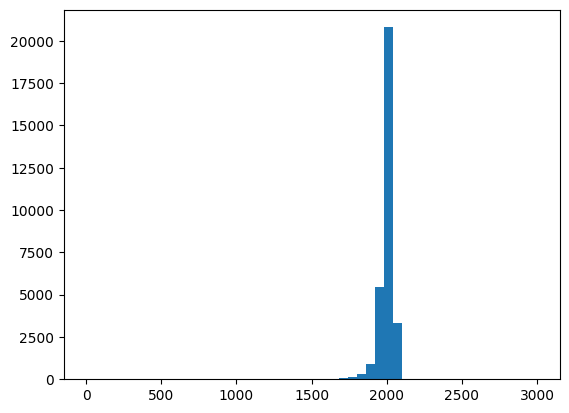

In [85]:
# histogram of sentences len, between 0 and 100
plt.hist([len(doc.page_content) for doc in chunks], bins=50, range=(0, 3000))

(array([2.4000e+01, 2.3000e+01, 2.9000e+01, 2.2000e+01, 1.9000e+01,
        2.2000e+01, 1.6000e+01, 3.4000e+01, 2.4000e+01, 2.5000e+01,
        1.9000e+01, 2.1000e+01, 3.2000e+01, 1.8000e+01, 1.9000e+01,
        3.1000e+01, 2.1000e+01, 2.5000e+01, 2.9000e+01, 2.3000e+01,
        2.4000e+01, 1.3000e+01, 2.0000e+01, 1.6000e+01, 2.0000e+01,
        1.7000e+01, 2.0000e+01, 3.5000e+01, 6.5000e+01, 1.1800e+02,
        3.3200e+02, 8.7800e+02, 5.4460e+03, 2.0798e+04, 3.3330e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
         540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
        1080., 1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560.,
        1620., 1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100.,
        2160., 2220., 2280., 2340.

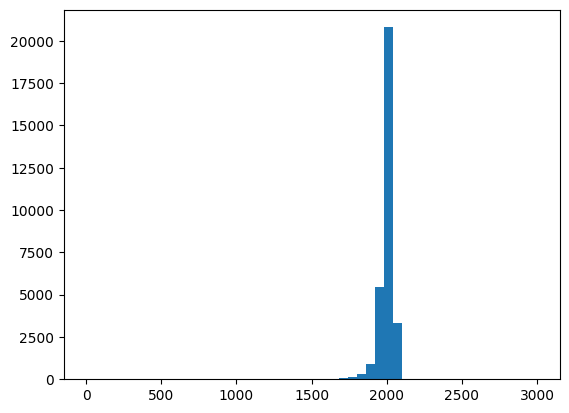

In [89]:
# histogram of sentences len, between 0 and 100
plt.hist([len(doc.page_content) for doc in chunks], bins=50, range=(0, 3000))

In [108]:
# show doc with most sentences
max_sentences = max(documents, key=lambda d: len(d.metadata["sentences"]))
max_sentences.metadata["url"]
max_sentences.page_content[:1000]

"Full text is available to Purdue University faculty, staff, and students on campus through this site.\nOff-campus Purdue users may download theses and dissertations by logging into the Libraries' proxy server with your Purdue Career Account.\nLinks to log in to the proxy server directly below the download button of each thesis or dissertation page.\nNon-Purdue users, may purchase copies of theses and dissertations from ProQuest or talk to your librarian about borrowing a copy through Interlibrary Loan.\n(Some titles may also be available free of charge in our Open Access Theses and Dissertations Series, so please check there first.)\nFortney, Sarah Katherine (2024) The Role of Trait and Specific Expectations in the Experience of Dysmenorrhea\nAbdullah, Umm E. Hani (2023) Exploratory Study of Deep Brain Stimulation in the Syngap1+/- Mouse Model of Autism Spectrum Disorder Using Electrophysiology\nAbney, Douglas John (2023) Broadband’s Role in Agricultural Job Postings In U.S. Counties\

In [110]:
# trim document page contents to 13000 characters
for doc in documents:
    doc.page_content = doc.page_content[:13000]

## 📐 1. Embedding searches

In [90]:
embeddings = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

In [112]:
reranker = KNNRetriever.from_documents(documents, embeddings, k=10)
results = reranker.get_relevant_documents(claim)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + "*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1*



**https://www.nzherald.co.nz/nz/judith-collins-accused-of-potential-conflict-of-interest/NXKZLIY4IZNGIN6GKTNQZQSJWQ/**

Justice Minister Judith Collins has been accused of potentially breaching conflict of interest rules for Cabinet ministers after a visit to a company her husband is a director of while in China.
One News reported that while Ms Collins was in China last Oct

**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

Justice Minister Judith Collins said she told milk product company Oravida that it could not use her photograph or name to endorse its products prior to visiting it in China last year and although its milk was "nice" that was not an endorsement of the comp

**https://eitr545824759.wordpress.com/2020/08/08/judith-collins-david-wong-tung-and-the-oravida-kauri-ltd-ruakaka-connection-and-that-broken-marsden-point-fuel-line-breakage-that-caused-nz-48m-in-economic-damage-no-one-has-subsequently-been-charged/**

David Wong-Tung, the husband of then energy minister Judith Collins, was a director of Kauri Ruakaka until 2017, but is no longer on its board.
Former Engineering NZ president Elena Trout who headed the inquiry, said it understood the contractor sold swamp

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars.
Oravida pays about $500 a year to draw up

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

When Judith wasn’t questionably meeting Chinese border officials or diverting to its trade events, Oravida also exported swamp Kauri.
The above quote was when Judith was challenged that Oravida was damaging the environment.
What a sad day for Judith, appar

**https://www.newshub.co.nz/home/money/2016/04/oravida-jumps-in-to-export-kiwi-water.html**

New Zealand water could be the next big export to China and one of the companies that has just jumped in for a slice of the pie is none other than Oravida.
The company is only paying a small amount to the council for the millions of litres it can take.
Sto

**https://thedailyblog.co.nz/2014/03/05/crusher-collins-conflict-of-interest-seems-as-large-as-her-interest-in-conflict/**

Collins says Oravida visit not conflict of interest
Judith Collins went on a taxpayer-funded visit to China last year. In her public role as Justice Minister, she was there to talk about our system.
But she was also welcomed into a New Zealand export compa

**https://www.newshub.co.nz/home/new-zealand/2015/10/greens-mp-apologises-over-swamp-kauri-claim.html**

A Green MP has apologised to Judith Collins' husband following a press release condemning the extraction of valuable swamp kauri.
In a statement released by the party's conservation spokeswoman Eugenie Sage in June, she called for the illegal export of anc

**https://www.odt.co.nz/business/nz-milk-fetches-big-bucks-china**

You are not permitted to download, save or email this image. Visit image gallery to purchase the image.
But the high-price reflects a more complicated supply chain - and the degree to which the high-quality product is sought after in China.
It's just one o

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.”
So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

## 📐 Max. Marginal relevance


In [92]:
%pip install --upgrade --quiet  rank_bm25

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You should consider upgrading via the '/home/ullriher/venvs/averitec/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [108]:
from langchain_community.retrievers import BM25Retriever

retriever = BM25Retriever.from_documents(
    chunks, k=1500
)
chunks_pruned = retriever.invoke(claim)

In [109]:
len(chunks_pruned)

1500

In [110]:
chroma = Chroma(f"dev_{CLAIM_ID}_mxbai", persist_directory=f"data_store/vector_store_dev/{CLAIM_ID}")
chroma.delete_collection()
documents_ = [doc.copy() for doc in chunks_pruned]
for doc in documents_:
    if 'sentences' in doc.metadata:
        doc.metadata.pop("sentences", None)
    
chroma = chroma.from_documents(documents_, embeddings)


In [106]:
# make or overwrite /home/ullriher/aic_averitec/data_store/vector_store_dev/CLAIM_ID and persist chroma there
!mkdir -p /home/ullriher/aic_averitec/data_store/vector_store_dev/{CLAIM_ID}
chroma(f"/home/ullriher/aic_averitec/data_store/vector_store_dev/{CLAIM_ID}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


AttributeError: 'Chroma' object has no attribute 'persist'

In [114]:
claim

'New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.'

In [120]:
from langchain_community.vectorstores import FAISS

db = FAISS.from_documents(chunks_pruned, embeddings)
db.save_local(f"data_store/vector_store_dev/{CLAIM_ID}")

In [118]:
results = db.similarity_search(claim, 10)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + " (mmr λ=0.5)*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 (mmr λ=0.5)*



**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

He also denied working with NZ First on the issue. Ms Collins recently responded to a request from NZ First about her China trips under the Official Information Act but Mr Robertson said he had not seen that. Labour had asked some questions to get information in August last year and worked on it further last month. Mr Key said the Cabinet Office did not believe Ms Collins' had endorsed the products. "The fact the company might write down something, that happens all the time. I go to lots of things where I hold up things or say oh I use your toilet paper or whatever it might be, that's not deemed to be an endorsement." Under Parliamentary privilege, he said the situation had echoes of former National MP Pansy Wong who resigned over allegations her husband had used Parliamentary travel perks to fly to China and did business while there - which was against the rules for the use of the perks. Ms Collins said her husband had accompanied her while on an official trip to China in 2012 but had paid for himself and was on holiday. Mr Roberston said Ms Collins had opened the Auckland office of Oravida in 2013 and Oravida donated more than $55,000 to National in 2011. He said National Party president Peter Goodfellow had met with its representatives and was also part owner of Sanfords which supplied fish products to Oravida. "So knowing all of that, Judith Collins goes to this office and promotes the products of that company. That is a conflict of interest. Judith Collins is not above the rules." * Judith Collins visited Oravida in China last year. Her husband is a director. A photo of Collins was put on its website with a caption saying she endorsed its products. It is against Cabinet rules to endorse products, or do anything from which a family member may benefit. 

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

In Parliament, Labour’s MP for Te Tai Tokerau, Kelvin Davis, asked the Government if ministers were “aware of reports that local wood manufacturers have been refused the opportunity to buy swamp kauri from Kauri Ruakaka mill, which was formerly called Oravida, and is allegedly involved in exporting raw swamp kauri?” One of the directors of Oravida is National MP Judith Collins’ husband, David Wong-Tung. Under further questioning in the House, Minister Nick Smith replied, “I thought the member (Kelvin Davis) was above getting involved in this kind of murk”. Winston Peters then asked Dr Smith,: “Is he denying what is well known in Northland because people who are high up in Oravida are major donors to the National Party?” Dr Smith replied that the law had been changed under Labour in 2004. He says there have been prosecutions under the Resource Management Act in the past and the Ministry for the Environment and Northland councils are confident the resource is being “responsibly managed”. wealthy donors using bribery to buy ethnic list seats in Parliament … All have strong common connections … Chinese influence (business interests and CCP) and Natz! Only a few reasons crass, uncaring, disrespectful, environment abuser Judith Collins should not be allowed near leading any political party! And yet she will take power in 2020, unless foreign colonists with voting rights are sent packing (how many Natzi voters are “we” importing on a daily basis?)… Your use of the word Natzi is disgraceful, reconsider. I would never vote for Collins, she is an absolute muppet and wants power far too much. Even though I wouldnt vote for Collins, doesn’t mean I would ever vote for Cindy, gave her the benefit of the doubt but she’s proving to be a creepy socialist through and through…. We need a third option, a proper conservative govt that doesn’t put the dole bludgers and economic ‘refugees’ before our hard working people. And your use of the name “Cindy” is disgraceful, reconsider or you will have the label HYPOCRITE! 

**https://www.nzherald.co.nz/nz/judith-collins-accused-of-potential-conflict-of-interest/NXKZLIY4IZNGIN6GKTNQZQSJWQ/**

Justice Minister Judith Collins has been accused of potentially breaching conflict of interest rules for Cabinet ministers after a visit to a company her husband is a director of while in China. One News reported that while Ms Collins was in China last October she visited the offices of Oravida, a New Zealand company which exports milk products to China. Her husband, David Wong Tung, is a director of Oravida and the company later put up a photo of Ms Collins claiming she had tasted and endorsed their products. It is against Cabinet Manual rules to endorse any product. Labour MP Grant Robertson said there was a perception of a conflict of interest. "Ministers have to be up front. Perception matters.'' Ms Collins said she was not aware of the photo and would ask for it to be removed if it breached Cabinet guidelines. "I certainly don't endorse any products other than the fact I always try and help New Zealand companies trying to export.'' Prime Minister John Key said he did not believe Ms Collins' husband's directorship of Oravida created a conflict of interest. "It doesn't preclude her dropping in. There is no commercial value there.'' 

**https://eitr545824759.wordpress.com/2020/08/08/judith-collins-david-wong-tung-and-the-oravida-kauri-ltd-ruakaka-connection-and-that-broken-marsden-point-fuel-line-breakage-that-caused-nz-48m-in-economic-damage-no-one-has-subsequently-been-charged/**

David Wong-Tung, the husband of then energy minister Judith Collins, was a director of Kauri Ruakaka until 2017, but is no longer on its board. Former Engineering NZ president Elena Trout who headed the inquiry, said it understood the contractor sold swamp kauri to Oravida when he found them and was not charged by Oravida for the digger. …Oravida, how extraordinary. Let’s remind ourselves about Oravida again… October 2013 – Judith Collins opens Oravida’s new Auckland headquarters. October 20, 2013 – Collins has dinner with Oravida bosses Stone Shi and Julia Xu, along with a senior Chinese border official in Beijing, China, while on a tax-funded trip. She claims it was a “personal dinner” and that no business was discussed. October 23, 2014 – Collins visits Oravida’s Shanghai offices “on the way to the airport”. December 23, 2013 – Oravida makes a $30,000 donation to the National Party. March 4, 2014 – Collins denies dinner was a conflict of interest. March 12, 2014 – Collins admits she had dinner with Oravida bosses, but calls suggestions she should resign “ridiculous”. She is put on her last warning by Prime Minister John Key. March 18, 2014 – Despite Collins’ claims she visited the Oravida offices in Shanghai “for a cup of tea on the way to the airport”, it is revealed the company’s offices are 30km in the opposite direction. April 15, 2014 – 3 News reveals Oravida requested help from the Government on Chinese border control issues just weeks before Collins’ dinner. April 17, 2014 – Winston Peters alleges the Chinese official present at the Beijing dinner represented the agency that decides whether imported food products are safe. May 2, 2014 – There are calls for Collins to resign, following the resignation of MP Maurice Williamson for interfering in a police case involving wealthy Chinese businessman Dongua Liu. 

**https://www.reddit.com/r/newzealand/comments/f50ujj/rnz_solved_mysteries_oravida_the_gas_line_and_the/**

In July 2015, parliamentary privilege was used to link the export of swamp kauri to Northland and National Party donors and insiders. In Parliament, Labour's MP for Te Tai Tokerau, Kelvin Davis, asked the Government if ministers were "aware of reports that local wood manufacturers have been refused the opportunity to buy swamp kauri from Kauri Ruakaka mill, which was formerly called Oravida, and is allegedly involved in exporting raw swamp kauri?" One of the directors of Oravida is National MP Judith Collins' husband, David Wong-Tung. The argument is that Oravida is exporting them to China under the guise of being tables and the money is being funneled into their political affiliations which just happen to include the political party Wong-Tung's wife (Judith Collins) is a prominent member of: National. This was of course denied, and RNZ even [had to write an apology to Oravida] (https://www.rnz.co.nz/news/national/276363/minister-defends-trade-in-kauri-swamp-logs) at the bottom of their article, saying that they were wrong to suggest Oravida were involved in the export of illegal swamp kauri. FYI.org.nz reports that the OIA request for Judith Collins to speak to her involvement was denied. You can follow the link to see the fuckery used to avoid fulfilling the request. However, when piecing together the company's purpose as Oravida Kauri Ltd, the people involved, and the history of questionable exports, it's quite clear that a proper investigation should have been done and putting it on the shoulders of the contractor seems unfair at best. And then there's Collin's connection as a National MP, her relationship with Oravida, and the donations and connections the company and the party have formed. In September 2017, a digger damaged part of a 168km jet-fuel line which caused tens of millions of dollars in lost business and repairs, grounded dozens of flights and caused havoc on the supply chain. 

**https://www.renews.co.nz/explainer-heres-what-you-need-to-know-about-new-national-leader-judith-collins/**

In 2014 she was accused of using a taxpayer-funded trip to lobby the Chinese government to support her husband’s company, Oravida. While on a visit to Shanghai as part of an official trip as Justice Minister, she had dinner with a Chinese government border official and leaders of dairy export company Oravida, which her husband was director of. Collins later said she regretted the visit and that her husband had not financially benefited as he was the director, not a shareholder. In 2016 when John Key resigned as National leader, Collins stood as a candidate, but Bill English became the leader. Then in 2018 when Bill English resigned as leader, Collins again entered the race, but Simon Bridges won the leadership. During Bridges’ reign, a poll ranked her higher as the preferred prime minister above Simon Bridges, even though she wasn’t even in the running to be PM at the time. 

**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

Justice Minister Judith Collins said she told milk product company Oravida that it could not use her photograph or name to endorse its products prior to visiting it in China last year and although its milk was "nice" that was not an endorsement of the company. Labour's Grant Robertson continued to claim Collins breached conflict of interest rules for ministers for the visit to Oravida, despite Prime Minister John Key saying the Cabinet Office had advised there was no breach. Ms Collins' husband is a director of the New Zealand milk product exporting company and after her visit, the company put a photo of her on its website and said she had tasted and endorsed its products. The Cabinet Manual prohibits Ministers endorsing products. It also says a perception of a conflict of interest may arise where a family member or friend of a minister could get some benefit from the ministers' actions or decisions. Ms Collins said she had told Oravida in advance that it could not use her name or photograph to endorse or promote its products and had not known about the photo on the website. She had since asked Oravida to ensure it was not claiming she endorsed it, in either English or mandarin. She had tasted the milk and said "it was nice" but that did not amount to an endorsement of the company. "Shock, horror, I drink milk. I promote New Zealand milk anywhere I go. It's the finest milk in the world." She said Mr Robertson's claims were "desperate" and solely because he was trying to help Labour leader David Cunliffe escape scrutiny for his use of trusts. However, Mr Robertson claimed there was still a clear conflict of interest. "Going to a company where her husband is a director, having a photo taken and being said to have endorsed the products fits within that conflict." Mr Robertson denied he had timed the allegations to detract attention from Mr Cunliffe's campaign funding. 

**https://thedailyblog.co.nz/2014/03/05/crusher-collins-conflict-of-interest-seems-as-large-as-her-interest-in-conflict/**

Collins says Oravida visit not conflict of interest Judith Collins went on a taxpayer-funded visit to China last year. In her public role as Justice Minister, she was there to talk about our system. But she was also welcomed into a New Zealand export company that her husband has a private interest in. She says the purpose of her visit was “to actually have a cup of tea on the way to the airport”. Ms Collins’ husband, David Wong-Tung, is one of three directors of Oravida – a milk and food export company. On its website the company referred to her as the Justice Minister. It says she recognised the company’s efforts, and “congratulated us on what we have achieved and encouraged us to continue”. Ms Collins also opened the company’s Auckland headquarters last year, with Mr Wong-Tung standing behind her. She says it is not an issue that she was effectively promoting the company where her husband is a director. Why isn’t this getting as much coverage as Cunliffe’s supposed betrayal of democracy? Judith Collins can’t wave her connection with her husbands company around much more than adding her name and posting photos with a promotional gulp of milk to support the product. “a conflict may arise if people close to a minister, such as a minister’s family […] might derive, or be perceived as deriving, some personal, financial, or other benefit from a decision or action by the minister”. “When accepting an invitation, a minister should inform the organisation that it may not use any photos taken of the minister at the event in a way that could be perceived as an endorsement by the minister.” There’s not really much wriggle room here is there? Nothing highlights the double standards within the media better than the difference in exposure between Cunliffe’s sins and what seems to be a Judith’s massive conflict of interest. I think why there is no coverage is the age old media bias by the owners of the sensationalism carnival – no mystery really. Will she be crushed by the weight of her own ego ? I hope so… 

**https://www.newshub.co.nz/home/money/2016/04/oravida-jumps-in-to-export-kiwi-water.html**

New Zealand water could be the next big export to China and one of the companies that has just jumped in for a slice of the pie is none other than Oravida. The company is only paying a small amount to the council for the millions of litres it can take. Stone Shi and Julia Xu are the brains behind Oravida, and part of Prime Minister John Key's delegation in Beijing. They're now exporting Kiwi water to China as a premium product. "It has been filtered for many many years, and through the filtration process it carries a lot of great minerals for bodies," Ms Xu says. The pair's close personal ties to Judith Collins caused a huge political controversy in 2014. They've now expanded from Scampi and milk, to water from a plant in the Bay of Plenty it bought for an undisclosed sum last year. Oravida has a consent to 146 million litres of ground water a year and the regional council says Oravida pays an annual compliance charge of around $500. Oravida markets the water at $1.60 a litre, meaning if all 146 million litres were sold it could be worth $233 million a year. "The right to draw water is determined by the local council," Ms Xu says. The Prime Minister says water could be the next big thing, saying the market is "potentially huge". It's huge because of New Zealand's clean, green image, which Oravida is using as a key selling point. 

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars. Oravida pays about $500 a year to draw up to 400,000 litres of water a day from the Otakiri Aquifer in Bay of Plenty. This will allow the company to take up to 146 million litres a year from the aquifer until 2026. An Bay of Plenty Regional Council spokesperson said Oravida had paid a total $1503 for the consents since 1992, and last year paid $526 in compliance costs. "The Resource Management Act 1991 only allows the Regional Council to recover actual and reasonable costs associated with processing and managing resource consent applications to take water," she said. Massey University freshwater ecologist Mike Joy said the same thing will keep happening until the government charged for water. "It's just a free for all for a tiny proportion of New Zealanders, that abuse something that belongs to all of us. Whether they be farmers polluting the water, or taking it out for irrigation, or if it's bottling companies taking it away, the core issue is that we are not putting a price on it." Mr Joy said charging users would dramatically improve how efficiently water was used. Greens water issues spokesperson Catherine Delahunty said it was wrong for companies like Oravida to make a profit by exporting this increasingly valuable resource. "This is happening not only in the Bay of Plenty but all over the country. There's 74 bottling plants. But, when the water is purely for export it means we're giving away that water for nothing, when we may need it in the future." Hundreds of people marched in Ashburton on Saturday, protesting against the council there selling off a piece of land with the right to extract 45 litres of water a second from the town's aquifers for the next 30 years. 

In [119]:
results = db.max_marginal_relevance_search(claim, 10, 40, .5)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + " (mmr λ=0.5)*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 (mmr λ=0.5)*



**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

He also denied working with NZ First on the issue. Ms Collins recently responded to a request from NZ First about her China trips under the Official Information Act but Mr Robertson said he had not seen that. Labour had asked some questions to get informat

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars. Oravida pays about $500 a year to draw up

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

Hundreds of submissions were received during public consultation last year. Collins also refers to Greta Thunberg, the 17-year-old activist who sparked the global School Strike For Climate movement, which moved online after the pandemic outbreak. On New Ze

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

When Judith wasn’t questionably meeting Chinese border officials or diverting to its trade events, Oravida also exported swamp Kauri. The above quote was when Judith was challenged that Oravida was damaging the environment. What a sad day for Judith, appar

**https://www.newsroom.co.nz/wong-tung-threatens-to-sue-newsroom**

National leader Judith Collins’ husband is threatening defamation action against Newsroom over a story about a West Coast mine site that the conservation department allowed to be left in a state likened to a “moonscape” by a conservationist. David Wong-Tun

**https://www.nzherald.co.nz/nz/china-likes-our-milk-at-23-a-bottle/4MLEK2QVLOSVJASQO3YJJDI6UM/**

Currently, its exports are restricted to milk and Sanford's seafood - specifically salmon and scampi. National Party president Peter Goodfellow is among the National Party people featured on Oravida's website. He is a large shareholder in Sanfords, which s

**https://fyi.org.nz/request/6595-involvement-of-kauri-ruakaka-limited-in-the-oil-pipeline-rupture-between-whangarei-and-auckland**

Involvement of KAURI RUAKAKA LIMITED in the oil pipeline rupture between Whangarei and Auckland Reuben Tilley made this Official Information request to Minister of Energy and Resources The request was refused by Minister of Energy and Resources. Can you pl

**https://community.scoop.co.nz/2014/04/dave-wolland-cartoons-april-19-2014/**

NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not being very transparent about her relationship and meetings in China with the Chinese-owned milk company Oravida. NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not b

**https://www.parliament.nz/en/pb/hansard-debates/rhr/document/51HansD_20141104_00000012/organised-crime-and-anti-corruption-legislation-bill**

Judith Collins introduced this legislation to Parliament. The irony of that is that Judith Collins introduced this legislation around the time that she took a trip to China to talk about reducing corruption, and yet she was surreptitiously visiting Oravida

In [112]:
results = chroma.max_marginal_relevance_search(claim, 10, 40, .5)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + " (mmr λ=0.5)*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 (mmr λ=0.5)*



**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

He also denied working with NZ First on the issue. Ms Collins recently responded to a request from NZ First about her China trips under the Official Information Act but Mr Robertson said he had not seen that. Labour had asked some questions to get informat

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

In Parliament, Labour’s MP for Te Tai Tokerau, Kelvin Davis, asked the Government if ministers were “aware of reports that local wood manufacturers have been refused the opportunity to buy swamp kauri from Kauri Ruakaka mill, which was formerly called Orav

**https://www.renews.co.nz/explainer-heres-what-you-need-to-know-about-new-national-leader-judith-collins/**

In 2014 she was accused of using a taxpayer-funded trip to lobby the Chinese government to support her husband’s company, Oravida. While on a visit to Shanghai as part of an official trip as Justice Minister, she had dinner with a Chinese government border

**https://www.newshub.co.nz/home/new-zealand/2015/10/greens-mp-apologises-over-swamp-kauri-claim.html**

A Green MP has apologised to Judith Collins' husband following a press release condemning the extraction of valuable swamp kauri. In a statement released by the party's conservation spokeswoman Eugenie Sage in June, she called for the illegal export of anc

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars. Oravida pays about $500 a year to draw up

**https://community.scoop.co.nz/2014/04/dave-wolland-cartoons-april-19-2014/**

NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not being very transparent about her relationship and meetings in China with the Chinese-owned milk company Oravida. NZ Cabinet Minister, Judith Collins, has dug a hole for herself by not b

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://www.nzherald.co.nz/nz/china-likes-our-milk-at-23-a-bottle/4MLEK2QVLOSVJASQO3YJJDI6UM/**

Currently, its exports are restricted to milk and Sanford's seafood - specifically salmon and scampi. National Party president Peter Goodfellow is among the National Party people featured on Oravida's website. He is a large shareholder in Sanfords, which s

**https://newsroom.co.nz/2020/08/10/wong-tung-threatens-to-sue-newsroom/**

National leader Judith Collins’ husband is threatening defamation action against Newsroom over a story about a West Coast mine site that the conservation department allowed to be left in a state likened to a “moonscape” by a conservationist. David Wong-Tun

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

Hundreds of submissions were received during public consultation last year. Collins also refers to Greta Thunberg, the 17-year-old activist who sparked the global School Strike For Climate movement, which moved online after the pandemic outbreak. On New Ze

## ❌ Cross-encoder re-ranking 

In [100]:
# Load the model, here we use our base sized model
model_name = "mixedbread-ai/mxbai-rerank-large-v1"
model = CrossEncoder(model_name)

# Example query and document

# Lets get the scores
results = model.rank(claim, [doc.page_content for doc in chunks_pruned], return_documents=True, top_k=10)


display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + model_name + "*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    r = chunks_pruned[r['corpus_id']]
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-rerank-large-v1*



**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://www.sbs.com.au/news/article/new-zealand-opposition-chooses-judith-collins-to-take-on-jacinda-ardern-at-september-election/pd95nod40**

Long-serving politician Judith Collins will lead New Zealand's opposition National Party into an election against a popular government in just over two months, taking over from Todd Muller, who quit as leader citing health reasons. Mr Muller shocked politi

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

A flamboyant figure with a penchant for a cutting turn of phrase and designer outfits, as well as a larger-than-life manner, Collins has proved polarising, even among her party. She favoured a policy, in her past as a tough-on-crime minister of police and 

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

WHOEVER E-MAILED MARK RICHARDSON on Wednesday morning’s AM Show was right: Judith Collins scares me. For the first time since National’s caucus replaced Don Brash with John Key, the party has chosen a leader who can win. The new Leader of the Opposition is

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

New Zealand’s prime minister, Jacinda Ardern, widely known for her exhortations to kindness and compassion, will face Judith Collins – a combative, tough-talking conservative lawmaker who styled herself after Margaret Thatcher – in the country’s general el

**https://www.interest.co.nz/news/106045/national-caucus-elects-judith-collins-partys-new-leader-deputy-unknown-press-conference**

Judith Collins has been elected National Party Leader, following Todd Muller’s shock resignation from the role on Tuesday morning. The National Party caucus took about two hours to make the decision on Tuesday evening. Thereafter, members of the caucus sto

**https://www.rnz.co.nz/news/political/421417/national-leader-judith-collins-announces-infrastructure-plan-rma-repeal**

An eye-watering $31 billion is the price tag National has put on the infrastructure upgrade required to fix the country's transport network and Auckland and upper North Island's congestion crisis. In her first big policy announcement today, new National le

**https://thedailyblog.co.nz/2020/07/23/guest-blog-bryan-bruce-collins-and-muldoon/**

I’ve seen a couple of recent political commentaries comparing National’s new leader Judith Collins to the late former Prime Minister Robert Muldoon who dominated New Zealand politics from the mid 1970’s to the mid 1980’s. Certainly the little bit of the fi

**https://bryangould.com/2018/10/**

He is marked down because people do not warm to the way he comes across. Who is to say that they would warm to another leader who was even more aggressive and lacking in charm? There are many qualities other than aggression that voters seek – as Jacinda Ar

**https://www.newshub.co.nz/home/politics/2020/07/judith-collins-biggest-controversies-troublesome-tweets-resignations-and-dirty-politics.html**

Judith Collins is the new leader of National after the party accepted Todd Muller's resignation and backed her to take over on Tuesday. It's been a tumultuous road to the helm for Collins, a role she's put herself forward for twice before - one fraught wit

In [101]:
for r in results:
    newline = "\n"
    r = chunks_pruned[r['corpus_id']]
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content}"))

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.” So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime ministers, Jacinda Ardern. In many ways, the two could not be more different. Margaret Thatcher is Collins’ political hero. “I like the fact she didn’t give up when others would have. She didn’t give in to what other people thought she should do, or be.” Collins, 61, is a famously tough, take-no-prisoners party stalwart, nicknamed “Crusher Collins” for her desire to destroy the cherished cars of boy racers. She is also famed for her tough stance on crime, supported the introduction of Tasers to the police force, and argued for officers to have better access to firearms. But there is another side. She is one of the more socially liberal National leaders in recent years, she loathes “all forms of racism and sexism”, voted for the legalisation of same-sex marriage, taking abortion out of the Crimes Act, and legalising euthanasia. She is also an animal tragic who is still grieving the loss of her dog, Holly, euthanised while the country was under effective house-arrest. The leadership of the centre-right National party has eluded Collins for years, despite her evident penchant and suitability for a leadership role. On Tuesday – when Todd Muller unexpectedly resigned after 53 days citing health reasons – Collins claimed the top job, saying the party had decided her “strength and decisiveness” were what the party needed so close to an election and after a slew of high-profile resignations. Collins may also be the party’s only hope against the staggering popularity of Ardern. The daughter of Waikato dairy farmers, Collins has long been a decisive political figure in New Zealand’s otherwise somewhat beige parliament, and in her 18 years in the beehive – as the parliamentary building is known – she has never been far from the action. 

**https://www.sbs.com.au/news/article/new-zealand-opposition-chooses-judith-collins-to-take-on-jacinda-ardern-at-september-election/pd95nod40**

Long-serving politician Judith Collins will lead New Zealand's opposition National Party into an election against a popular government in just over two months, taking over from Todd Muller, who quit as leader citing health reasons. Mr Muller shocked politicians in the right-of-centre party saying he was stepping down "effective immediately." The 67-year-old former business executive had led the party for only 53 days, toppling previous leader Simon Bridges in a leadership coup amid National's stagnant polling numbers. Ms Collins was chosen to take over the leadership in a hastily arranged meeting of the party's parliamentary caucus in Wellington on Tuesday evening. She is National's fourth leader in three years and its second female leader. Ms Collins was first elected to Parliament in 2002, serving in governments under prime ministers John Key and Bill English. She held police and corrections portfolios and is seen to represent the right-wing of the National Party, having previously promoted strong law and order policies. Ms Collins now faces the task of trying to rally National's support 67 days from 19 September elections at which it will try to unseat the governing Labour Party of popular Prime Minister Jacinda Ardern. Judith Collins (right) with new deputy leader Gerry Brownlee (left) at New Zealand Parliament in Wellington. Recent polls show Labour with sufficient support to form a majority government, a first since New Zealand adopted a system of proportional representation in 1996. All previous governments since that time have been coalitions and Labour currently governs with the support of the Green Party and right-of-centre New Zealand First led by Winston Peters. Mr Muller's sudden departure forced a scramble of lawmakers to Wellington during a parliamentary recess. Mr Muller said his health made his continuation in the leadership untenable. 

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

A flamboyant figure with a penchant for a cutting turn of phrase and designer outfits, as well as a larger-than-life manner, Collins has proved polarising, even among her party. She favoured a policy, in her past as a tough-on-crime minister of police and corrections, of impounding and crushing the cars of so-called “boy racers”, earning her the nickname “Crusher Collins” – which is still widely used. Other than Ardern she is one of the few New Zealand lawmakers whose first name alone would spark recognition with the public. Ben Thomas, a centre-right commentator, said that made her the party’s only choice. “She’s the only person in National who is assured enough and polished enough to foot it with Jacinda Ardern,” he said. Thomas added that the “patricians” of the party had been unable to “go head to head” with the prime minister, who often answers the public’s questions in Facebook Live broadcasts from home and had a 54% preferred prime minister rating in a June poll (her then-rival, Muller, held 13% support). Collins’s rise came at the end of a horror day for National; its lawmakers had been unaware of what was coming when their leader suddenly announced his resignation, “effective immediately” by email on Tuesday morning, saying in a statement that his leadership was “untenable from a health perspective” and had “taken a heavy toll” on him personally. “It has become clear to me that I am not the best person to be leader of the opposition and leader of the New Zealand National party at this critical time for New Zealand,” said Muller. “It is more important than ever that the New Zealand National party has a leader who is comfortable in the role.” He has made no further comment, has not appeared in public since his resignation, and did not attend Tuesday’s meeting to select his replacement. In June, shortly after Muller assumed the leadership after ousting his predecessor, National had risen in the polls to just 38% against Labour’s 50% – meaning Ardern’s party could govern alone. 

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

WHOEVER E-MAILED MARK RICHARDSON on Wednesday morning’s AM Show was right: Judith Collins scares me. For the first time since National’s caucus replaced Don Brash with John Key, the party has chosen a leader who can win. The new Leader of the Opposition is a clear-sighted defender of the neoliberal order who is prepared to give when she needs to give, and takes no prisoners when she doesn’t. Collins is articulate, shrewd and possesses a disarming (if somewhat cruel) sense of humour. Those on the left who dismiss her as a major electoral turn-off will, almost certainly, be proved wrong. She has what it takes to manoeuvre Jacinda and Labour onto the defensive. And, as everybody knows: explaining is losing. Like Act’s current collection of strategists, Collins understands that delivering neoliberalism straight leaves voters with a sour taste in their mouths. It goes down much better when fizzed-up with lashings of law-and-order rhetoric – along with generous splashes of “culture wars” liqueur. That Collins, herself, happily owns up to being a “social liberal”, only adds an extra kick to her political cocktail. It’s this political ambiguity that makes National’s new leader so dangerous. Collins does not belong to the crazy Christian Right faction of her caucus, but neither is she a member of the Nikki Kaye, Amy Adams, Chris Bishop “soppy liberal” wing of the party. (Although she may, from time-to-time, be found voting alongside them.) For a long while now this ambiguity has constituted an unhelpful obstacle to her advancement. With the right rejecting her as too left, and the left dismissing her as too right, she has fallen repeatedly between the two stools. But now, with both factions severely discredited, being a little bit country and a little bit rock-n-roll has proved to be no bad thing at all. When pitted against Jacinda, however, it’s Collins’ neoliberalism which is likely to prove most deadly. 

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

New Zealand’s prime minister, Jacinda Ardern, widely known for her exhortations to kindness and compassion, will face Judith Collins – a combative, tough-talking conservative lawmaker who styled herself after Margaret Thatcher – in the country’s general election in September following a leadership vote in the centre-right National party. Collins, who has long held leadership ambitions but whose party is floundering in the polls, will face an uphill battle to persuade voters away from Ardern, one of the most popular New Zealand prime ministers of all time. Her centre-left Labour party is riding high in the polls after Ardern’s government quashed the spread of Covid-19 in the country, with many regarding the prime minister as something of a saviour figure. While Collins’s predecessor had said he would not oppose the government “for opposition’s sake,” her ascension sets the stage for a clash of ideologies on the campaign trail: the 61-year-old politician, who has decried the “woke left”, said in May that she was “sick of being demonised” for being white. “I think it’s important that we give credit where it’s due,” she said of Ardern at a news conference after she won a late-night vote on Tuesday. But there was “no chance at all that I’m going to let Jacinda Ardern get away with any nonsense”. The new party leader was staunch when she took the podium, surrounded by her MPs, after National held a late-night, closed-door vote at New Zealand’s parliament in Wellington, following the shock resignation on Tuesday morning of Todd Muller. He quit abruptly after leading the party for a volatile 53 days – the shortest stint in its history – characterised by leaks, distractions, weak interview performances, and rogue MPs. He had ousted the previous leader, Simon Bridges in a coup in May after dismal polling showed a heavy loss for the party in September. 

**https://www.interest.co.nz/news/106045/national-caucus-elects-judith-collins-partys-new-leader-deputy-unknown-press-conference**

Judith Collins has been elected National Party Leader, following Todd Muller’s shock resignation from the role on Tuesday morning. The National Party caucus took about two hours to make the decision on Tuesday evening. Thereafter, members of the caucus stood alongside Collins and Brownlee as they addressed media. "Third time lucky," Collins said, referring to the other leadership bids she's made. She said Paul Goldsmith would remain National's finance spokesperson, but couldn't confirm whether Michael Woodhouse would remain health spokesperson. “I don’t see major shifts at all in the policies we have," she said, stressing there wouldn’t be “wholesale” policy changes. Collins said the caucus decision not to work with New Zealand First still stood. “I think we need to be very focussed on just sticking to focussing on our party vote, and understanding there are other players coming into politics at this time as well,” she said. While Muller, and his former deputy Nikki Kaye in particular, were well-placed to target centrist voters, Collins said: “I think it is important that we send some very strong messages out to our base voters, who have been, obviously, a bit discombobulated with the last day or so. They need to know that we’re absolutely back on track and we will be taking the fight to the Government.” Asked whether she would adopt the same approach Muller said he would - to not be in “opposition for opposition’s sake”, Collins responded: “I think it’s important that we give credit where it’s due, but at the same time there is no chance at all that I’m going to let Prime Minister Jacinda Ardern get away with any nonsense when it comes to our economy and doing her job. Collins described herself as a "provincial Aucklander", saying her strengths were her toughness, experience and ability to make decisions. “I am hoping the National Party will collectively crush the other lot,” she said. 

**https://www.rnz.co.nz/news/political/421417/national-leader-judith-collins-announces-infrastructure-plan-rma-repeal**

An eye-watering $31 billion is the price tag National has put on the infrastructure upgrade required to fix the country's transport network and Auckland and upper North Island's congestion crisis. In her first big policy announcement today, new National leader Judith Collins delivered the opposition's infrastructure plan - a policy former leader Todd Muller was meant to make before quitting on Tuesday. Collins has also announced a National government would repeal the Resource Management Act completely, and replace it with two new pieces of law. More than half of the money announced by Collins today ($17b) would be invested in the upper north, which Collins said was home to half of all New Zealanders. To fix the congestion issues, Collins announced "National would go ahead with everything Labour has said it will do in transport" - with the exception of Transport Minister Phil Twyford's "light-rail Ghost Trains, and the probable exception of the $360 million Skypath 2". She said National would also go much further, with some work beginning immediately and the larger projects rolled out over the next decade. One of the most ambitious projects announced was four-lane expressways - including tunnels under the Brynderwyn and Kaimai mountain ranges - to connect Whangārei, Auckland, Hamilton and Tauranga. "National's vision is to transform the four cities to be one economic powerhouse, unlocking their potential so the upper North Island becomes Australasia's most dynamic region,'' Collins said. Also part of the announcement is Auckland's rapid transit network, including rail to the airport and new busways. "One rough definition of a city is that it is a place you can get from one side to the other in an hour, or a place that the average time to get to work is 30 minutes. National will measure our progress against the goals of 30 minutes to get to work and one hour to get across the city,'' Collins said. 

**https://thedailyblog.co.nz/2020/07/23/guest-blog-bryan-bruce-collins-and-muldoon/**

I’ve seen a couple of recent political commentaries comparing National’s new leader Judith Collins to the late former Prime Minister Robert Muldoon who dominated New Zealand politics from the mid 1970’s to the mid 1980’s. Certainly the little bit of the first exchange in the house I caught between Collins and P.M. Ardern invites the comparison in the pugnacious political style the new Opposition Leader is projecting. There is also more than an element of the “Think Big “ project of the Muldoon era in Collins’ plan to bypass the Resource Management Act for huge infrastructure projects such as the proposed four-lane highway from Whangarei to Tauranga and a second Auckland harbour crossing. The idea that you just bulldoze any legislation designed to protect our environment out of the way in the name “progress” is very Muldoon at his draconian worst. Most Acts of Parliament require review from time to time and the RMA is no exception . Moreover, in my view, Transport is certainly one of those areas where Labour is weakest and therefore most vulnerable to attack from the Right. It does seem to me however, as we watch the issue of traffic congestion especially in Auckland and Wellington being debated in the run up to the election, that we need to think about whether more cars on our roads (be they petrol driven or electric) is really such a great idea. Or whether a radical rethink about how we get from A to B – eg. completely free, highly efficient bus, light rail and train services – is in order As for Muldoon. I interviewed him on two occasions. He was a highly divisive politician who rolled the job of Finance Minister into that of the Prime Minister and became drunk on power. But, he was something Judith Collins and her current National Party colleagues are not. He was anti-neoliberal. He rejected Treasury’s advice to follow the economic path of self-centeredness being advocated by Britain’s then Conservative Prime Minister Margaret Thatcher and Republican President Ronald Regan. 

**https://bryangould.com/2018/10/**

He is marked down because people do not warm to the way he comes across. Who is to say that they would warm to another leader who was even more aggressive and lacking in charm? There are many qualities other than aggression that voters seek – as Jacinda Ardern’s popularity demonstrates. A leader of the Opposition who was able to mix it in a roughhouse could still be seen as lacking the poise and judgment that would be needed in a Prime Minister. We should never forget that what makes the job of leading the Opposition so difficult is that the holder of that office must be seen not only as an effective and combative critic of the government but also as a potential Prime Minister. It is here that the case for a Judith Collins leadership really starts to crumble. We now know enough about her to doubt whether she is an appropriate, let alone credible, candidate for the top job. A simple rehearsal of some of the high (or perhaps that should be low) points of her political career should be enough to confirm those doubts. Her close relationship with Cameron Slater – he of “Dirty Politics” fame – should ring the alarm bells; Cameron Slater regards her as his mentor in the black arts and has said as much. Her refusal to recognise the conflict of interest implicit in a dinner with her husband’s firm, Oravida, when on a taxpayer-paid ministerial visit to China was compounded by the misinformation she offered to explain the visit she paid to its offices – it was, she said, simply for a “cup of tea on the way to the airport”, when the airport was actually in the opposite direction. These malfeasances obliged both the Speaker and John Key, when Prime Minister, to reprimand her and stand her down. These elements strongly suggest that what might be seen by her supporters as a commendable willingness to cut corners and to “get down and dirty” should actually disqualify her from offering herself as a potential Prime Minister. 

**https://www.newshub.co.nz/home/politics/2020/07/judith-collins-biggest-controversies-troublesome-tweets-resignations-and-dirty-politics.html**

Judith Collins is the new leader of National after the party accepted Todd Muller's resignation and backed her to take over on Tuesday. It's been a tumultuous road to the helm for Collins, a role she's put herself forward for twice before - one fraught with resignations, troublesome tweets and Dirty Politics. But she's arrived now, and believes there are no skeletons left in the closet. "If anyone's gone through having all their emails gone through, all their phone records and everything else for years… I think we're perfectly fine," she told Magic Talk on Wednesday. "If someone wants to try something, fine. I'm ready for them. I'm focused on the people of New Zealand, I'm not worrying about the sort of muckrakers we've dealt with in the past." Need a reminder of what Collins has dished up in the past? Below are the biggest controversies of her political career. Judith Collins was accused in 2014 of a conflict of interest with Oravida bosses - a company where her husband was a director - and a Chinese official. During a taxpayer-funded visit to China in her role as Justice Minister in 2013, Collins was welcomed into the New Zealand export company and endorsed the milk it produced. Prime Minister John Key criticised the visit, causing Collins to apologise. However she said the Chinese official - who she refused to name - was a "very close personal friend". She also claimed it was "not necessarily true" that her husband would benefit financially from the company doing well, as he wasn't a shareholder. Key told media Collins was on her final warning over the incident - but she maintained she had Key's permission to meet with the company. Also in 2014, Collins found herself embroiled in the scandal sparked by Nicky Hager's Dirty Politics - an explosive book that had an entire chapter devoted to her alleged unscrupulous tactics. 